In [1]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline, interp1d
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score, coverage_error
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

translate_dic = {'alpha':r'$\alpha$','beta':r'$\beta$','delta':r'$\delta$','gamma':r'$\gamma$','Pnma':r'orthorhombic','tetragonal':r'$\beta$'}    

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

# 1 Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    n_mix:             List of n compounds coexisting in one XRD.
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print('\n{} chemical spaces created:'.format(len(self.multiphase)))
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  n_mix=[1,2,3], resonable_mixing=False, min_mixing_ratio=0.05, 
                  high_orientation_probability=0.2, crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.choice(n_mix, batch_size, replace=True)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing and self.n_mix_list[i]!=1:
                self.sample_idxs = []
                samples = []
                while len(samples) < self.n_mix_list[i]:
                    samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                self.n_mix_list[i] = min(self.n_mix_list[i],len(samples))
                samples = np.random.choice(samples, self.n_mix_list[i], replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                if np.random.binomial(1, high_orientation_probability) == 1:
                    high_orientation_peak_index = np.random.choice(np.argpartition(dataloader.X_short,-3)[-3:],1)[0]
                    self.X_short = np.array([self.X_short[high_orientation_peak_index]])
                    self.twotheta_short = np.array([self.twotheta_short[high_orientation_peak_index]])
                
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])
                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list, self.n_mix_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [3]:
folder = os.getcwd()
cif_folder = os.path.join(folder, 'cif')
dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

# 2 Single phase classification

## 2.1 Early fusion (precursor label)

In [4]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_early_fusion')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


['Pb I Cs Cl'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Cs Br Pb'] ['orthorhombic-CsPbBr3'] 33 33
['Br Cs Pb Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Cl Pb Br Cs'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Cs Cl I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['I Pb FA'] ['alpha-FAPbI3'] 44 44
['I Pb Cs Cl'] ['CsPb(I0.6Cl0.4)3'] 30 30
['Cs I Pb Br'] ['CsPb(I0.6Br0.4)3'] 26 26
['FA Pb MA I'] ['MA0.6FA0.4PbI3'] 53 53
['Pb MA Br FA'] ['MA0.4FA0.6PbBr3'] 48 48
['FA Pb MA Br'] ['MA0.2FA0.8PbBr3'] 47 47
['MA I Pb'] ['tetragonal-MAPbI3'] 63 63
['I Br Cs Pb'] ['CsPb(I0.6Br0.4)3'] 26 26
['I Cl Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['I FA Pb Cs'] ['Cs0.2FA0.8PbI3'] 4 5
['Pb I MA FA'] ['MA0.6FA0.4PbI3'] 53 53
['Cs Pb Br FA'] ['Cs0.6FA0.4PbBr3'] 2 2
['Pb Cs FA Br'] ['Cs0.2FA0.8PbBr3'] 0 0
['Br Cs Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 10
['Br Pb FA Cs'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 33
['I Cs Pb MA'] ['Cs0.6MA0.4PbI3'] 14 14
['Pb MA Br FA'] ['MA0.8FA0.2PbBr3'] 50 50
['FA MA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 47
['Cl Pb M

['I Cs MA Pb'] ['Cs0.6MA0.4PbI3'] 14 12
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['Pb Cs I'] ['gamma-CsPbI3'] 38 38
['Cs Cl Pb Br'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Pb I MA'] ['tetragonal-MAPbI3'] 63 63
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['Cs I Pb'] ['gamma-CsPbI3'] 38 38
['FA Pb Br'] ['cubic-FAPbBr3'] 43 43
['Pb FA Br MA'] ['MA0.2FA0.8PbBr3'] 47 47
['FA I Pb MA'] ['MA0.4FA0.6PbI3'] 52 52
['MA Cs Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['Br Cs MA Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['I Cs MA Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Pb Cs FA I'] ['Cs0.8FA0.2PbI3'] 7 7
['Cs I Br Pb'] ['CsPb(I0.8Br0.2)3'] 27 27
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 34
['Cs MA Pb I'] ['Cs0.4MA0.6PbI3'] 13 13
['Pb I FA Cs'] ['Cs0.4FA0.6PbI3'] 5 7
['Cs Pb Cl Br'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['Pb Br I MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['Pb MA I'] ['tetragonal-MAPbI3'] 63 63
['Cl Pb Br Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Cs Pb MA Br'] ['Cs0.8MA0.2PbBr3'] 11 11
['Pb Br Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Pb Cs I'] ['delta-CsPbI3'] 37 37
['Cs Br'] ['C

['Cs Pb FA Br'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb Cs Br FA'] ['Cs0.2FA0.8PbBr3'] 0 0
['I FA Pb Cs'] ['Cs0.8FA0.2PbI3'] 7 7
['Br Pb Cs MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['Br Pb FA I'] ['FAPb(Br0.8I0.2)3'] 42 42
['Br Pb Cs'] ['Cs4PbBr6'] 16 33
['MA I Pb'] ['tetragonal-MAPbI3'] 63 63
['Cs Pb MA Br'] ['Cs0.6MA0.4PbBr3'] 10 10
['FA Pb Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 1
['Br Cs Pb'] ['cubic-CsPbBr3'] 32 32
['Cs Pb I MA'] ['Cs0.8MA0.2PbI3'] 15 15
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Cs Pb MA Br'] ['Cs0.2MA0.8PbBr3'] 8 8
['I MA Pb'] ['tetragonal-MAPbI3'] 63 63
['Cs FA Pb I'] ['Cs0.6FA0.4PbI3'] 6 6
['MA Pb FA I'] ['MA0.2FA0.8PbI3'] 51 51
['MA I Pb FA'] ['MA0.8FA0.2PbI3'] 54 52
['Br I FA Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA Pb I'] ['delta-FAPbI3'] 46 46
['Br MA Pb'] ['cubic-MAPbBr3'] 59 59
['Cl Cs Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 28
['FA I Br Pb'] ['FAPb(Br0.8I0.2)3'] 42 42
['MA FA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 47
['Cs Pb FA Br'] ['Cs0.8FA0.2PbBr3'] 3 3
['FA MA Pb Br'] ['MA0.4F

['Cs FA Pb I'] ['Cs0.6FA0.4PbI3'] 6 6
['Cs Pb I Br'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb Cs I Cl'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Cl I Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Pb Br Cs Cl'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['Pb I MA Cs'] ['Cs0.4MA0.6PbI3'] 13 15
['I Cs FA Pb'] ['Cs0.2FA0.8PbI3'] 4 4
['Br Pb'] ['PbBr2'] 64 64
['Pb Br MA Cs'] ['Cs0.2MA0.8PbBr3'] 8 8
['Cs MA Pb I'] ['Cs0.8MA0.2PbI3'] 15 15
['Br MA Cs Pb'] ['Cs0.4MA0.6PbBr3'] 9 8
['Cl Pb Cs I'] ['CsPb(I0.2Cl0.8)3'] 28 28
['I FA Pb'] ['alpha-FAPbI3'] 44 44
['Cl Br Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Cs Pb Cl I'] ['CsPb(I0.2Cl0.8)3'] 28 28
['FA I Cs Pb'] ['Cs0.2FA0.8PbI3'] 4 7
['Pb Cs Cl'] ['Pnma-CsPbCl3'] 34 34
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Pb I MA Br'] ['MAPb(Br0.8I0.2)3'] 58 58
['Pb I MA Cs'] ['Cs0.6MA0.4PbI3'] 14 15
['Cs Cl Pb I'] ['CsPb(I0.2Cl0.8)3'] 28 30
['Cs Pb Cl'] ['Pnma-CsPbCl3'] 34 34
['Cl Cs I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb FA Cs I'] ['Cs0.6FA0.4PbI3'] 6 6
['Br Pb FA'] ['cubic-FAPbBr3'] 43 43
['Br Cs I Pb'] ['Cs

['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 34
['MA FA Pb I'] ['MA0.2FA0.8PbI3'] 51 51
['I Cs Pb FA'] ['Cs0.6FA0.4PbI3'] 6 6
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['I MA Pb Cs'] ['Cs0.6MA0.4PbI3'] 14 14
['I Pb FA Cs'] ['Cs0.4FA0.6PbI3'] 5 5
['FA Br Pb I'] ['FAPb(Br0.2I0.8)3'] 39 39
['I Br FA Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 60
['I FA Pb MA'] ['MA0.2FA0.8PbI3'] 51 51
['MA I Cs Pb'] ['Cs0.8MA0.2PbI3'] 15 15
['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 34
['Pb Cs Br'] ['cubic-CsPbBr3'] 32 32
['Pb FA Br I'] ['FAPb(Br0.4I0.6)3'] 40 40
['Cs Pb Br FA'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb I FA'] ['alpha-FAPbI3'] 44 44
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['Pb I FA Cs'] ['Cs0.2FA0.8PbI3'] 4 7
['I MA Pb Br'] ['MAPb(Br0.2I0.8)3'] 55 55
['Cl Cs I Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Br Cs Pb Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['MA Cs Pb I'] ['Cs0.6MA0.4PbI3'] 14 14
['Cs MA I Pb'] ['Cs0.8MA0.2PbI3'] 15 14
['MA Pb Cs I'] ['Cs0.2MA0.8PbI3'] 12 12
['Pb I FA Br'] ['FAPb(Br0.8I0.2)3'] 42 42
['I Pb FA MA

['Pb Br FA I'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA MA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 50
['Cs Pb Br'] ['Cs4PbBr6'] 16 16
['I MA Cs Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Pb Br MA I'] ['MAPb(Br0.8I0.2)3'] 58 58
['I Br Pb FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Pb Br MA'] ['tetragonal-MAPbBr3'] 60 60
['Cs Pb Br'] ['cubic-CsPbBr3'] 32 32
['Cs Pb MA Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['Cs Pb Br'] ['CsPb2Br5'] 19 19
['FA MA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 48
['Pb I MA FA'] ['MA0.8FA0.2PbI3'] 54 54
['Br Cs I Pb'] ['CsPb(I0.6Br0.4)3'] 26 26
['FA MA Pb Br'] ['MA0.6FA0.4PbBr3'] 49 49
['Cs I Pb'] ['alpha-CsPbI3'] 36 36
['I Pb Br FA'] ['FAPb(Br0.4I0.6)3'] 40 40
['Cl Pb Cs Br'] ['CsPb(Cl0.6Br0.4)3'] 22 23
['FA Pb MA I'] ['MA0.8FA0.2PbI3'] 54 54
['Cs MA Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb Cs Br I'] ['CsPb(I0.6Br0.4)3'] 26 26
['MA Br Cs Pb'] ['Cs0.6MA0.4PbBr3'] 10 10
['MA I FA Pb'] ['MA0.2FA0.8PbI3'] 51 51
['Cs Pb I MA'] ['Cs0.6MA0.4PbI3'] 14 13
['Pb I FA Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['FA Pb I'] ['delta-FAPbI3'] 46 46
['I C

['Br FA Pb MA'] ['MA0.4FA0.6PbBr3'] 48 48
['I Cl Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb I FA Br'] ['FAPb(Br0.2I0.8)3'] 39 39
['Cl Cs I Pb'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb FA Cs Br'] ['Cs0.2FA0.8PbBr3'] 0 1
['Pb Cs I FA'] ['Cs0.6FA0.4PbI3'] 6 6
['FA Pb Br I'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 32
['Br Cs MA Pb'] ['Cs0.2MA0.8PbBr3'] 8 8
['I Pb FA'] ['alpha-FAPbI3'] 44 44
['Pb Br Cs I'] ['CsPb(I0.8Br0.2)3'] 27 27
['Pb Br Cs MA'] ['Cs0.8MA0.2PbBr3'] 11 10
['Br FA Pb MA'] ['MA0.4FA0.6PbBr3'] 48 48
['FA Pb I Cs'] ['Cs0.8FA0.2PbI3'] 7 7
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['FA Pb Cs Br'] ['Cs0.8FA0.2PbBr3'] 3 3
['Br I Pb FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Br FA Pb I'] ['FAPb(Br0.8I0.2)3'] 42 42
['Br Pb Cs MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['FA Pb I'] ['delta-FAPbI3'] 46 46
['MA FA Pb Br'] ['MA0.8FA0.2PbBr3'] 50 50
['MA Cs Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb MA FA Br'] ['MA0.2FA0.8PbBr3'] 47 47
['MA Cs Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 10
['Br Cs Pb'] ['cubic-CsPbBr3'] 3

['Br Pb FA MA'] ['MA0.6FA0.4PbBr3'] 49 49
['Pb Br Cs'] ['Cs4PbBr6'] 16 16
['I Pb Cs'] ['delta-CsPbI3'] 37 36
['I Pb Cs'] ['alpha-CsPbI3'] 36 36
['Pb FA MA I'] ['MA0.8FA0.2PbI3'] 54 54
['I Cs MA Pb'] ['Cs0.4MA0.6PbI3'] 13 13
['Cs Br Pb'] ['Cs4PbBr6'] 16 16
['Pb I MA'] ['tetragonal-MAPbI3'] 63 63
['MA Pb Cs Br'] ['Cs0.6MA0.4PbBr3'] 10 10
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 33
['Cs MA Pb I'] ['Cs0.4MA0.6PbI3'] 13 13
['MA Br Pb'] ['tetragonal-MAPbBr3'] 60 59
['Cs MA I Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['I Cs'] ['CsI'] 18 18
['I Br Cs Pb'] ['CsPb(I0.6Br0.4)3'] 26 26
['Br FA Pb'] ['cubic-FAPbBr3'] 43 43
['Cs I Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb FA Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['Pb I Cs'] ['alpha-CsPbI3'] 36 36
['Pb Br'] ['PbBr2'] 64 64
['Pb Br Cl Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Br I Pb FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['Br Cs Pb'] ['CsPb2Br5'] 19 19
['Br Pb Cs'] ['cubic-CsPbBr3'] 32 32
['FA Br MA Pb'] ['MA0.4FA0.6PbBr3'] 48 48
['Pb Cl I Cs'] ['CsPb(I0.4Cl0.6)3'] 29 29
['MA Pb Cs I

['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['I FA Pb Cs'] ['Cs0.8FA0.2PbI3'] 7 7
['FA Pb I Br'] ['FAPb(Br0.4I0.6)3'] 40 40
['Pb FA I'] ['delta-FAPbI3'] 46 46
['MA FA I Pb'] ['MA0.6FA0.4PbI3'] 53 53
['FA I Pb'] ['delta-FAPbI3'] 46 46
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 35
['Pb Cs MA Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['FA I Br Pb'] ['FAPb(Br0.8I0.2)3'] 42 42
['Pb Cs I'] ['alpha-CsPbI3'] 36 36
['FA Br Pb MA'] ['MA0.2FA0.8PbBr3'] 47 47
['I Pb Cl Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Br FA Pb MA'] ['MA0.8FA0.2PbBr3'] 50 48
['MA Cs I Pb'] ['Cs0.4MA0.6PbI3'] 13 13
['Br Pb MA FA'] ['MA0.8FA0.2PbBr3'] 50 50
['Pb I'] ['PbI2'] 65 65
['I Pb Br MA'] ['MAPb(Br0.6I0.4)3'] 57 57
['I Br Cs Pb'] ['CsPb(I0.4Br0.6)3'] 25 25
['Pb MA I'] ['alpha-MAPbI3'] 62 62
['Br Cl Pb Cs'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Pb I FA'] ['beta-FAPbI3'] 45 45
['I FA MA Pb'] ['MA0.2FA0.8PbI3'] 51 51
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 34
['MA Pb Cs I'] ['Cs0.8MA0.2PbI3'] 15 15
['Br Pb Cs'] ['Cs4PbBr6'] 16 16
['Pb I FA MA'] ['MA0.8FA0.2PbI3'] 54 54
['

['Br Cs Pb FA'] ['Cs0.2FA0.8PbBr3'] 0 0
['MA Pb I FA'] ['MA0.8FA0.2PbI3'] 54 52
['Cs Pb Br FA'] ['Cs0.6FA0.4PbBr3'] 2 2
['Pb FA I MA'] ['MA0.4FA0.6PbI3'] 52 52
['FA Pb Br I'] ['FAPb(Br0.2I0.8)3'] 39 39
['Cl Pb Cs'] ['cubic-CsPbCl3'] 35 35
['Cs I MA Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['Br Cs Pb I'] ['CsPb(I0.6Br0.4)3'] 26 26
['Cl Cs Pb I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['I FA Pb Br'] ['FAPb(Br0.8I0.2)3'] 42 42
['FA I Pb Cs'] ['Cs0.8FA0.2PbI3'] 7 7


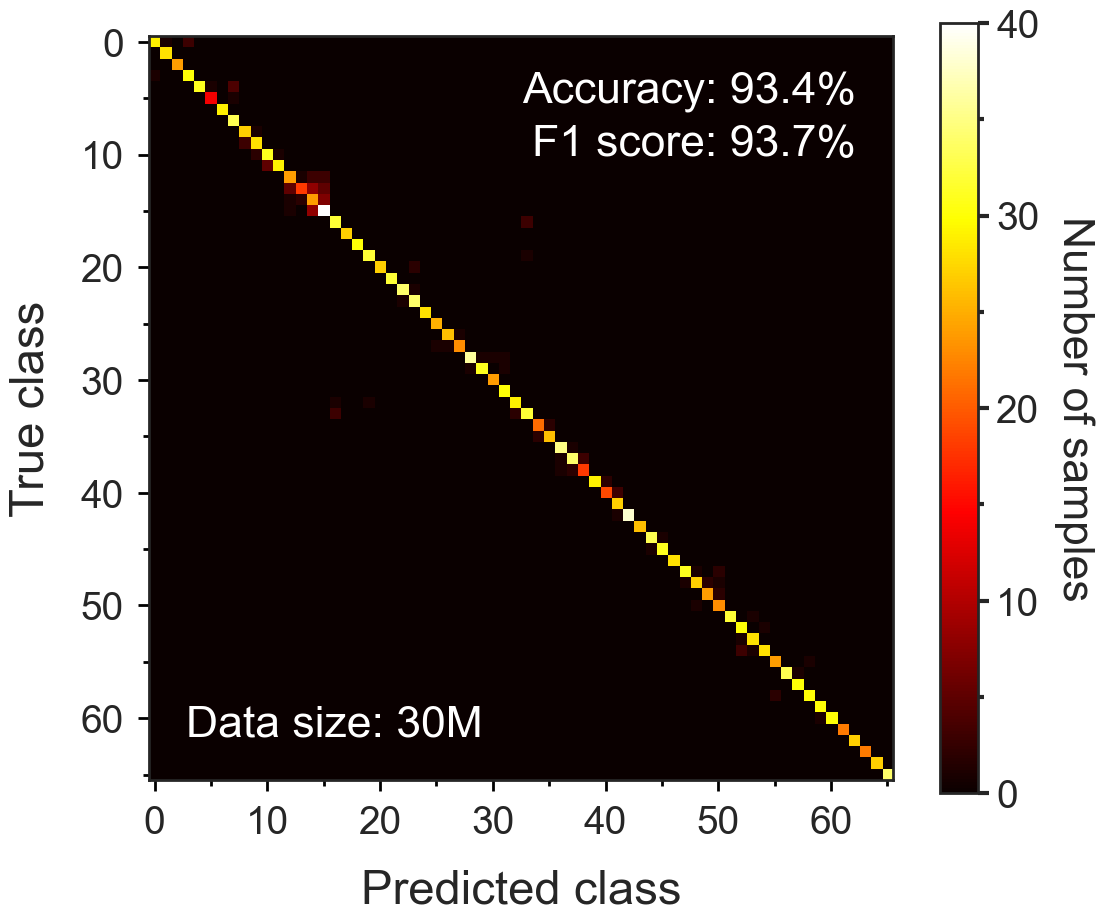

In [5]:
visual_embedding_dim = 50
prompt_type_list = ['full']

with open(os.path.join(cif_folder, 'test_dataset_1phase_orientation.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
    
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, y_pred_full = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

        outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
        logits = outputs.logits
        y_true.append(np.array(labels).argmax(-1)[0])
        y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
        y_pred_full.append(np.array(logits.detach().cpu()[0]))
        y_formula.append(formula_list[i])

        print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])

    y_pred_full = np.array(y_pred_full)

    report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
    matrix = confusion_matrix(y_true, y_pred)

    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(matrix, cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
    ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    plt.text(0.95, 0.84, 'F1 score: {:.1f}%'.format(report['macro avg']['f1-score']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    if sample_size%1000000 == 0:
        data_size = str(int(sample_size//1000000))+'M'
    elif sample_size%1000 == 0:
        data_size = str(int(sample_size//1000))+'k'
    else:
        data_size = int(sample_size)
    plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

## 2.2  Late fusion

Here we need to use Chem-XRD without any elemental inputs. To train the model, go to train.py Section 2.1, set  prompt_type_list = [None], change the model_folder to another name such as 'single_phase_no_elemental', and run the training. Or use the pretrained model we provided.

In [6]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase_no_elemental','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_no_fusion')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


In [7]:
Chem_elements = []
Chem_samples = []

for i, sample in enumerate(dataloader.sample_list):
    elements = set(dataloader.dataset[sample]['element_list'])
    for j, Chem_element in enumerate(Chem_elements):
        if elements.issubset(Chem_element):
            Chem_samples[j][i] += 1
    if elements not in Chem_elements:
        Chem_elements.append(elements)
        Chem_samples_onehot = np.zeros((66))
        Chem_samples_onehot[i] += 1
        Chem_samples.append(Chem_samples_onehot)

for i, (x,y) in enumerate(zip(Chem_elements,Chem_samples)):
    print(x,y)

Chem_prob = []
for element in element_list:
    Chem_prob.append(Chem_samples[Chem_elements.index(set(element))])

Chem_prob = np.array(Chem_prob)

{'Br', 'Pb', 'FA', 'Cs'} [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
{'Pb', 'FA', 'Cs', 'I'} [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
{'Br', 'Pb', 'MA', 'Cs'} [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
{'Pb', 'MA', 'Cs', 'I'} [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
{'Br', 'Pb', 'Cs'} [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0

[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['alpha-FAPbI3'] 44 44
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Cs0.2FA0.8PbI3'] 4 36
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6MA0.4PbBr3'] 10 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.6MA0.4PbBr3'] 10 9
[''] ['Cs0.2MA0.8PbI3'] 12 13
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['delta

[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['CsBr'] 17 17
[''] ['gamma-CsPbI3'] 38 38
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['CsI'] 18 18
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-CsPbBr3'] 32 16
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['beta-FAPbI3'] 45 45
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-MAPbBr3'] 59 59
[''] ['PbBr2'] 64 64
[''] ['Cs4PbBr6'] 16 16
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['delta-FAPbI3'] 46 46
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['CsBr'] 17 17
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['Cs4PbBr6'] 16 16

[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4MA0.6PbI3'] 13 15
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['FAPb(Br0.2I0.8)3'] 39 43
[''] ['alpha-FAPbI3'] 44 44
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsBr'] 17 17
[''] ['MA0.2FA0.8PbBr3'] 47 50
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.2FA0.8PbBr3'] 0 32
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['cubic-FAPbBr3'] 43 43
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['delta-FAPbI3'] 46 46
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['beta-FAPbI3'] 45 45
[''] ['Cs0.6MA0.4PbBr3'] 10 59
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['Cs4PbBr6'] 16 16
[''] ['MA0.8FA0.2PbI3'] 

[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['Cs0.2MA0.8PbI3'] 12 65
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['PbI2'] 65 65
[''] ['alpha-MAPbI3'] 62 62
[''] ['cubic-CsPbBr3'] 32 32
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['Cs0.6FA0.4PbI3'] 6 5
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['Cs0.8MA0.2PbI3'] 15 62
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['cubic-CsPbBr3'] 32 32
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['alpha-FAPbI3'] 44 44
[''] ['alpha-MAPbI3'] 62 62
[''] ['Cs0.2FA0.8PbI3'] 4 7
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['Cs0.6MA0.4PbI3'] 14 65
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['MA0.4FA0.

[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['PbI2'] 65 65
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['alpha-FAPbI3'] 44 44
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['CsPb2Br5'] 19 19
[''] ['CsI'] 18 18
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['beta-FAPbI3'] 45 45
[''] ['delta-FAPbI3'] 46 46
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['cubic-MAPbBr3'] 59 59
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb2Br5'] 19 19
[''] ['CsI'] 18 18
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['delta-CsPbI3'] 37 37
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['Cs4PbBr6'] 16 16
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['CsPb(I0

[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs4PbBr6'] 16 16
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['cubic-CsPbBr3'] 32 32
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['FAPb(Br0.4I0.6)3'] 40 43
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['Cs0.2MA0.8PbI3'] 12 15
[''] ['Cs0.2FA0.8PbBr3'] 0 1
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['CsPb(I0.4Br0.6)3'] 25 37
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['cubic-CsPbBr3'] 32 32
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['delta-FAPbI3'] 46 46
[''] ['Cs0.2FA0.8PbBr3

[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['CsI'] 18 18
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['cubic-CsPbBr3'] 32 32
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['FAPb(Br0.6I0.4)3'] 41 45
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['alpha-FAPbI3'] 44 44
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['delta-CsPbI3'] 37 37
[''] ['PbI2'] 65 65
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['cubic-CsPbCl3'] 35 35
[''] ['beta-FAPbI3'] 45 45
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.2MA0.8PbI3'] 12 14
[''] ['beta-FAPbI3'] 45 45
[''] ['PbBr2'] 64 64
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['beta-FAPbI3'] 45 45
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['CsBr'] 17 17
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['CsPb(Cl0.4Br0.6)

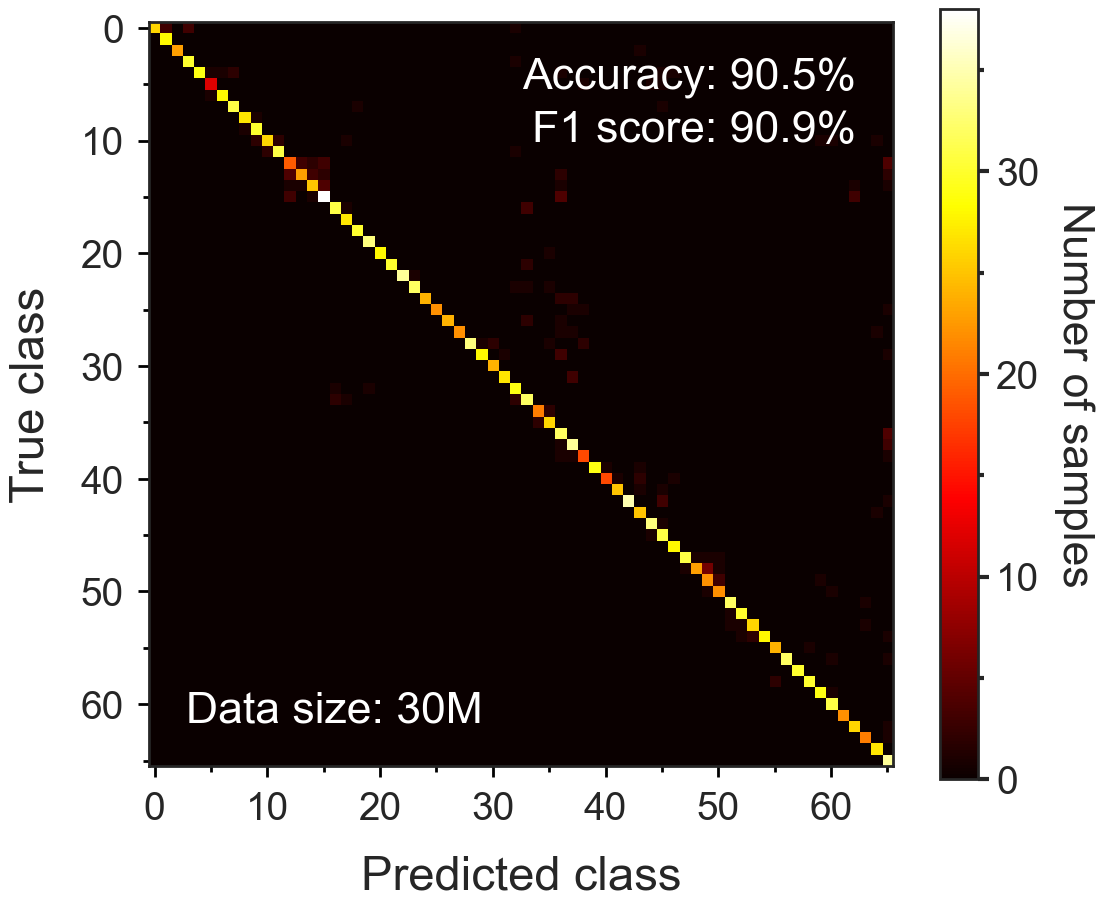

In [8]:
prompt_type_list = [None]

for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, y_pred_full = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

        outputs = model(**inputs.to('cuda'), output_attentions=False, labels=labels.to('cuda'))
        logits = outputs.logits

        try:
            Ys_pred_full = np.array(logits.detach().cpu())*Chem_prob[i:i+1]
            Ys_pred_full[Ys_pred_full == 0] = 'nan'
            Ys_pred = np.nanargmax(Ys_pred_full,axis=1)
        except:
            Ys_pred_full = np.array(logits.detach().cpu()+0.000001)*Chem_prob[i:i+1]
            Ys_pred_full[Ys_pred_full == 0] = 'nan'
            Ys_pred = np.nanargmax(Ys_pred_full,axis=1)

        y_true.append(np.array(labels).argmax(-1)[0])
        y_pred.append(Ys_pred)
        y_pred_full.append(Ys_pred_full)
        y_formula.append(formula_list[i])

        print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1][0])

    y_pred_full = np.array(y_pred_full)

    report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
    matrix = confusion_matrix(y_true, y_pred)

    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(matrix, cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
    ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    plt.text(0.95, 0.84, 'F1 score: {:.1f}%'.format(report['macro avg']['f1-score']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    if sample_size%1000000 == 0:
        data_size = str(int(sample_size//1000000))+'M'
    elif sample_size%1000 == 0:
        data_size = str(int(sample_size//1000))+'k'
    else:
        data_size = int(sample_size)
    plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

## 2.3 No fusion

In [9]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase_no_elemental','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_no_fusion')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['alpha-FAPbI3'] 44 44
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 32
[''] ['Cs0.2FA0.8PbI3'] 4 53
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6MA0.4PbBr3'] 10 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.6MA0.4PbI3'] 14 43
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.6MA0.4PbBr3'] 10 9
[''] ['Cs0.2MA0.8PbI3'] 12 13
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['delta

[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['PbBr2'] 64 64
[''] ['FAPb(Br0.8I0.2)3'] 42 50
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Br0.4)3'] 26 58
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['CsPb(Cl0.2Br0.8)3'] 20 26
[''] ['CsBr'] 17 17
[''] ['gamma-CsPbI3'] 38 1
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['CsI'] 18 30
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-CsPbBr3'] 32 14
[''] ['Cs0.8MA0.2PbI3'] 15 56
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['beta-FAPbI3'] 45 45
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-MAPbBr3'] 59 59
[''] ['PbBr2'] 64 64
[''] ['Cs4PbBr6'] 16 36
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['delta-FAPbI3'] 46 46
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.8MA0.2PbI3'

[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['tetragonal-MAPbI3'] 63 2
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.2MA0.8PbBr3'] 8 2
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['CsPb2Br5'] 19 19
[''] ['CsBr'] 17 17
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4MA0.6PbI3'] 13 59
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['FAPb(Br0.2I0.8)3'] 39 14
[''] ['alpha-FAPbI3'] 44 44
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 56
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsBr'] 17 17
[''] ['MA0.2FA0.8PbBr3'] 47 50
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['cubic-MAPbBr3'] 59 51
[''] ['Cs0.2FA0.8PbBr3'] 0 59
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.4MA0.6PbI3'] 13 58
[''] ['cubic-FAPbBr3'] 43 43
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['delta-FAPbI3'] 46 46
['

[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['orthorhombic-CsPbBr3'] 33 47
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['PbI2'] 65 65
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.2MA0.8PbBr3'] 8 2
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['Cs0.6MA0.4PbI3'] 14 56
[''] ['Cs0.2MA0.8PbI3'] 12 50
[''] ['CsPb(I0.8Cl0.2)3'] 31 32
[''] ['PbI2'] 65 65
[''] ['alpha-MAPbI3'] 62 62
[''] ['cubic-CsPbBr3'] 32 32
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['Cs0.6FA0.4PbI3'] 6 30
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['FAPb(Br0.2I0.8)3'] 39 55
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] 

[''] ['CsPb(Cl0.4Br0.6)3'] 21 47
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['cubic-FAPbBr3'] 43 43
[''] ['PbI2'] 65 65
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['Cs0.2FA0.8PbBr3'] 0 1
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['MA0.2FA0.8PbI3'] 51 1
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb(I0.2Br0.8)3'] 24 36
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['CsBr'] 17 17
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.2FA0.8PbBr3'] 47 36
[''] ['PbI2'] 65 65
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['alpha-FAPbI3'] 44 51
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['CsPb2Br5'] 19 19
[''] ['CsI'] 18 37
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.8FA0.2PbBr3'] 3 10
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['beta-FAPbI3'] 45 45
[''] ['delta-FAPbI3'] 46 46
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.4Cl0.6)3'] 29 9
[''] ['cubic-MAPbBr3'] 59 59
[''] ['alpha-CsPbI3'] 36 3

[''] ['CsPb(I0.6Cl0.4)3'] 30 2
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs4PbBr6'] 16 16
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['PbBr2'] 64 64
[''] ['PbI2'] 65 65
[''] ['cubic-CsPbCl3'] 35 35
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['gamma-CsPbI3'] 38 38
[''] ['CsBr'] 17 17
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs4PbBr6'] 16 47
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['cubic-CsPbBr3'] 32 32
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.8FA0.2PbI3'] 7 30
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['CsPb(Cl0.4Br0.6)3'] 21 47
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['FAPb(Br0.4I0.6)3'] 40 47
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['Cs0.2MA0.8PbI3'] 12 47
[''] ['Cs0.2FA0.8PbBr3'] 0 1
[''] ['orthorhombic-CsPbBr3'] 33 33


[''] ['cubic-MAPbBr3'] 59 1
[''] ['CsPb2Br5'] 19 19
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['Cs0.4MA0.6PbI3'] 13 59
[''] ['CsI'] 18 58
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['cubic-CsPbCl3'] 35 36
[''] ['Cs4PbBr6'] 16 16
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.6FA0.4PbI3'] 53 43
[''] ['Cs0.6FA0.4PbBr3'] 2 58
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['Cs0.8MA0.2PbI3'] 15 12
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['CsI'] 18 18
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['cubic-CsPbBr3'] 32 32
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 47
[''] ['FAPb(Br0.6I0.4)3'] 41 1
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.8FA0.2PbBr3'] 50 24
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['M

[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.8FA0.2PbI3'] 54 49
[''] ['CsPb(I0.6Br0.4)3'] 26 14
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['MA0.8FA0.2PbI3'] 54 49
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['cubic-CsPbCl3'] 35 60
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['Cs0.8FA0.2PbI3'] 7 7


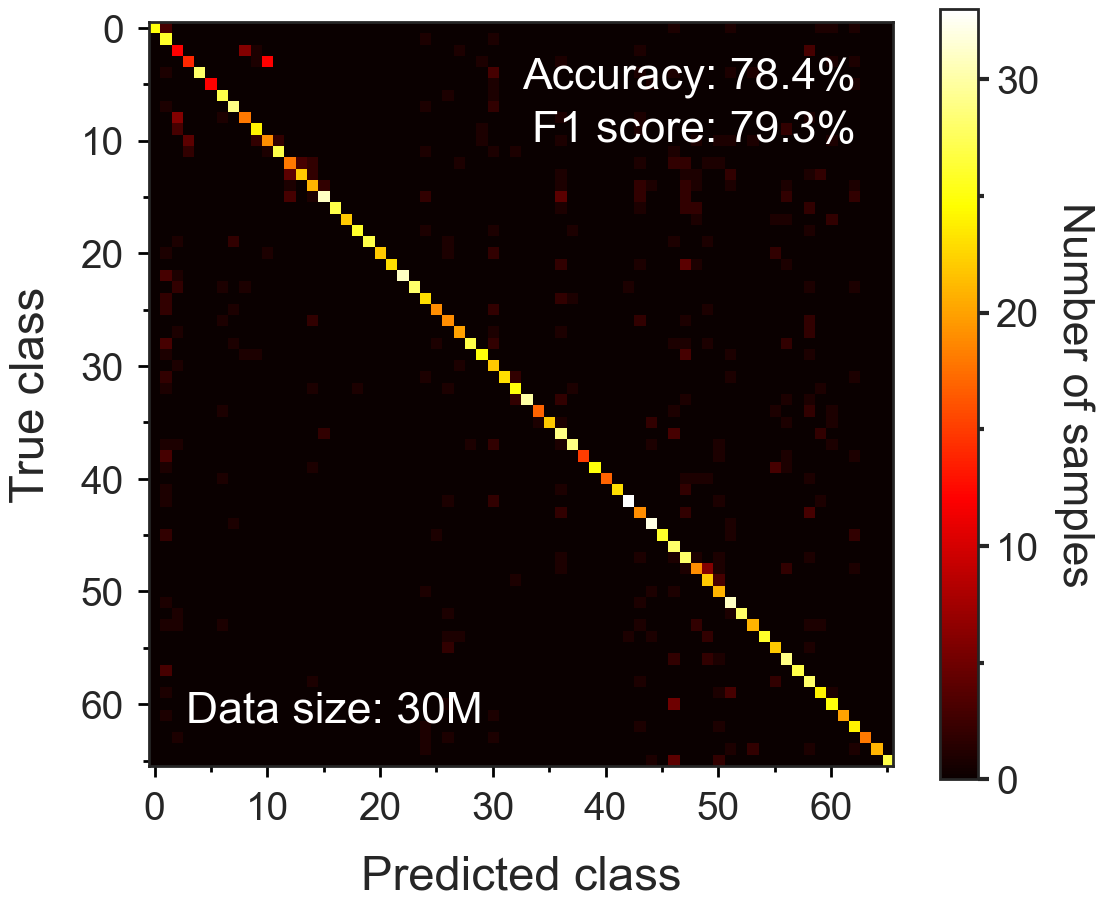

In [10]:
visual_embedding_dim = 50
prompt_type_list = [None]

with open(os.path.join(cif_folder, 'test_dataset_1phase_orientation.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
    
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, y_pred_full = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

        outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
        logits = outputs.logits
        y_true.append(np.array(labels).argmax(-1)[0])
        y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
        y_pred_full.append(np.array(logits.detach().cpu()[0]))
        y_formula.append(formula_list[i])

        print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])

    y_pred_full = np.array(y_pred_full)

    report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
    matrix = confusion_matrix(y_true, y_pred)

    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(matrix, cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
    ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    plt.text(0.95, 0.84, 'F1 score: {:.1f}%'.format(report['macro avg']['f1-score']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    if sample_size%1000000 == 0:
        data_size = str(int(sample_size//1000000))+'M'
    elif sample_size%1000 == 0:
        data_size = str(int(sample_size//1000))+'k'
    else:
        data_size = int(sample_size)
    plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

# 3 Multi phase classification

In [11]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'multi_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'multi_phase')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


In [12]:
full_result = {}
prompt_type_list = ['none','eds','full']
n_mix = [1,2,3]
random_phase = True

for prompt_type in prompt_type_list:
    full_result[prompt_type] = {}
    if random_phase:
        for n in n_mix:
            full_result[prompt_type]['{}'.format(n)] = {'y_true':[], 'y_pred':[], 'y_acc':[], 'n_true':[], 'n_pred':[], 'n_acc':[]}
    else:
        for n in n_mix:
            full_result[prompt_type]['{}'.format(n)] = {'y_true':[], 'y_pred':[], 'y_acc':[]}

In [13]:
for n in n_mix:
    
    file_name = 'test_dataset_{}phase_orientation.npy'.format(n)
    
    try:
        with open(os.path.join(cif_folder, file_name), 'rb') as handle:
            test_dataset = joblib.load(handle)

        Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
        print('test dataset loaded.')

    except:
        Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=2000, n_mix=[n], resonable_mixing=True,
                                                                  high_orientation_probability=0.2, crystal_size_range=(5, 20), 
                                                                  intensity_variation_range=(0.01, 1))
        test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

        with open(os.path.join(cif_folder, file_name), 'wb') as handle:
            joblib.dump(test_dataset, handle)
        print('test dataset generated.')

    print(np.sum(Ys,axis=0))

    if random_phase:
        n_mix_list_onehot = np.zeros((Ys.shape[0], len(n_mix)))
        n_mix_list_onehot[np.arange(Ys.shape[0]), n_mix.index(n)] = 1
        Ys = np.concatenate((Ys,n_mix_list_onehot),axis=1)

    for prompt_type in prompt_type_list:

        for i in range(len(element_list)):

            Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

            X_prompts = []
            random.shuffle(element_list[i])
            if prompt_type == 'none':
                X_prompts.append('')
            elif prompt_type == 'eds':
                X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
            elif prompt_type == 'full':
                X_prompts.append(' '.join(element_list[i]))

            visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
            visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

            inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
            inputs.update(
                {
                    "visual_embeds": visual_embeds,
                    "visual_token_type_ids": visual_token_type_ids,
                    "visual_attention_mask": visual_attention_mask,
                }
            )

            labels = torch.from_numpy(Ys[i:i+1]).to(dtype=torch.float32)
            outputs = model(**inputs.to('cuda'), output_attentions=True)
            
            if random_phase:
                y_true = np.array(Ys[i:i+1])[0,:-len(n_mix)]
                y_pred = np.array(outputs.logits.detach().cpu())[0,:-len(n_mix)]
                n_true = np.array(Ys[i:i+1])[0,-len(n_mix):]
                n_pred = np.array(outputs.logits.detach().cpu())[0,-len(n_mix):]
                n_true_idx = np.where(n_true!=0)[0]
                n_pred_idx = np.argpartition(n_pred,-1)[-1:]
                
                if set(list(n_true_idx)) == set(list(n_pred_idx)):
                    full_result[prompt_type]['{}'.format(n)]['n_acc'].append(0)
                else:
                    full_result[prompt_type]['{}'.format(n)]['n_acc'].append(1)
                    
                full_result[prompt_type]['{}'.format(n)]['n_true'].append(n_true)
                full_result[prompt_type]['{}'.format(n)]['n_pred'].append(n_pred)
            else:
                y_true = np.array(Ys[i:i+1])[0]
                y_pred = np.array(outputs.logits.detach().cpu())[0]
            
            y_true_idx = np.where(y_true!=0)[0]
            y_pred_idx = np.argpartition(y_pred,-n)[-n:]
            
            if set(list(y_true_idx)) == set(list(y_pred_idx)):
                full_result[prompt_type]['{}'.format(n)]['y_acc'].append(0)
            else:
                full_result[prompt_type]['{}'.format(n)]['y_acc'].append(1)
                
            full_result[prompt_type]['{}'.format(n)]['y_true'].append(y_true)
            full_result[prompt_type]['{}'.format(n)]['y_pred'].append(y_pred)
            
            if random_phase:
                print(i,formula_list[i],y_true_idx,y_pred_idx,n_true_idx,n_pred_idx)
            else:
                print(i,formula_list[i],y_true_idx,y_pred_idx)

test dataset loaded.
[33. 28. 24. 31. 36. 15. 29. 33. 28. 31. 34. 34. 31. 36. 34. 49. 35. 27.
 30. 33. 29. 32. 35. 35. 28. 25. 27. 25. 39. 33. 24. 30. 31. 37. 23. 28.
 36. 38. 21. 31. 22. 27. 39. 26. 34. 32. 28. 34. 31. 26. 24. 33. 31. 29.
 32. 25. 34. 30. 32. 30. 31. 22. 27. 22. 27. 34.]
0 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
2 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
3 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
4 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
5 ['alpha-FAPbI3'] [44] [44] [0] [1]
6 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
7 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
8 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
9 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
10 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
11 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
12 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
13 ['CsPb(I0.8Cl0.2)3'] [31] [15] [0] [0]
14 ['Cs0.2FA0.8PbI3'] [4] [15] [0] [0]
15 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
16 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
17 ['Cs0.2FA0.8

209 ['alpha-FAPbI3'] [44] [20] [0] [0]
210 ['cubic-MAPbBr3'] [59] [59] [0] [0]
211 ['cubic-CsPbCl3'] [35] [35] [0] [0]
212 ['CsPb(I0.2Cl0.8)3'] [28] [56] [0] [0]
213 ['CsPb(Cl0.8Br0.2)3'] [23] [55] [0] [0]
214 ['Cs0.8FA0.2PbBr3'] [3] [11] [0] [0]
215 ['alpha-MAPbI3'] [62] [62] [0] [1]
216 ['alpha-FAPbI3'] [44] [44] [0] [0]
217 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
218 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
219 ['Cs0.8FA0.2PbBr3'] [3] [29] [0] [0]
220 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
221 ['Cs4PbBr6'] [16] [56] [0] [0]
222 ['gamma-CsPbI3'] [38] [38] [0] [0]
223 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
224 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
225 ['CsPb2Br5'] [19] [19] [0] [0]
226 ['gamma-CsPbI3'] [38] [21] [0] [0]
227 ['cubic-FAPbBr3'] [43] [58] [0] [1]
228 ['MA0.2FA0.8PbBr3'] [47] [58] [0] [0]
229 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
230 ['Cs0.8MA0.2PbBr3'] [11] [32] [0] [0]
231 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [1]
232 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [1]
233 ['Cs0.8FA0.2PbI3'] [7] [

415 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
416 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
417 ['Cs0.4MA0.6PbI3'] [13] [14] [0] [1]
418 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
419 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
420 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
421 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
422 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
423 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
424 ['MA0.4FA0.6PbBr3'] [48] [50] [0] [0]
425 ['alpha-FAPbI3'] [44] [44] [0] [1]
426 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
427 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
428 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
429 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
430 ['PbBr2'] [64] [36] [0] [0]
431 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
432 ['FAPb(Br0.2I0.8)3'] [39] [23] [0] [0]
433 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
434 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
435 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
436 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
437 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
438 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]


619 ['orthorhombic-CsPbBr3'] [33] [41] [0] [0]
620 ['PbBr2'] [64] [64] [0] [0]
621 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
622 ['Cs4PbBr6'] [16] [16] [0] [0]
623 ['cubic-FAPbBr3'] [43] [58] [0] [0]
624 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
625 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
626 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
627 ['cubic-MAPbBr3'] [59] [59] [0] [0]
628 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
629 ['CsPb2Br5'] [19] [19] [0] [0]
630 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
631 ['cubic-MAPbBr3'] [59] [59] [0] [0]
632 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
633 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
634 ['delta-CsPbI3'] [37] [37] [0] [0]
635 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
636 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [1]
637 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
638 ['beta-FAPbI3'] [45] [45] [0] [0]
639 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
640 ['MA0.4FA0.6PbBr3'] [48] [40] [0] [0]
641 ['beta-FAPbI3'] [45] [45] [0] [0]
642 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
643 ['cubic-FAPbBr3'] [43] [43] [

823 ['alpha-MAPbI3'] [62] [39] [0] [0]
824 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
825 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
826 ['alpha-MAPbI3'] [62] [62] [0] [0]
827 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
828 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
829 ['CsPb(I0.8Br0.2)3'] [27] [58] [0] [0]
830 ['CsPb(I0.4Br0.6)3'] [25] [46] [0] [0]
831 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
832 ['alpha-CsPbI3'] [36] [51] [0] [0]
833 ['alpha-CsPbI3'] [36] [36] [0] [1]
834 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
835 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
836 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
837 ['alpha-MAPbI3'] [62] [62] [0] [1]
838 ['alpha-CsPbI3'] [36] [14] [0] [0]
839 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
840 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [1]
841 ['gamma-CsPbI3'] [38] [38] [0] [0]
842 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
843 ['Cs0.8MA0.2PbI3'] [15] [13] [0] [0]
844 ['beta-FAPbI3'] [45] [45] [0] [0]
845 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
846 ['delta-CsPbI3'] [37] [37] [0] [0]
847 ['MAPb(B

1023 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
1024 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1025 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1026 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1027 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1028 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
1029 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1030 ['MAPb(Br0.4I0.6)3'] [56] [21] [0] [0]
1031 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1032 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
1033 ['CsPb(I0.2Cl0.8)3'] [28] [22] [0] [0]
1034 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [1]
1035 ['Cs0.2MA0.8PbBr3'] [8] [2] [0] [1]
1036 ['CsBr'] [17] [17] [0] [0]
1037 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1038 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1039 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1040 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
1041 ['PbI2'] [65] [44] [0] [0]
1042 ['beta-FAPbI3'] [45] [45] [0] [0]
1043 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1044 ['delta-CsPbI3'] [37] [37] [0] [0]
1045 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1046 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [

1238 ['Cs0.8FA0.2PbI3'] [7] [18] [0] [0]
1239 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1240 ['CsPb2Br5'] [19] [19] [0] [0]
1241 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [1]
1242 ['MA0.4FA0.6PbBr3'] [48] [56] [0] [0]
1243 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1244 ['delta-CsPbI3'] [37] [7] [0] [0]
1245 ['Cs0.2MA0.8PbI3'] [12] [23] [0] [0]
1246 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1247 ['Cs0.2MA0.8PbI3'] [12] [13] [0] [0]
1248 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1249 ['Cs0.2MA0.8PbI3'] [12] [43] [0] [0]
1250 ['CsI'] [18] [18] [0] [0]
1251 ['PbI2'] [65] [65] [0] [0]
1252 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1253 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1254 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1255 ['CsPb(I0.6Cl0.4)3'] [30] [23] [0] [0]
1256 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1257 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1258 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1259 ['alpha-FAPbI3'] [44] [44] [0] [0]
1260 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1261 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1262 ['Cs

1439 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1440 ['Cs0.8FA0.2PbI3'] [7] [20] [0] [0]
1441 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1442 ['Cs0.6MA0.4PbBr3'] [10] [3] [0] [1]
1443 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [1]
1444 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1445 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1446 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1447 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1448 ['FAPb(Br0.4I0.6)3'] [40] [41] [0] [0]
1449 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1450 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1451 ['Cs0.2MA0.8PbI3'] [12] [41] [0] [0]
1452 ['Cs0.2FA0.8PbBr3'] [0] [41] [0] [0]
1453 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1454 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1455 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [1]
1456 ['CsPb(I0.4Br0.6)3'] [25] [7] [0] [0]
1457 ['Cs0.6MA0.4PbBr3'] [10] [29] [0] [0]
1458 ['MAPb(Br0.4I0.6)3'] [56] [46] [0] [0]
1459 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1460 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
1461 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1462 ['Cs

1648 ['alpha-MAPbI3'] [62] [62] [0] [0]
1649 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1650 ['delta-CsPbI3'] [37] [37] [0] [0]
1651 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1652 ['tetragonal-MAPbI3'] [63] [20] [0] [0]
1653 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1654 ['Cs0.2MA0.8PbBr3'] [8] [23] [0] [0]
1655 ['CsBr'] [17] [17] [0] [0]
1656 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1657 ['alpha-FAPbI3'] [44] [44] [0] [1]
1658 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1659 ['Cs0.8FA0.2PbBr3'] [3] [56] [0] [0]
1660 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1661 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1662 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1663 ['Cs0.6MA0.4PbBr3'] [10] [50] [0] [0]
1664 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1665 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1666 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1667 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1668 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1669 ['Cs4PbBr6'] [16] [16] [0] [0]
1670 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1671 ['CsPb(Cl0.2Br0.8)3'] [20] [2

1858 ['CsPb(Cl0.6Br0.4)3'] [22] [18] [0] [0]
1859 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1860 ['gamma-CsPbI3'] [38] [44] [0] [0]
1861 ['Cs0.6MA0.4PbI3'] [14] [14] [0] [0]
1862 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1863 ['Cs0.6MA0.4PbBr3'] [10] [29] [0] [0]
1864 ['Pnma-CsPbCl3'] [34] [58] [0] [0]
1865 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1866 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1867 ['delta-FAPbI3'] [46] [46] [0] [0]
1868 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [1]
1869 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1870 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1871 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1872 ['Cs0.2MA0.8PbBr3'] [8] [2] [0] [0]
1873 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1874 ['gamma-CsPbI3'] [38] [38] [0] [0]
1875 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [1]
1876 ['Cs0.8MA0.2PbI3'] [15] [36] [0] [0]
1877 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1878 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1879 ['gamma-CsPbI3'] [38] [38] [0] [0]
1880 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
1881 ['cubic-CsPbC

70 ['Cs4PbBr6'] [16] [16] [0] [0]
71 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
72 ['CsPb2Br5'] [19] [19] [0] [0]
73 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
74 ['delta-CsPbI3'] [37] [37] [0] [0]
75 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
76 ['PbBr2'] [64] [64] [0] [0]
77 ['cubic-FAPbBr3'] [43] [43] [0] [0]
78 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
79 ['delta-CsPbI3'] [37] [37] [0] [0]
80 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
81 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
82 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
83 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
84 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
85 ['Cs0.2MA0.8PbBr3'] [8] [33] [0] [0]
86 ['Cs0.4MA0.6PbBr3'] [9] [3] [0] [0]
87 ['Cs0.8MA0.2PbI3'] [15] [13] [0] [0]
88 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
89 ['CsPb(I0.2Cl0.8)3'] [28] [29] [0] [0]
90 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
91 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
92 ['alpha-CsPbI3'] [36] [36] [0] [0]
93 ['alpha-FAPbI3'] [44] [44] [0] [0]
94 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
95 ['CsPb(I0.4Cl0

285 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
286 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
287 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
288 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
289 ['CsPb(I0.2Cl0.8)3'] [28] [29] [0] [0]
290 ['CsPb2Br5'] [19] [19] [0] [0]
291 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
292 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
293 ['PbBr2'] [64] [64] [0] [0]
294 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
295 ['CsI'] [18] [18] [0] [0]
296 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
297 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
298 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
299 ['CsBr'] [17] [17] [0] [0]
300 ['gamma-CsPbI3'] [38] [38] [0] [0]
301 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
302 ['CsI'] [18] [18] [0] [0]
303 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
304 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
305 ['Cs0.2MA0.8PbI3'] [12] [13] [0] [0]
306 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
307 ['Cs4PbBr6'] [16] [16] [0] [0]
308 ['cubic-CsPbBr3'] [32] [33] [0] [0]
309 ['Cs0.8MA0.2PbI3'] [15] [36] [0] [0]
310 ['CsPb(Cl

487 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
488 ['Cs0.6MA0.4PbI3'] [14] [36] [0] [0]
489 ['cubic-CsPbBr3'] [32] [32] [0] [0]
490 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
491 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
492 ['delta-CsPbI3'] [37] [37] [0] [0]
493 ['beta-FAPbI3'] [45] [62] [0] [0]
494 ['delta-FAPbI3'] [46] [46] [0] [0]
495 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
496 ['gamma-CsPbI3'] [38] [38] [0] [0]
497 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
498 ['CsPb(I0.2Br0.8)3'] [24] [25] [0] [0]
499 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
500 ['CsI'] [18] [18] [0] [0]
501 ['PbBr2'] [64] [64] [0] [0]
502 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
503 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
504 ['CsI'] [18] [18] [0] [0]
505 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
506 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
507 ['CsPb(I0.8Br0.2)3'] [27] [26] [0] [0]
508 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
509 ['cubic-MAPbBr3'] [59] [59] [0] [0]
510 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
511 ['delta-FAPbI3'] [46] [46] [0] [0]


695 ['alpha-CsPbI3'] [36] [36] [0] [0]
696 ['MA0.4FA0.6PbI3'] [52] [44] [0] [0]
697 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
698 ['gamma-CsPbI3'] [38] [38] [0] [0]
699 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
700 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
701 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
702 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
703 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
704 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
705 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
706 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
707 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
708 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
709 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
710 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
711 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
712 ['cubic-MAPbBr3'] [59] [59] [0] [0]
713 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
714 ['Cs4PbBr6'] [16] [16] [0] [0]
715 ['Cs4PbBr6'] [16] [33] [0] [0]
716 ['Cs0.2FA0.8PbBr3'] [0] [19] [0] [0]
717 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
718 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
719 ['alpha-Cs

911 ['Cs0.4MA0.6PbI3'] [13] [15] [0] [0]
912 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
913 ['alpha-MAPbI3'] [62] [62] [0] [0]
914 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
915 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
916 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
917 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
918 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
919 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
920 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
921 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
922 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
923 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
924 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
925 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
926 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
927 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
928 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
929 ['tetragonal-MAPbBr3'] [60] [50] [0] [0]
930 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
931 ['CsI'] [18] [18] [0] [0]
932 ['Cs0.8MA0.2PbBr3'] [11] [3] [0] [0]
933 ['cubic-MAPbBr3'] [59] [59] [0] [0]
934 ['cubic-CsPbCl3'] [35] [35] [0] [0]
935 ['MA0.2FA0.

1116 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
1117 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1118 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
1119 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1120 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1121 ['Cs0.6MA0.4PbI3'] [14] [38] [0] [0]
1122 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1123 ['delta-FAPbI3'] [46] [46] [0] [0]
1124 ['CsI'] [18] [18] [0] [0]
1125 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1126 ['delta-FAPbI3'] [46] [46] [0] [0]
1127 ['Cs0.4MA0.6PbI3'] [13] [12] [0] [0]
1128 ['alpha-CsPbI3'] [36] [36] [0] [0]
1129 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1130 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1131 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1132 ['PbI2'] [65] [65] [0] [0]
1133 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1134 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1135 ['Cs0.2FA0.8PbBr3'] [0] [32] [0] [0]
1136 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
1137 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1138 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1139 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
1140

1324 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1325 ['orthorhombic-CsPbBr3'] [33] [32] [0] [0]
1326 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
1327 ['alpha-FAPbI3'] [44] [44] [0] [0]
1328 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1329 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1330 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
1331 ['Cs0.8FA0.2PbI3'] [7] [38] [0] [0]
1332 ['CsPb2Br5'] [19] [19] [0] [0]
1333 ['Cs0.8FA0.2PbBr3'] [3] [10] [0] [0]
1334 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
1335 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1336 ['Cs0.4MA0.6PbBr3'] [9] [2] [0] [0]
1337 ['delta-FAPbI3'] [46] [46] [0] [0]
1338 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1339 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1340 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1341 ['Cs0.8MA0.2PbBr3'] [11] [10] [0] [0]
1342 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1343 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1344 ['gamma-CsPbI3'] [38] [38] [0] [0]
1345 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1346 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1347 ['Pnma-CsPbCl3'] [34] 

1534 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1535 ['Cs0.6FA0.4PbBr3'] [2] [9] [0] [0]
1536 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1537 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1538 ['Cs4PbBr6'] [16] [16] [0] [0]
1539 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1540 ['Cs4PbBr6'] [16] [16] [0] [0]
1541 ['delta-CsPbI3'] [37] [38] [0] [0]
1542 ['alpha-CsPbI3'] [36] [38] [0] [0]
1543 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
1544 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1545 ['Cs4PbBr6'] [16] [16] [0] [0]
1546 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1547 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1548 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1549 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1550 ['tetragonal-MAPbBr3'] [60] [50] [0] [0]
1551 ['Cs0.6MA0.4PbI3'] [14] [12] [0] [0]
1552 ['CsI'] [18] [18] [0] [0]
1553 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
1554 ['cubic-FAPbBr3'] [43] [64] [0] [0]
1555 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1556 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1557 ['alpha-CsPbI3'] [36] [38] [0] [0]
1558

1746 ['PbBr2'] [64] [64] [0] [0]
1747 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1748 ['beta-FAPbI3'] [45] [45] [0] [0]
1749 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1750 ['CsBr'] [17] [17] [0] [0]
1751 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1752 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1753 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1754 ['Cs0.6MA0.4PbI3'] [14] [36] [0] [0]
1755 ['Cs0.6FA0.4PbBr3'] [2] [33] [0] [0]
1756 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1757 ['Cs0.8MA0.2PbI3'] [15] [36] [0] [0]
1758 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1759 ['alpha-CsPbI3'] [36] [38] [0] [0]
1760 ['CsPb2Br5'] [19] [19] [0] [0]
1761 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1762 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1763 ['PbBr2'] [64] [64] [0] [0]
1764 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1765 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1766 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1767 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1768 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1769 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1770 ['delta-FAP

1950 ['cubic-MAPbBr3'] [59] [50] [0] [0]
1951 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1952 ['PbBr2'] [64] [64] [0] [0]
1953 ['Cs4PbBr6'] [16] [16] [0] [0]
1954 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1955 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
1956 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1957 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1958 ['CsPb(I0.8Cl0.2)3'] [31] [28] [0] [0]
1959 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1960 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1961 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1962 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1963 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1964 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1965 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1966 ['beta-FAPbI3'] [45] [45] [0] [0]
1967 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1968 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
1969 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1970 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1971 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1972 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1973 ['tetragonal-MAPbI3'] [63] [63] [0] 

166 ['Cs0.2MA0.8PbI3'] [12] [13] [0] [0]
167 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
168 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
169 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
170 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
171 ['Cs0.6MA0.4PbBr3'] [10] [11] [0] [0]
172 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
173 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
174 ['beta-FAPbI3'] [45] [45] [0] [0]
175 ['CsPb2Br5'] [19] [19] [0] [0]
176 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
177 ['CsPb(I0.4Br0.6)3'] [25] [26] [0] [0]
178 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
179 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
180 ['PbBr2'] [64] [64] [0] [0]
181 ['delta-FAPbI3'] [46] [46] [0] [0]
182 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
183 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
184 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
185 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
186 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
187 ['delta-CsPbI3'] [37] [37] [0] [0]
188 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
189 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
190 ['MAPb(Br0.4I0.6)3'] [

381 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
382 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
383 ['PbI2'] [65] [65] [0] [0]
384 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
385 ['CsPb(I0.8Br0.2)3'] [27] [25] [0] [0]
386 ['beta-FAPbI3'] [45] [45] [0] [0]
387 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
388 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
389 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
390 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
391 ['cubic-FAPbBr3'] [43] [43] [0] [0]
392 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
393 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [1]
394 ['PbBr2'] [64] [64] [0] [0]
395 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
396 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
397 ['cubic-CsPbBr3'] [32] [32] [0] [0]
398 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
399 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
400 ['delta-CsPbI3'] [37] [37] [0] [0]
401 ['Cs0.4MA0.6PbBr3'] [9] [8] [0] [0]
402 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
403 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
404 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
405 ['MAPb(Br0.6I0.4)3'] 

593 ['cubic-MAPbBr3'] [59] [59] [0] [0]
594 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
595 ['alpha-CsPbI3'] [36] [38] [0] [0]
596 ['Cs0.4MA0.6PbI3'] [13] [14] [0] [0]
597 ['cubic-FAPbBr3'] [43] [43] [0] [0]
598 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
599 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
600 ['delta-FAPbI3'] [46] [46] [0] [0]
601 ['cubic-MAPbBr3'] [59] [59] [0] [0]
602 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
603 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
604 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
605 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
606 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
607 ['beta-FAPbI3'] [45] [45] [0] [0]
608 ['Cs0.6MA0.4PbBr3'] [10] [11] [0] [0]
609 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
610 ['Cs4PbBr6'] [16] [16] [0] [0]
611 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
612 ['alpha-CsPbI3'] [36] [14] [0] [0]
613 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
614 ['orthorhombic-CsPbBr3'] [33] [32] [0] [0]
615 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
616 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
617 ['PbI2'] [65] [65

800 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
801 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
802 ['CsPb(I0.4Cl0.6)3'] [29] [28] [0] [0]
803 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
804 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
805 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
806 ['alpha-FAPbI3'] [44] [44] [0] [0]
807 ['CsI'] [18] [18] [0] [0]
808 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
809 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
810 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
811 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
812 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
813 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
814 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
815 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
816 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
817 ['alpha-MAPbI3'] [62] [62] [0] [0]
818 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
819 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
820 ['alpha-MAPbI3'] [62] [62] [0] [0]
821 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
822 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
823 ['alpha-MAPbI3'] [62] [62] [0] [0]
824 ['Pnma-CsPbCl3'] [34

1007 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1008 ['Cs0.6MA0.4PbI3'] [14] [14] [0] [0]
1009 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1010 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1011 ['gamma-CsPbI3'] [38] [38] [0] [0]
1012 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1013 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1014 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1015 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1016 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1017 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1018 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1019 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1020 ['MA0.4FA0.6PbBr3'] [48] [49] [0] [0]
1021 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1022 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
1023 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
1024 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1025 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1026 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1027 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1028 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
1029 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1030 ['MAP

1217 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1218 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1219 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [1]
1220 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1221 ['PbI2'] [65] [65] [0] [0]
1222 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1223 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1224 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1225 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1226 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1227 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
1228 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1229 ['PbBr2'] [64] [64] [0] [0]
1230 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1231 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1232 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1233 ['CsBr'] [17] [17] [0] [0]
1234 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1235 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1236 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1237 ['beta-FAPbI3'] [45] [45] [0] [0]
1238 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1239 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1240 ['CsPb2Br5'] [19] [19] [0] [0]
1241 ['CsPb

1431 ['CsBr'] [17] [17] [0] [0]
1432 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1433 ['Cs4PbBr6'] [16] [16] [0] [0]
1434 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1435 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1436 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1437 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1438 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1439 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1440 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1441 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1442 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1443 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
1444 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1445 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1446 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1447 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1448 ['FAPb(Br0.4I0.6)3'] [40] [41] [0] [0]
1449 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1450 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1451 ['Cs0.2MA0.8PbI3'] [12] [14] [0] [0]
1452 ['Cs0.2FA0.8PbBr3'] [0] [1] [0] [0]
1453 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1454 ['FAPb(Br0.2I0.8)3'] [3

1634 ['alpha-FAPbI3'] [44] [44] [0] [0]
1635 ['alpha-CsPbI3'] [36] [36] [0] [1]
1636 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1637 ['delta-CsPbI3'] [37] [6] [0] [0]
1638 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1639 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1640 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1641 ['beta-FAPbI3'] [45] [45] [0] [0]
1642 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1643 ['delta-CsPbI3'] [37] [37] [0] [0]
1644 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1645 ['PbI2'] [65] [46] [0] [0]
1646 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1647 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1648 ['alpha-MAPbI3'] [62] [62] [0] [0]
1649 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1650 ['delta-CsPbI3'] [37] [37] [0] [0]
1651 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1652 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1653 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1654 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
1655 ['CsBr'] [17] [17] [0] [0]
1656 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1657 ['alpha-FAPbI3'] [44] [44] [0] [0]
1658 ['CsPb(

1832 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1833 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1834 ['MA0.8FA0.2PbI3'] [54] [54] [0] [1]
1835 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1836 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1837 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
1838 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1839 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1840 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1841 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1842 ['alpha-FAPbI3'] [44] [44] [0] [0]
1843 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
1844 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
1845 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1846 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1847 ['alpha-FAPbI3'] [44] [44] [0] [0]
1848 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1849 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1850 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1851 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
1852 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1853 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1854 ['MA0.6FA0.4PbI3'] [53] [52] [0] [0]
1855 [

17 ['gamma-CsPbI3', 'PbI2'] [38 65] [65 38] [1] [1]
18 ['gamma-CsPbI3', 'CsPb(I0.2Br0.8)3'] [24 38] [24 38] [1] [1]
19 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [1]
20 ['PbI2', 'delta-FAPbI3'] [46 65] [65 46] [1] [1]
21 ['tetragonal-MAPbI3', 'alpha-CsPbI3'] [36 63] [15 63] [1] [1]
22 ['PbI2', 'beta-FAPbI3'] [45 65] [49 53] [1] [1]
23 ['PbBr2', 'alpha-CsPbI3'] [36 64] [36 64] [1] [1]
24 ['Cs0.2FA0.8PbBr3', 'Cs0.8FA0.2PbBr3'] [0 3] [9 0] [1] [1]
25 ['PbBr2', 'FAPb(Br0.6I0.4)3'] [41 64] [64 41] [1] [1]
26 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [44 46] [1] [1]
27 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [16 33] [1] [1]
28 ['CsPb(I0.2Cl0.8)3', 'PbI2'] [28 65] [28 65] [1] [1]
29 ['cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 59] [50 49] [1] [1]
30 ['beta-FAPbI3', 'MA0.2FA0.8PbI3'] [45 51] [ 5 45] [1] [1]
31 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
32 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
33 ['alpha-MAPbI3', 'PbI2'] [62 65] [39 65] [1] [1

161 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [50 64] [1] [1]
162 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [44 46] [1] [1]
163 ['Cs0.8MA0.2PbI3', 'alpha-MAPbI3'] [15 62] [36 15] [1] [0]
164 ['CsI', 'alpha-CsPbI3'] [18 36] [36 18] [1] [1]
165 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
166 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
167 ['CsPb(Cl0.4Br0.6)3', 'orthorhombic-CsPbBr3'] [21 33] [21 33] [1] [1]
168 ['Cs0.2FA0.8PbBr3', 'Cs0.8FA0.2PbBr3'] [0 3] [3 0] [1] [1]
169 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [58 64] [1] [1]
170 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [19 16] [1] [1]
171 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
172 ['orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33] [16 33] [1] [1]
173 ['alpha-CsPbI3', 'cubic-CsPbBr3'] [32 36] [15 32] [1] [1]
174 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
175 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
176 ['FAPb(Br0.4I0.6)3', 'PbBr2'] [40 64] [40 64] [1] [1]
177 ['tetragonal-MAPbI3',

301 ['alpha-MAPbI3', 'MA0.2FA0.8PbI3'] [51 62] [62 51] [1] [1]
302 ['alpha-MAPbI3', 'PbI2'] [62 65] [46 62] [1] [1]
303 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [19 33] [1] [1]
304 ['PbBr2', 'cubic-CsPbBr3'] [32 64] [32 64] [1] [1]
305 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [47 64] [1] [1]
306 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [58 64] [1] [1]
307 ['gamma-CsPbI3', 'CsPb2Br5'] [19 38] [19 38] [1] [1]
308 ['CsPb2Br5', 'PbI2'] [19 65] [59 19] [1] [1]
309 ['Cs0.4MA0.6PbBr3', 'CsBr'] [ 9 17] [29 17] [1] [1]
310 ['PbI2', 'alpha-MAPbI3'] [62 65] [46 35] [1] [1]
311 ['cubic-MAPbBr3', 'MA0.4FA0.6PbBr3'] [48 59] [48 59] [1] [1]
312 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28 36] [36 28] [1] [1]
313 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [60 59] [1] [1]
314 ['gamma-CsPbI3', 'CsBr'] [17 38] [17 38] [1] [1]
315 ['alpha-CsPbI3', 'Cs0.6FA0.4PbI3'] [ 6 36] [13  6] [1] [1]
316 ['Cs4PbBr6', 'cubic-MAPbBr3'] [16 59] [16 59] [1] [2]
317 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
318 ['Pb

446 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [52 16] [1] [1]
447 ['MA0.6FA0.4PbI3', 'PbI2'] [53 65] [47 65] [1] [1]
448 ['Cs0.8MA0.2PbBr3', 'tetragonal-MAPbBr3'] [11 60] [11 60] [1] [1]
449 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
450 ['alpha-FAPbI3', 'PbBr2'] [44 64] [ 7 64] [1] [1]
451 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [23 64] [1] [1]
452 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
453 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [15 36] [1] [1]
454 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [60 50] [1] [1]
455 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
456 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
457 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
458 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [33 32] [1] [1]
459 ['Cs4PbBr6', 'CsPb2Br5'] [16 19] [42 19] [1] [0]
460 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59] [59 58] [1] [1]
461 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [23 43] [1] [1]
462 ['alpha-MAPbI3', 'beta-FAPbI3'] [45 62] [45 62] [1]

587 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [58 60] [1] [1]
588 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [50 64] [1] [0]
589 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [41 60] [1] [1]
590 ['MA0.6FA0.4PbBr3', 'cubic-FAPbBr3'] [43 49] [47 48] [1] [1]
591 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 60] [1] [1]
592 ['PbBr2', 'MA0.8FA0.2PbBr3'] [50 64] [50 64] [1] [1]
593 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
594 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [33 19] [1] [1]
595 ['delta-FAPbI3', 'MA0.6FA0.4PbI3'] [46 53] [46 53] [1] [1]
596 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [32 46] [1] [1]
597 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
598 ['CsBr', 'cubic-CsPbBr3'] [17 32] [32 17] [1] [1]
599 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
600 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [35 63] [1] [1]
601 ['cubic-CsPbCl3', 'CsPb(Cl0.8Br0.2)3'] [23 35] [23 35] [1] [1]
602 ['Cs0.4MA0.6PbBr3', 'tetragonal-MAPbBr3'] [ 9 60] [46  9] [1] [1]
603 ['gamma-CsPbI3', 'Cs0.6MA0.4PbI3'] [14

732 ['Cs0.8MA0.2PbBr3', 'cubic-CsPbBr3'] [11 32] [30 32] [1] [1]
733 ['Cs0.2MA0.8PbI3', 'delta-CsPbI3'] [12 37] [12 37] [1] [1]
734 ['Cs0.8FA0.2PbBr3', 'orthorhombic-CsPbBr3'] [ 3 33] [ 3 33] [1] [1]
735 ['MA0.6FA0.4PbI3', 'alpha-FAPbI3'] [44 53] [44 53] [1] [1]
736 ['Cs4PbBr6', 'CsPb(Cl0.6Br0.4)3'] [16 22] [22 16] [1] [1]
737 ['CsPb(I0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [24 33] [63 33] [1] [1]
738 ['Cs0.8FA0.2PbI3', 'PbI2'] [ 7 65] [65  7] [1] [1]
739 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
740 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [60 63] [1] [1]
741 ['Cs0.6FA0.4PbBr3', 'Cs0.8FA0.2PbBr3'] [2 3] [8 2] [1] [1]
742 ['alpha-MAPbI3', 'PbI2'] [62 65] [62 65] [1] [1]
743 ['delta-CsPbI3', 'PbI2'] [37 65] [ 4 37] [1] [0]
744 ['beta-FAPbI3', 'alpha-FAPbI3'] [44 45] [44 45] [1] [1]
745 ['cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59] [43 59] [1] [1]
746 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 50] [1] [1]
747 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [61 64] [1] [1]
748 ['alpha-

874 ['MA0.6FA0.4PbI3', 'MA0.4FA0.6PbI3'] [52 53] [53 52] [1] [1]
875 ['CsPb(I0.4Br0.6)3', 'CsI'] [18 25] [45 18] [1] [1]
876 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [50 64] [1] [1]
877 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [1]
878 ['CsI', 'delta-CsPbI3'] [18 37] [18 37] [1] [1]
879 ['CsBr', 'delta-CsPbI3'] [17 37] [17 37] [1] [0]
880 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [65 64] [1] [1]
881 ['PbI2', 'MAPb(Br0.2I0.8)3'] [55 65] [65 55] [1] [1]
882 ['PbI2', 'CsI'] [18 65] [ 7 65] [1] [1]
883 ['Cs4PbBr6', 'cubic-MAPbBr3'] [16 59] [59 16] [1] [1]
884 ['PbI2', 'CsPb(I0.6Br0.4)3'] [26 65] [26 65] [1] [1]
885 ['PbI2', 'Cs0.4FA0.6PbI3'] [ 5 65] [ 5 65] [1] [1]
886 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [55 62] [1] [1]
887 ['alpha-MAPbI3', 'MA0.6FA0.4PbI3'] [53 62] [20 62] [1] [1]
888 ['orthorhombic-CsPbBr3', 'cubic-MAPbBr3'] [33 59] [56 59] [1] [1]
889 ['Cs4PbBr6', 'CsBr'] [16 17] [17 16] [1] [0]
890 ['cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 32] [ 0 32] [1] [1]
891 ['FAPb(Br

1015 ['CsPb2Br5', 'CsPb(I0.8Br0.2)3'] [19 27] [27 19] [1] [1]
1016 ['MA0.2FA0.8PbI3', 'alpha-MAPbI3'] [51 62] [51 62] [1] [1]
1017 ['delta-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [31 37] [31 37] [1] [1]
1018 ['CsI', 'alpha-CsPbI3'] [18 36] [23 36] [1] [2]
1019 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [50 59] [1] [1]
1020 ['delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6 46] [ 6 46] [1] [1]
1021 ['FAPb(Br0.2I0.8)3', 'FAPb(Br0.8I0.2)3'] [39 42] [ 6 39] [1] [1]
1022 ['MA0.4FA0.6PbI3', 'delta-FAPbI3'] [46 52] [46 52] [1] [1]
1023 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1024 ['FAPb(Br0.2I0.8)3', 'alpha-FAPbI3'] [39 44] [44 39] [1] [1]
1025 ['tetragonal-MAPbI3', 'delta-CsPbI3'] [37 63] [31 63] [1] [0]
1026 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
1027 ['delta-CsPbI3', 'CsI'] [18 37] [37 18] [1] [1]
1028 ['tetragonal-MAPbI3', 'MAPb(Br0.8I0.2)3'] [58 63] [58 63] [1] [1]
1029 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [1]
1030 ['delta-CsPbI3', 'PbI2'] [37 65] [63 20] [1] [1]

1159 ['PbI2', 'alpha-MAPbI3'] [62 65] [62 65] [1] [1]
1160 ['FAPb(Br0.4I0.6)3', 'cubic-FAPbBr3'] [40 43] [43 40] [1] [1]
1161 ['MAPb(Br0.2I0.8)3', 'tetragonal-MAPbI3'] [55 63] [55 63] [1] [1]
1162 ['alpha-CsPbI3', 'gamma-CsPbI3'] [36 38] [38 36] [1] [2]
1163 ['PbI2', 'delta-CsPbI3'] [37 65] [65 37] [1] [1]
1164 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [1]
1165 ['tetragonal-MAPbI3', 'MA0.8FA0.2PbI3'] [54 63] [ 7 63] [1] [1]
1166 ['alpha-MAPbI3', 'PbI2'] [62 65] [12 65] [1] [1]
1167 ['Cs0.4MA0.6PbBr3', 'Cs0.2MA0.8PbBr3'] [8 9] [2 9] [1] [0]
1168 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1169 ['Cs4PbBr6', 'PbBr2'] [16 64] [16 64] [1] [1]
1170 ['Cs0.6MA0.4PbI3', 'tetragonal-MAPbI3'] [14 63] [13 63] [1] [1]
1171 ['PbBr2', 'tetragonal-MAPbI3'] [63 64] [47 64] [1] [0]
1172 ['gamma-CsPbI3', 'Cs0.6FA0.4PbI3'] [ 6 38] [18  6] [1] [0]
1173 ['CsPb2Br5', 'cubic-CsPbCl3'] [19 35] [19 35] [1] [1]
1174 ['delta-CsPbI3', 'CsI'] [18 37] [20 37] [1] [1]
1175 ['Cs0.2FA0.8PbBr3', 'CsPb

1301 ['delta-CsPbI3', 'PbI2'] [37 65] [65 37] [1] [1]
1302 ['FAPb(Br0.6I0.4)3', 'cubic-FAPbBr3'] [41 43] [26 41] [1] [1]
1303 ['PbBr2', 'Cs0.2FA0.8PbBr3'] [ 0 64] [62 22] [1] [1]
1304 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
1305 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3'] [ 8 11] [ 2 11] [1] [1]
1306 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
1307 ['PbBr2', 'Cs0.8FA0.2PbBr3'] [ 3 64] [ 3 10] [1] [1]
1308 ['cubic-CsPbBr3', 'Cs0.4FA0.6PbBr3'] [ 1 32] [ 1 32] [1] [1]
1309 ['alpha-CsPbI3', 'PbI2'] [36 65] [65 36] [1] [1]
1310 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
1311 ['cubic-MAPbBr3', 'MAPb(Br0.6I0.4)3'] [57 59] [57 59] [1] [2]
1312 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [32 33] [33 32] [1] [1]
1313 ['PbI2', 'alpha-CsPbI3'] [36 65] [65 36] [1] [2]
1314 ['Cs0.2FA0.8PbBr3', 'PbBr2'] [ 0 64] [64  0] [1] [1]
1315 ['MA0.6FA0.4PbI3', 'alpha-MAPbI3'] [53 62] [53 62] [1] [1]
1316 ['Cs0.4MA0.6PbI3', 'Cs0.8MA0.2PbI3'] [13 15] [36 15] [1] [1]
1317 ['cub

1443 ['alpha-MAPbI3', 'delta-CsPbI3'] [37 62] [50 60] [1] [1]
1444 ['CsPb2Br5', 'CsPb(Cl0.6Br0.4)3'] [19 22] [19 22] [1] [1]
1445 ['delta-CsPbI3', 'CsI'] [18 37] [18 37] [1] [1]
1446 ['PbBr2', 'cubic-CsPbBr3'] [32 64] [32 64] [1] [1]
1447 ['alpha-CsPbI3', 'PbI2'] [36 65] [36 65] [1] [1]
1448 ['cubic-CsPbBr3', 'Cs4PbBr6'] [16 32] [52 40] [1] [1]
1449 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [47 64] [1] [1]
1450 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [41 43] [1] [1]
1451 ['cubic-CsPbCl3', 'alpha-CsPbI3'] [35 36] [36 35] [1] [2]
1452 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
1453 ['PbBr2', 'Cs4PbBr6'] [16 64] [64 16] [1] [1]
1454 ['FAPb(Br0.2I0.8)3', 'beta-FAPbI3'] [39 45] [41 44] [1] [1]
1455 ['gamma-CsPbI3', 'Cs0.2MA0.8PbI3'] [12 38] [12 38] [1] [1]
1456 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [50 64] [1] [1]
1457 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1458 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [59 50] [1] [0]
1459 ['beta-FAPbI3', 'Cs0.8FA0.2PbI3'] [ 7 45] [ 7 45] [1] 

1586 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [1]
1587 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1588 ['CsPb(Cl0.4Br0.6)3', 'CsPb(Cl0.6Br0.4)3'] [21 22] [21 22] [1] [1]
1589 ['MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [58 59] [55 23] [1] [1]
1590 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [0]
1591 ['PbBr2', 'CsPb(I0.6Br0.4)3'] [26 64] [23 26] [1] [1]
1592 ['cubic-CsPbBr3', 'CsBr'] [17 32] [17 32] [1] [1]
1593 ['beta-FAPbI3', 'CsI'] [18 45] [45 18] [1] [1]
1594 ['Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3'] [6 7] [36  6] [1] [1]
1595 ['Cs0.6FA0.4PbBr3', 'CsBr'] [ 2 17] [17  9] [1] [1]
1596 ['CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 23] [23 16] [1] [0]
1597 ['alpha-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [31 36] [41 31] [1] [1]
1598 ['PbBr2', 'Cs0.6FA0.4PbBr3'] [ 2 64] [2 8] [1] [1]
1599 ['CsBr', 'cubic-CsPbBr3'] [17 32] [17 32] [1] [1]
1600 ['Pnma-CsPbCl3', 'delta-CsPbI3'] [34 37] [ 0 37] [1] [0]
1601 ['PbI2', 'alpha-MAPbI3'] [62 65] [62 47] [1] [1]
1602 ['PbI2', 'CsPb(I0.6Br0.4)3'] [26 65] [46

1725 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [50 64] [1] [1]
1726 ['PbI2', 'alpha-MAPbI3'] [62 65] [62 65] [1] [2]
1727 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [44 46] [1] [1]
1728 ['cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59] [59 43] [1] [1]
1729 ['PbI2', 'CsI'] [18 65] [18 46] [1] [1]
1730 ['FAPb(Br0.8I0.2)3', 'beta-FAPbI3'] [42 45] [20 45] [1] [1]
1731 ['CsPb(I0.6Br0.4)3', 'alpha-CsPbI3'] [26 36] [26 36] [1] [2]
1732 ['FAPb(Br0.8I0.2)3', 'FAPb(Br0.2I0.8)3'] [39 42] [22 42] [1] [1]
1733 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [37 38] [1] [1]
1734 ['FAPb(Br0.8I0.2)3', 'cubic-FAPbBr3'] [42 43] [43 42] [1] [1]
1735 ['MA0.2FA0.8PbI3', 'MA0.6FA0.4PbI3'] [51 53] [53  4] [1] [1]
1736 ['Cs0.8FA0.2PbI3', 'alpha-FAPbI3'] [ 7 44] [18 44] [1] [1]
1737 ['MA0.2FA0.8PbI3', 'MA0.6FA0.4PbI3'] [51 53] [53 51] [1] [1]
1738 ['MA0.8FA0.2PbBr3', 'PbBr2'] [50 64] [50 64] [1] [1]
1739 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1740 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [41 43] [1] [1]
1741 ['gamma-CsPbI

1864 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [32 33] [1] [1]
1865 ['Cs0.4MA0.6PbBr3', 'PbBr2'] [ 9 64] [2 9] [1] [1]
1866 ['MAPb(Br0.8I0.2)3', 'PbI2'] [58 65] [16 65] [1] [1]
1867 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3'] [55 58] [58 65] [1] [0]
1868 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [58 64] [1] [1]
1869 ['CsPb2Br5', 'CsBr'] [17 19] [60 19] [1] [1]
1870 ['gamma-CsPbI3', 'delta-FAPbI3'] [38 46] [38 46] [1] [1]
1871 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [64 33] [1] [2]
1872 ['alpha-MAPbI3', 'delta-CsPbI3'] [37 62] [62 37] [1] [1]
1873 ['MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3'] [51 53] [51 53] [1] [1]
1874 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
1875 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [41 65] [1] [2]
1876 ['cubic-FAPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 43] [58 43] [1] [1]
1877 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [30 60] [1] [2]
1878 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [62 63] [1] [0]
1879 ['CsI', 'PbI2'] [18 65] [18 65] [1] [1]
1880 ['PbI2', 'CsPb(I0.6B

7 ['Cs4PbBr6', 'cubic-FAPbBr3'] [16 43] [33 47] [1] [1]
8 ['FAPb(Br0.2I0.8)3', 'PbI2'] [39 65] [39 65] [1] [1]
9 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.6I0.4)3'] [40 41] [41 40] [1] [1]
10 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.8I0.2)3'] [56 58] [46 58] [1] [1]
11 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
12 ['Cs4PbBr6', 'cubic-FAPbBr3'] [16 43] [19 43] [1] [1]
13 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [1]
14 ['PbBr2', 'cubic-CsPbCl3'] [35 64] [35 64] [1] [1]
15 ['MA0.4FA0.6PbBr3', 'PbBr2'] [48 64] [48 64] [1] [1]
16 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [45 65] [1] [1]
17 ['gamma-CsPbI3', 'PbI2'] [38 65] [65 38] [1] [1]
18 ['gamma-CsPbI3', 'CsPb(I0.2Br0.8)3'] [24 38] [24 38] [1] [1]
19 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [1]
20 ['PbI2', 'delta-FAPbI3'] [46 65] [65 46] [1] [1]
21 ['tetragonal-MAPbI3', 'alpha-CsPbI3'] [36 63] [15 63] [1] [1]
22 ['PbI2', 'beta-FAPbI3'] [45 65] [45 65] [1] [1]
23 ['PbBr2', 'alpha-CsPbI3'] [36 64] [36 64] [1] [1]
24 ['Cs

163 ['Cs0.8MA0.2PbI3', 'alpha-MAPbI3'] [15 62] [36 15] [1] [0]
164 ['CsI', 'alpha-CsPbI3'] [18 36] [18 36] [1] [1]
165 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
166 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
167 ['CsPb(Cl0.4Br0.6)3', 'orthorhombic-CsPbBr3'] [21 33] [33 21] [1] [1]
168 ['Cs0.2FA0.8PbBr3', 'Cs0.8FA0.2PbBr3'] [0 3] [10  0] [1] [1]
169 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
170 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [16 19] [1] [1]
171 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
172 ['orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33] [33 16] [1] [1]
173 ['alpha-CsPbI3', 'cubic-CsPbBr3'] [32 36] [15 32] [1] [1]
174 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
175 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
176 ['FAPb(Br0.4I0.6)3', 'PbBr2'] [40 64] [64 40] [1] [1]
177 ['tetragonal-MAPbI3', 'alpha-FAPbI3'] [44 63] [63 44] [1] [1]
178 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [50 64] [1] [1]
179 ['MA0.4FA0.6PbBr3',

300 ['tetragonal-MAPbI3', 'cubic-MAPbBr3'] [59 63] [59 63] [1] [1]
301 ['alpha-MAPbI3', 'MA0.2FA0.8PbI3'] [51 62] [62 51] [1] [1]
302 ['alpha-MAPbI3', 'PbI2'] [62 65] [46 62] [1] [1]
303 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [33 19] [1] [1]
304 ['PbBr2', 'cubic-CsPbBr3'] [32 64] [32 64] [1] [1]
305 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [47 64] [1] [1]
306 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
307 ['gamma-CsPbI3', 'CsPb2Br5'] [19 38] [38 19] [1] [1]
308 ['CsPb2Br5', 'PbI2'] [19 65] [58 19] [1] [1]
309 ['Cs0.4MA0.6PbBr3', 'CsBr'] [ 9 17] [ 3 17] [1] [1]
310 ['PbI2', 'alpha-MAPbI3'] [62 65] [46 65] [1] [1]
311 ['cubic-MAPbBr3', 'MA0.4FA0.6PbBr3'] [48 59] [48 59] [1] [1]
312 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28 36] [36 28] [1] [1]
313 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [60 59] [1] [1]
314 ['gamma-CsPbI3', 'CsBr'] [17 38] [17 38] [1] [1]
315 ['alpha-CsPbI3', 'Cs0.6FA0.4PbI3'] [ 6 36] [14  6] [1] [1]
316 ['Cs4PbBr6', 'cubic-MAPbBr3'] [16 59] [16 59] [1] [1]
317

439 ['Cs0.8MA0.2PbI3', 'tetragonal-MAPbI3'] [15 63] [14 63] [1] [1]
440 ['delta-CsPbI3', 'delta-FAPbI3'] [37 46] [38 46] [1] [1]
441 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
442 ['PbBr2', 'CsPb2Br5'] [19 64] [19 64] [1] [1]
443 ['PbI2', 'delta-FAPbI3'] [46 65] [65 46] [1] [1]
444 ['PbI2', 'delta-FAPbI3'] [46 65] [46 65] [1] [1]
445 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
446 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [19 16] [1] [1]
447 ['MA0.6FA0.4PbI3', 'PbI2'] [53 65] [53 65] [1] [1]
448 ['Cs0.8MA0.2PbBr3', 'tetragonal-MAPbBr3'] [11 60] [11 60] [1] [1]
449 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
450 ['alpha-FAPbI3', 'PbBr2'] [44 64] [57 64] [1] [1]
451 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [47 64] [1] [1]
452 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
453 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [38 36] [1] [1]
454 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [59 50] [1] [1]
455 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
456 ['tetr

578 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
579 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
580 ['MA0.2FA0.8PbI3', 'alpha-FAPbI3'] [44 51] [44 51] [1] [1]
581 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
582 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
583 ['alpha-CsPbI3', 'CsPb(I0.6Cl0.4)3'] [30 36] [29 30] [1] [1]
584 ['cubic-FAPbBr3', 'delta-FAPbI3'] [43 46] [43 46] [1] [1]
585 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [50 60] [1] [1]
586 ['alpha-CsPbI3', 'CsI'] [18 36] [36 18] [1] [1]
587 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [64 60] [1] [1]
588 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [50 64] [1] [0]
589 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [64 60] [1] [1]
590 ['MA0.6FA0.4PbBr3', 'cubic-FAPbBr3'] [43 49] [49 43] [1] [1]
591 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 60] [1] [1]
592 ['PbBr2', 'MA0.8FA0.2PbBr3'] [50 64] [50 64] [1] [1]
593 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
594 ['CsPb2Br5', 'orthorhombic-C

714 ['gamma-CsPbI3', 'CsI'] [18 38] [18 38] [1] [1]
715 ['CsPb(I0.6Cl0.4)3', 'cubic-CsPbCl3'] [30 35] [35 30] [1] [1]
716 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [50 60] [1] [1]
717 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
718 ['beta-FAPbI3', 'alpha-FAPbI3'] [44 45] [44 45] [1] [1]
719 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
720 ['alpha-FAPbI3', 'FAPb(Br0.2I0.8)3'] [39 44] [44 39] [1] [1]
721 ['Cs0.2FA0.8PbI3', 'gamma-CsPbI3'] [ 4 38] [ 4 38] [1] [1]
722 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [60 64] [1] [1]
723 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
724 ['PbBr2', 'Cs0.6FA0.4PbBr3'] [ 2 64] [2 8] [1] [1]
725 ['gamma-CsPbI3', 'Cs0.8MA0.2PbI3'] [15 38] [36 38] [1] [1]
726 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
727 ['MA0.8FA0.2PbBr3', 'cubic-MAPbBr3'] [50 59] [60 50] [1] [1]
728 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [50 59] [1] [1]
729 ['MAPb(Br0.8I0.2)3', 'alpha-MAPbI3'] [58 62] [58 62] [1] [1]
730 ['cubic-CsPbCl3', 'Pnma-CsPbCl3

855 ['orthorhombic-CsPbBr3', 'CsBr'] [17 33] [17 33] [1] [1]
856 ['CsI', 'tetragonal-MAPbI3'] [18 63] [18 63] [1] [1]
857 ['Cs0.2FA0.8PbBr3', 'Cs4PbBr6'] [ 0 16] [16  0] [1] [1]
858 ['cubic-FAPbBr3', 'tetragonal-MAPbBr3'] [43 60] [43 60] [1] [1]
859 ['PbI2', 'alpha-MAPbI3'] [62 65] [45 62] [1] [0]
860 ['alpha-FAPbI3', 'PbBr2'] [44 64] [56 64] [1] [1]
861 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
862 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [64 33] [1] [1]
863 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 60] [1] [1]
864 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [16 33] [1] [0]
865 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
866 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [43 19] [1] [1]
867 ['CsBr', 'orthorhombic-CsPbBr3'] [17 33] [17 33] [1] [0]
868 ['orthorhombic-CsPbBr3', 'CsBr'] [17 33] [33 17] [1] [1]
869 ['CsPb2Br5', 'CsPb(I0.4Br0.6)3'] [19 25] [25 19] [1] [1]
870 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [0]
871 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] 

1007 ['Cs0.2FA0.8PbBr3', 'Cs0.4FA0.6PbBr3'] [0 1] [0 1] [1] [2]
1008 ['gamma-CsPbI3', 'PbI2'] [38 65] [38 65] [1] [1]
1009 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1010 ['Cs0.8MA0.2PbI3', 'gamma-CsPbI3'] [15 38] [38 36] [1] [1]
1011 ['PbI2', 'Cs0.2MA0.8PbI3'] [12 65] [14 51] [1] [1]
1012 ['Cs0.2MA0.8PbI3', 'delta-CsPbI3'] [12 37] [12 37] [1] [1]
1013 ['orthorhombic-CsPbBr3', 'CsBr'] [17 33] [ 8 64] [1] [1]
1014 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [49 64] [1] [1]
1015 ['CsPb2Br5', 'CsPb(I0.8Br0.2)3'] [19 27] [27 19] [1] [1]
1016 ['MA0.2FA0.8PbI3', 'alpha-MAPbI3'] [51 62] [51 62] [1] [1]
1017 ['delta-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [31 37] [31 37] [1] [1]
1018 ['CsI', 'alpha-CsPbI3'] [18 36] [54 36] [1] [1]
1019 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [50 59] [1] [0]
1020 ['delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6 46] [ 6 46] [1] [1]
1021 ['FAPb(Br0.2I0.8)3', 'FAPb(Br0.8I0.2)3'] [39 42] [44 39] [1] [1]
1022 ['MA0.4FA0.6PbI3', 'delta-FAPbI3'] [46 52] [46 52] [1] [1]


1148 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1149 ['delta-CsPbI3', 'CsPb(I0.6Br0.4)3'] [26 37] [18 26] [1] [1]
1150 ['MA0.2FA0.8PbI3', 'beta-FAPbI3'] [45 51] [51 62] [1] [1]
1151 ['Cs4PbBr6', 'PbI2'] [16 65] [65 16] [1] [1]
1152 ['cubic-FAPbBr3', 'delta-FAPbI3'] [43 46] [58 46] [1] [1]
1153 ['CsBr', 'cubic-CsPbCl3'] [17 35] [50 35] [1] [1]
1154 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
1155 ['Pnma-CsPbCl3', 'CsPb2Br5'] [19 34] [17 34] [1] [1]
1156 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1157 ['Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3'] [13 14] [15 14] [1] [0]
1158 ['Pnma-CsPbCl3', 'CsPb(Cl0.4Br0.6)3'] [21 34] [34 21] [1] [1]
1159 ['PbI2', 'alpha-MAPbI3'] [62 65] [62 65] [1] [1]
1160 ['FAPb(Br0.4I0.6)3', 'cubic-FAPbBr3'] [40 43] [43 40] [1] [1]
1161 ['MAPb(Br0.2I0.8)3', 'tetragonal-MAPbI3'] [55 63] [63 55] [1] [1]
1162 ['alpha-CsPbI3', 'gamma-CsPbI3'] [36 38] [38 36] [1] [1]
1163 ['PbI2', 'delta-CsPbI3'] [37 65] [37 65] [1] [1]
1164 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] 

1284 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1285 ['Cs0.4FA0.6PbI3', 'delta-CsPbI3'] [ 5 37] [6 5] [1] [1]
1286 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1287 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
1288 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [46 44] [1] [1]
1289 ['PbI2', 'beta-FAPbI3'] [45 65] [45 65] [1] [1]
1290 ['Cs0.2FA0.8PbI3', 'alpha-CsPbI3'] [ 4 36] [14  4] [1] [1]
1291 ['MA0.2FA0.8PbI3', 'MA0.6FA0.4PbI3'] [51 53] [53 51] [1] [1]
1292 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
1293 ['CsPb(I0.4Br0.6)3', 'PbBr2'] [25 64] [64 25] [1] [1]
1294 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [51 44] [1] [1]
1295 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28 36] [15 28] [1] [1]
1296 ['Pnma-CsPbCl3', 'PbBr2'] [34 64] [34 64] [1] [1]
1297 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [1]
1298 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1299 ['Cs4PbBr6', 'cubic-MAPbBr3'] [16 59] [ 9 50] [1] [1]
1300 ['MA0.8FA0.2PbI3', 'MA0.4FA0.6PbI3'

1427 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [61 35] [1] [1]
1428 ['CsBr', 'Cs4PbBr6'] [16 17] [32 16] [1] [1]
1429 ['Cs0.4FA0.6PbBr3', 'Cs0.8FA0.2PbBr3'] [1 3] [10  1] [1] [1]
1430 ['beta-FAPbI3', 'FAPb(Br0.4I0.6)3'] [40 45] [45 40] [1] [1]
1431 ['gamma-CsPbI3', 'CsI'] [18 38] [18 38] [1] [1]
1432 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1433 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [64 33] [1] [1]
1434 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbI3'] [56 63] [56 63] [1] [1]
1435 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1436 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1437 ['MAPb(Br0.6I0.4)3', 'PbI2'] [57 65] [51 57] [1] [1]
1438 ['Cs4PbBr6', 'CsBr'] [16 17] [17 16] [1] [1]
1439 ['Cs0.4MA0.6PbI3', 'PbI2'] [13 65] [12 65] [1] [1]
1440 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [53 51] [1] [1]
1441 ['FAPb(Br0.4I0.6)3', 'alpha-FAPbI3'] [40 44] [44 40] [1] [1]
1442 ['MAPb(Br0.8I0.2)3', 'PbI2'] [58 65] [65 58] [1] [1]
1443 ['alpha-MAPbI3', 'delta-CsPbI3'] [37 62] 

1569 ['cubic-CsPbCl3', 'PbI2'] [35 65] [65 35] [1] [1]
1570 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [45 46] [1] [1]
1571 ['CsPb2Br5', 'cubic-CsPbBr3'] [19 32] [32 19] [1] [1]
1572 ['Cs0.8MA0.2PbI3', 'CsI'] [15 18] [36 18] [1] [1]
1573 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3'] [19 20] [20 19] [1] [1]
1574 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
1575 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [47 64] [1] [1]
1576 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1577 ['CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 23] [20 16] [1] [1]
1578 ['Cs0.6MA0.4PbBr3', 'CsBr'] [10 17] [32 17] [1] [1]
1579 ['delta-CsPbI3', 'PbI2'] [37 65] [12 65] [1] [1]
1580 ['CsBr', 'CsPb2Br5'] [17 19] [19 17] [1] [1]
1581 ['MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [49 60] [50 59] [1] [1]
1582 ['gamma-CsPbI3', 'CsBr'] [17 38] [18 25] [1] [1]
1583 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [47 64] [1] [1]
1584 ['orthorhombic-CsPbBr3', 'gamma-CsPbI3'] [33 38] [38 33] [1] [1]
1585 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [59 

1713 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [62 63] [1] [1]
1714 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [0]
1715 ['Cs4PbBr6', 'PbBr2'] [16 64] [64 16] [1] [1]
1716 ['PbI2', 'delta-FAPbI3'] [46 65] [65 46] [1] [0]
1717 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
1718 ['CsPb(Cl0.6Br0.4)3', 'CsBr'] [17 22] [21 20] [1] [1]
1719 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
1720 ['CsI', 'delta-CsPbI3'] [18 37] [37 18] [1] [1]
1721 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
1722 ['Cs0.2FA0.8PbBr3', 'PbBr2'] [ 0 64] [ 0 64] [1] [1]
1723 ['PbI2', 'CsPb(I0.8Cl0.2)3'] [31 65] [65 31] [1] [1]
1724 ['MA0.8FA0.2PbI3', 'delta-FAPbI3'] [46 54] [46 54] [1] [1]
1725 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [50 64] [1] [1]
1726 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
1727 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [44 46] [1] [1]
1728 ['cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59] [59 43] [1] [1]
1729 ['PbI2', 'CsI'] [18 65] [18 46] [1] [1]
173

1861 ['alpha-FAPbI3', 'PbBr2'] [44 64] [64 44] [1] [1]
1862 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1863 ['CsPb(I0.4Br0.6)3', 'alpha-CsPbI3'] [25 36] [36 25] [1] [1]
1864 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [32 33] [1] [1]
1865 ['Cs0.4MA0.6PbBr3', 'PbBr2'] [ 9 64] [64  9] [1] [1]
1866 ['MAPb(Br0.8I0.2)3', 'PbI2'] [58 65] [43 65] [1] [1]
1867 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3'] [55 58] [65 58] [1] [0]
1868 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1869 ['CsPb2Br5', 'CsBr'] [17 19] [60 19] [1] [1]
1870 ['gamma-CsPbI3', 'delta-FAPbI3'] [38 46] [46 38] [1] [1]
1871 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [64 33] [1] [1]
1872 ['alpha-MAPbI3', 'delta-CsPbI3'] [37 62] [62 37] [1] [1]
1873 ['MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3'] [51 53] [53 51] [1] [1]
1874 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1875 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [51 65] [1] [1]
1876 ['cubic-FAPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 43] [ 0 43] [1] [1]
1877 ['tetragonal-M

5 ['Cs0.4FA0.6PbI3', 'delta-CsPbI3'] [ 5 37] [37  5] [1] [1]
6 ['Pnma-CsPbCl3', 'CsPb(I0.2Cl0.8)3'] [28 34] [34 28] [1] [1]
7 ['Cs4PbBr6', 'cubic-FAPbBr3'] [16 43] [33 43] [1] [1]
8 ['FAPb(Br0.2I0.8)3', 'PbI2'] [39 65] [39 65] [1] [1]
9 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.6I0.4)3'] [40 41] [40 41] [1] [1]
10 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.8I0.2)3'] [56 58] [65 58] [1] [1]
11 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
12 ['Cs4PbBr6', 'cubic-FAPbBr3'] [16 43] [19 43] [1] [1]
13 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 59] [1] [1]
14 ['PbBr2', 'cubic-CsPbCl3'] [35 64] [35 64] [1] [1]
15 ['MA0.4FA0.6PbBr3', 'PbBr2'] [48 64] [48 64] [1] [1]
16 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [63 65] [1] [1]
17 ['gamma-CsPbI3', 'PbI2'] [38 65] [65 38] [1] [1]
18 ['gamma-CsPbI3', 'CsPb(I0.2Br0.8)3'] [24 38] [24 38] [1] [1]
19 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 59] [1] [1]
20 ['PbI2', 'delta-FAPbI3'] [46 65] [65 46] [1] [1]
21 ['tetragonal-MAPbI3', 'alpha-CsPbI3'] [36 63] [15

151 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [45 46] [1] [1]
152 ['tetragonal-MAPbI3', 'Cs0.8MA0.2PbI3'] [15 63] [15 63] [1] [1]
153 ['CsBr', 'cubic-CsPbCl3'] [17 35] [19 35] [1] [1]
154 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
155 ['PbI2', 'alpha-MAPbI3'] [62 65] [62 65] [1] [1]
156 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
157 ['alpha-FAPbI3', 'MA0.6FA0.4PbI3'] [44 53] [44 53] [1] [1]
158 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [50 59] [1] [1]
159 ['MAPb(Br0.6I0.4)3', 'PbBr2'] [57 64] [65 57] [1] [1]
160 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
161 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [59 64] [1] [1]
162 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [44 46] [1] [1]
163 ['Cs0.8MA0.2PbI3', 'alpha-MAPbI3'] [15 62] [14 15] [1] [0]
164 ['CsI', 'alpha-CsPbI3'] [18 36] [18 36] [1] [1]
165 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
166 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
167 ['CsPb(Cl0.4Br0.6)3', 'ort

300 ['tetragonal-MAPbI3', 'cubic-MAPbBr3'] [59 63] [59 63] [1] [1]
301 ['alpha-MAPbI3', 'MA0.2FA0.8PbI3'] [51 62] [62 51] [1] [1]
302 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [1]
303 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [33 19] [1] [1]
304 ['PbBr2', 'cubic-CsPbBr3'] [32 64] [32 64] [1] [1]
305 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
306 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
307 ['gamma-CsPbI3', 'CsPb2Br5'] [19 38] [38 19] [1] [1]
308 ['CsPb2Br5', 'PbI2'] [19 65] [58 19] [1] [1]
309 ['Cs0.4MA0.6PbBr3', 'CsBr'] [ 9 17] [10 17] [1] [1]
310 ['PbI2', 'alpha-MAPbI3'] [62 65] [63 65] [1] [1]
311 ['cubic-MAPbBr3', 'MA0.4FA0.6PbBr3'] [48 59] [48 59] [1] [1]
312 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28 36] [36 28] [1] [1]
313 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [50 59] [1] [1]
314 ['gamma-CsPbI3', 'CsBr'] [17 38] [17 38] [1] [1]
315 ['alpha-CsPbI3', 'Cs0.6FA0.4PbI3'] [ 6 36] [36  6] [1] [1]
316 ['Cs4PbBr6', 'cubic-MAPbBr3'] [16 59] [16 59] [1] [1]
317

448 ['Cs0.8MA0.2PbBr3', 'tetragonal-MAPbBr3'] [11 60] [11 60] [1] [1]
449 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
450 ['alpha-FAPbI3', 'PbBr2'] [44 64] [42 64] [1] [1]
451 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
452 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
453 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [38 36] [1] [1]
454 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [59 60] [1] [1]
455 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
456 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
457 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
458 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [33 32] [1] [1]
459 ['Cs4PbBr6', 'CsPb2Br5'] [16 19] [16 19] [1] [0]
460 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59] [58 59] [1] [1]
461 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [64 43] [1] [1]
462 ['alpha-MAPbI3', 'beta-FAPbI3'] [45 62] [45 62] [1] [1]
463 ['Cs4PbBr6', 'CsPb2Br5'] [16 19] [16 19] [1] [1]
464 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] 

592 ['PbBr2', 'MA0.8FA0.2PbBr3'] [50 64] [50 64] [1] [1]
593 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
594 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [19 33] [1] [1]
595 ['delta-FAPbI3', 'MA0.6FA0.4PbI3'] [46 53] [46 53] [1] [1]
596 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [45 46] [1] [0]
597 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
598 ['CsBr', 'cubic-CsPbBr3'] [17 32] [17 32] [1] [1]
599 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
600 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
601 ['cubic-CsPbCl3', 'CsPb(Cl0.8Br0.2)3'] [23 35] [23 35] [1] [1]
602 ['Cs0.4MA0.6PbBr3', 'tetragonal-MAPbBr3'] [ 9 60] [19  9] [1] [1]
603 ['gamma-CsPbI3', 'Cs0.6MA0.4PbI3'] [14 38] [13 38] [1] [1]
604 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [64 33] [1] [1]
605 ['Cs4PbBr6', 'PbBr2'] [16 64] [64 16] [1] [1]
606 ['MAPb(Br0.2I0.8)3', 'tetragonal-MAPbI3'] [55 63] [55 63] [1] [1]
607 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3'] [58 62] [58 62] [1] [1]
608 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35]

741 ['Cs0.6FA0.4PbBr3', 'Cs0.8FA0.2PbBr3'] [2 3] [3 2] [1] [1]
742 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [1]
743 ['delta-CsPbI3', 'PbI2'] [37 65] [ 4 37] [1] [0]
744 ['beta-FAPbI3', 'alpha-FAPbI3'] [44 45] [44 45] [1] [1]
745 ['cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59] [59 43] [1] [1]
746 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [59 60] [1] [1]
747 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [33 64] [1] [1]
748 ['alpha-CsPbI3', 'CsPb2Br5'] [19 36] [36 19] [1] [1]
749 ['PbI2', 'beta-FAPbI3'] [45 65] [45 65] [1] [1]
750 ['PbI2', 'alpha-CsPbI3'] [36 65] [15 65] [1] [1]
751 ['CsBr', 'Cs0.6FA0.4PbBr3'] [ 2 17] [43 17] [1] [1]
752 ['cubic-CsPbCl3', 'CsPb(Cl0.8Br0.2)3'] [23 35] [23 35] [1] [1]
753 ['Pnma-CsPbCl3', 'PbI2'] [34 65] [46 34] [1] [1]
754 ['PbI2', 'tetragonal-MAPbBr3'] [60 65] [59 65] [1] [1]
755 ['gamma-CsPbI3', 'Cs0.4FA0.6PbI3'] [ 5 38] [ 7 38] [1] [1]
756 ['Cs4PbBr6', 'PbBr2'] [16 64] [16 64] [1] [1]
757 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
758 ['Cs0.6MA0.4

888 ['orthorhombic-CsPbBr3', 'cubic-MAPbBr3'] [33 59] [59 17] [1] [1]
889 ['Cs4PbBr6', 'CsBr'] [16 17] [17 16] [1] [0]
890 ['cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 32] [32  0] [1] [1]
891 ['FAPb(Br0.6I0.4)3', 'delta-FAPbI3'] [41 46] [46 41] [1] [1]
892 ['Cs0.6MA0.4PbBr3', 'Cs0.8MA0.2PbBr3'] [10 11] [ 9 10] [1] [0]
893 ['PbI2', 'alpha-FAPbI3'] [44 65] [44 65] [1] [1]
894 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
895 ['cubic-CsPbBr3', 'PbBr2'] [32 64] [32 64] [1] [1]
896 ['MA0.2FA0.8PbI3', 'alpha-MAPbI3'] [51 62] [45 62] [1] [1]
897 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
898 ['MA0.6FA0.4PbI3', 'alpha-FAPbI3'] [44 53] [53 44] [1] [1]
899 ['Cs0.4MA0.6PbI3', 'Cs0.8MA0.2PbI3'] [13 15] [36 15] [1] [1]
900 ['MAPb(Br0.2I0.8)3', 'tetragonal-MAPbI3'] [55 63] [63 55] [1] [1]
901 ['Cs0.2MA0.8PbBr3', 'Cs0.4MA0.6PbBr3'] [8 9] [8 9] [1] [1]
902 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
903 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
904 ['alpha-CsPbI3',

1038 ['Cs0.8FA0.2PbBr3', 'Cs0.6FA0.4PbBr3'] [2 3] [2 3] [1] [1]
1039 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [46 44] [1] [1]
1040 ['alpha-FAPbI3', 'FAPb(Br0.2I0.8)3'] [39 44] [44 39] [1] [1]
1041 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [45 46] [1] [1]
1042 ['PbI2', 'Cs0.8MA0.2PbI3'] [15 65] [15 65] [1] [1]
1043 ['MAPb(Br0.6I0.4)3', 'tetragonal-MAPbBr3'] [57 60] [57 60] [1] [1]
1044 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
1045 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1046 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [60 59] [1] [1]
1047 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [45 46] [1] [1]
1048 ['delta-CsPbI3', 'CsPb(I0.4Br0.6)3'] [25 37] [27 37] [1] [1]
1049 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
1050 ['MA0.8FA0.2PbI3', 'beta-FAPbI3'] [45 54] [45 54] [1] [1]
1051 ['alpha-CsPbI3', 'alpha-MAPbI3'] [36 62] [62 36] [1] [2]
1052 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1053 ['Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [10 19] [10 19] [1] [1]
1054 ['beta-FAPbI3

1186 ['cubic-CsPbBr3', 'CsBr'] [17 32] [17 32] [1] [1]
1187 ['alpha-CsPbI3', 'delta-CsPbI3'] [36 37] [15 37] [1] [1]
1188 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
1189 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
1190 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [1]
1191 ['CsBr', 'Cs0.2MA0.8PbBr3'] [ 8 17] [17  8] [1] [1]
1192 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1193 ['delta-FAPbI3', 'FAPb(Br0.6I0.4)3'] [41 46] [46 41] [1] [1]
1194 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
1195 ['PbBr2', 'Cs0.8FA0.2PbBr3'] [ 3 64] [64  3] [1] [1]
1196 ['CsBr', 'PbBr2'] [17 64] [17 64] [1] [1]
1197 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [0]
1198 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [46 44] [1] [1]
1199 ['cubic-FAPbBr3', 'PbI2'] [43 65] [43 65] [1] [1]
1200 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1201 ['FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40 46] [40 46] [1] [1]
1202 ['alpha-CsPbI3', 'Cs0.4MA0.6PbI3'] [13 36] [36 65] [1]

1337 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [36 37] [1] [1]
1338 ['CsPb2Br5', 'CsPb(Cl0.6Br0.4)3'] [19 22] [19 22] [1] [1]
1339 ['PbBr2', 'CsBr'] [17 64] [32 64] [1] [1]
1340 ['Cs0.6FA0.4PbI3', 'Cs0.4FA0.6PbI3'] [5 6] [6 5] [1] [1]
1341 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
1342 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [16 33] [1] [1]
1343 ['Cs0.6FA0.4PbBr3', 'cubic-FAPbBr3'] [ 2 43] [ 2 43] [1] [1]
1344 ['PbBr2', 'alpha-MAPbI3'] [62 64] [58 62] [1] [1]
1345 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [64 59] [1] [1]
1346 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
1347 ['PbI2', 'Cs0.4FA0.6PbI3'] [ 5 65] [ 5 65] [1] [1]
1348 ['tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 60] [60 50] [1] [0]
1349 ['PbBr2', 'CsPb(Cl0.6Br0.4)3'] [22 64] [ 1 22] [1] [1]
1350 ['PbI2', 'MA0.4FA0.6PbI3'] [52 65] [54 52] [1] [1]
1351 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
1352 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3'] [19 20] [19 20] [1] [1]
1353 ['CsBr', 'PbBr2'] [17 64] [17 64] [1] [1]
1354 ['tetragona

1484 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [64 43] [1] [1]
1485 ['MAPb(Br0.6I0.4)3', 'PbI2'] [57 65] [65 57] [1] [1]
1486 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
1487 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56 60] [60 56] [1] [1]
1488 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [33 16] [1] [1]
1489 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
1490 ['CsPb(I0.6Br0.4)3', 'alpha-CsPbI3'] [26 36] [26 36] [1] [1]
1491 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [64 43] [1] [0]
1492 ['CsPb(I0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [24 33] [33 24] [1] [1]
1493 ['delta-CsPbI3', 'Cs0.4FA0.6PbI3'] [ 5 37] [45  5] [1] [1]
1494 ['alpha-MAPbI3', 'beta-FAPbI3'] [45 62] [45 62] [1] [1]
1495 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [64 59] [1] [1]
1496 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3'] [20 22] [22 20] [1] [1]
1497 ['Cs0.4FA0.6PbBr3', 'cubic-FAPbBr3'] [ 1 43] [ 1 43] [1] [1]
1498 ['alpha-CsPbI3', 'CsI'] [18 36] [15 18] [1] [1]
1499 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
1500 ['gamma-

1630 ['Cs0.4MA0.6PbBr3', 'CsPb2Br5'] [ 9 19] [19  9] [1] [1]
1631 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
1632 ['cubic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3'] [22 32] [22 32] [1] [1]
1633 ['cubic-CsPbBr3', 'PbBr2'] [32 64] [64 32] [1] [1]
1634 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [60 64] [1] [1]
1635 ['cubic-CsPbBr3', 'CsPb(Cl0.4Br0.6)3'] [21 32] [16 21] [1] [1]
1636 ['CsPb2Br5', 'cubic-CsPbBr3'] [19 32] [19 32] [1] [1]
1637 ['gamma-CsPbI3', 'delta-CsPbI3'] [37 38] [15 37] [1] [1]
1638 ['alpha-FAPbI3', 'PbI2'] [44 65] [45 65] [1] [1]
1639 ['delta-CsPbI3', 'CsI'] [18 37] [18 37] [1] [1]
1640 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [16 32] [1] [1]
1641 ['alpha-CsPbI3', 'alpha-FAPbI3'] [36 44] [44 36] [1] [1]
1642 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [60 59] [1] [1]
1643 ['cubic-CsPbBr3', 'CsPb2Br5'] [19 32] [32 19] [1] [1]
1644 ['Cs0.2MA0.8PbI3', 'PbI2'] [12 65] [14 65] [1] [1]
1645 ['PbI2', 'gamma-CsPbI3'] [38 65] [65 38] [1] [1]
1646 ['CsI', 'Cs0.6MA0.4PbI3'] [14 18] [14 18] [

1778 ['CsPb(I0.2Cl0.8)3', 'CsPb(I0.8Cl0.2)3'] [28 31] [28 31] [1] [1]
1779 ['cubic-CsPbBr3', 'Cs0.6MA0.4PbBr3'] [10 32] [10 32] [1] [1]
1780 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [62 63] [1] [1]
1781 ['CsI', 'gamma-CsPbI3'] [18 38] [18 38] [1] [1]
1782 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [0]
1783 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
1784 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [59 64] [1] [1]
1785 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1786 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [59 60] [1] [0]
1787 ['PbI2', 'cubic-MAPbBr3'] [59 65] [59 65] [1] [1]
1788 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [50 60] [1] [0]
1789 ['delta-FAPbI3', 'alpha-CsPbI3'] [36 46] [46 36] [1] [1]
1790 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
1791 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
1792 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1793 ['PbI2', 'FAPb(Br0.4I0.6)3'] [40 65] [40 65] [1] [1]
1794 ['delta-FAPbI3', 'alpha-MAPbI3'] [46 62] [46 62] [1]

1925 ['MAPb(Br0.6I0.4)3', 'PbI2'] [57 65] [55 57] [1] [1]
1926 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1927 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [0]
1928 ['CsPb2Br5', 'PbBr2'] [19 64] [64 19] [1] [1]
1929 ['gamma-CsPbI3', 'CsI'] [18 38] [18 38] [1] [1]
1930 ['alpha-CsPbI3', 'alpha-MAPbI3'] [36 62] [15 62] [1] [1]
1931 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
1932 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1933 ['PbBr2', 'MAPb(Br0.8I0.2)3'] [58 64] [64 58] [1] [1]
1934 ['tetragonal-MAPbI3', 'cubic-MAPbBr3'] [59 63] [59 63] [1] [1]
1935 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [17 33] [1] [1]
1936 ['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [43 50] [43 50] [1] [1]
1937 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [46 63] [1] [0]
1938 ['alpha-MAPbI3', 'MA0.4FA0.6PbI3'] [52 62] [62 52] [1] [1]
1939 ['cubic-FAPbBr3', 'FAPb(Br0.8I0.2)3'] [42 43] [43 42] [1] [1]
1940 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1941 ['Cs4PbBr6', 'cubic-C

54 ['MA0.4FA0.6PbBr3', 'cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 48 59] [48 49 43] [2] [2]
55 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [42 46 45] [2] [2]
56 ['Cs0.4MA0.6PbBr3', 'cubic-CsPbBr3', 'CsBr'] [ 9 17 32] [ 9 32 17] [2] [2]
57 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 32 33] [62 33 32] [2] [2]
58 ['PbI2', 'delta-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [31 37 65] [60 37 31] [2] [2]
59 ['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'cubic-FAPbBr3'] [ 0  3 43] [43 10  0] [2] [2]
60 ['alpha-MAPbI3', 'PbBr2', 'tetragonal-MAPbBr3'] [60 62 64] [45 11 62] [2] [2]
61 ['CsI', 'gamma-CsPbI3', 'alpha-CsPbI3'] [18 36 38] [30 18 38] [2] [2]
62 ['PbBr2', 'CsPb(Cl0.8Br0.2)3', 'CsBr'] [17 23 64] [55 64 17] [2] [1]
63 ['Cs4PbBr6', 'Cs0.2FA0.8PbBr3', 'orthorhombic-CsPbBr3'] [ 0 16 33] [46 16 33] [2] [2]
64 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 20 23] [ 4 20 58] [2] [2]
65 ['CsBr', 'cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3'] [ 3 17 43] [ 9 43 17] [2] [2]
66 ['Cs0.6MA0.4PbBr3', 'Cs0

167 ['MA0.8FA0.2PbI3', 'tetragonal-MAPbI3', 'MA0.4FA0.6PbI3'] [52 54 63] [52 63 54] [2] [2]
168 ['CsPb2Br5', 'PbBr2', 'Cs4PbBr6'] [16 19 64] [61 64 16] [2] [1]
169 ['MA0.4FA0.6PbI3', 'MA0.2FA0.8PbI3', 'PbI2'] [51 52 65] [41 18 52] [2] [2]
170 ['alpha-CsPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.2MA0.8PbI3'] [12 13 36] [12 14 13] [2] [2]
171 ['MA0.2FA0.8PbI3', 'MA0.8FA0.2PbI3', 'tetragonal-MAPbI3'] [51 54 63] [37 22 51] [2] [1]
172 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3', 'cubic-CsPbBr3'] [20 22 32] [22 32 20] [2] [2]
173 ['Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [5 6 7] [20 25  7] [2] [2]
174 ['FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3', 'PbI2'] [40 42 65] [54 35 42] [2] [2]
175 ['MA0.8FA0.2PbI3', 'tetragonal-MAPbI3', 'PbI2'] [54 63 65] [63 16 54] [2] [2]
176 ['PbBr2', 'cubic-CsPbBr3', 'Cs4PbBr6'] [16 32 64] [31 22 64] [2] [0]
177 ['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3', 'MA0.2FA0.8PbBr3'] [43 47 50] [47 43 50] [2] [2]
178 ['MAPb(Br0.6I0.4)3', 'MAPb(Br0.4I0.6)3', 'PbI2'] [56 57 65] [49 57 65]

277 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [50 57 44] [2] [2]
278 ['Cs0.8MA0.2PbBr3', 'CsBr', 'cubic-CsPbBr3'] [11 17 32] [29  3 32] [2] [2]
279 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45 46 65] [32 45 55] [2] [2]
280 ['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44 45 65] [24 51 44] [2] [2]
281 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [12 63 62] [2] [2]
282 ['CsPb(I0.6Br0.4)3', 'CsBr', 'gamma-CsPbI3'] [17 26 38] [57 26 38] [2] [2]
283 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [19 46 45] [2] [1]
284 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [65 19 54] [2] [2]
285 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [50 64 59] [2] [2]
286 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [43 60 50] [2] [1]
287 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [24 60 64] [2] [2]
288 ['delta-FAPbI3', 'Cs0.2FA0.8PbI3', 'CsI'] [ 4 18 46] [65  4 46] [2] [2]
289 ['PbI2', 'CsPb(I0.2Br0.8)3', 'CsBr'] [17 24 65] [ 1 24 65

387 ['Cs4PbBr6', 'PbBr2', 'Cs0.8FA0.2PbBr3'] [ 3 16 64] [10  3 16] [2] [1]
388 ['cubic-FAPbBr3', 'alpha-FAPbI3', 'PbI2'] [43 44 65] [ 8 58 44] [2] [2]
389 ['MAPb(Br0.4I0.6)3', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [56 58 59] [59 56 58] [2] [2]
390 ['PbBr2', 'CsBr', 'Cs0.2MA0.8PbBr3'] [ 8 17 64] [26 17 64] [2] [1]
391 ['MA0.2FA0.8PbI3', 'alpha-MAPbI3', 'beta-FAPbI3'] [45 51 62] [62 45 51] [2] [2]
392 ['MAPb(Br0.8I0.2)3', 'tetragonal-MAPbI3', 'MAPb(Br0.2I0.8)3'] [55 58 63] [43 58 63] [2] [2]
393 ['delta-FAPbI3', 'PbI2', 'cubic-FAPbBr3'] [43 46 65] [58 65 46] [2] [2]
394 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [13 62 63] [2] [2]
395 ['Cs0.8MA0.2PbBr3', 'CsBr', 'Cs0.2MA0.8PbBr3'] [ 8 11 17] [ 2 17 11] [2] [2]
396 ['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44 45 65] [55 44 45] [2] [2]
397 ['PbI2', 'alpha-CsPbI3', 'CsI'] [18 36 65] [15 65 18] [2] [2]
398 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 59 60] [60 50 49] [2] [1]
399 ['PbBr2', 'tetragonal-MAPbBr3', 

496 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44 45 65] [45 44 53] [2] [2]
497 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [22 55 63] [2] [0]
498 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'cubic-FAPbBr3'] [43 47 60] [50 43 60] [2] [1]
499 ['CsPb(I0.8Br0.2)3', 'gamma-CsPbI3', 'CsPb(I0.6Br0.4)3'] [26 27 38] [27 38 26] [2] [2]
500 ['CsPb2Br5', 'Cs0.4FA0.6PbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  1 19] [11 19  0] [2] [1]
501 ['MA0.2FA0.8PbI3', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 51] [57 46 45] [2] [2]
502 ['Cs0.8FA0.2PbBr3', 'CsBr', 'cubic-FAPbBr3'] [ 3 17 43] [ 3 47 17] [2] [2]
503 ['MA0.8FA0.2PbBr3', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [49 50 59] [60 59 50] [2] [1]
504 ['PbI2', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16 32 65] [11 16 32] [2] [2]
505 ['delta-CsPbI3', 'PbI2', 'CsI'] [18 37 65] [59 65 37] [2] [1]
506 ['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'CsBr'] [16 17 33] [17 33 16] [2] [2]
507 ['beta-FAPbI3', 'cubic-FAPbBr3', 'PbI2'] [43 45 65] [43 30 45] [2] [1]
508 ['Cs4PbBr6', 'orthorhombic-C

609 ['Cs0.4MA0.6PbI3', 'delta-CsPbI3', 'Cs0.6MA0.4PbI3'] [13 14 37] [13 15 14] [2] [1]
610 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [50 64 60] [2] [2]
611 ['delta-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36 37 65] [48 21 37] [2] [1]
612 ['alpha-MAPbI3', 'CsI', 'Cs0.4MA0.6PbI3'] [13 18 62] [41 18 62] [2] [1]
613 ['alpha-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [36 38 65] [15 36 38] [2] [2]
614 ['MA0.8FA0.2PbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [50 60 64] [ 7 54 60] [2] [1]
615 ['beta-FAPbI3', 'PbI2', 'MA0.8FA0.2PbI3'] [45 54 65] [ 2 65 45] [2] [2]
616 ['cubic-FAPbBr3', 'Cs0.2FA0.8PbBr3', 'Cs0.4FA0.6PbBr3'] [ 0  1 43] [ 1 24  0] [2] [2]
617 ['CsPb2Br5', 'cubic-CsPbCl3', 'CsPb(Cl0.2Br0.8)3'] [19 20 35] [35 27 19] [2] [2]
618 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.6I0.4)3', 'PbBr2'] [56 57 64] [ 7 31 64] [2] [1]
619 ['gamma-CsPbI3', 'delta-CsPbI3', 'alpha-CsPbI3'] [36 37 38] [37 36 38] [2] [2]
620 ['PbBr2', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33 64] [58 43 33] [2] [2]
621 ['PbI2', 'alpha-M

718 ['CsBr', 'Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [10 17 19] [ 1 48 19] [2] [2]
719 ['delta-CsPbI3', 'gamma-CsPbI3', 'alpha-CsPbI3'] [36 37 38] [37 61 38] [2] [1]
720 ['delta-FAPbI3', 'PbI2', 'FAPb(Br0.4I0.6)3'] [40 46 65] [46 40 65] [2] [2]
721 ['alpha-MAPbI3', 'MAPb(Br0.2I0.8)3', 'PbI2'] [55 62 65] [32 62 55] [2] [2]
722 ['CsPb2Br5', 'CsBr', 'PbBr2'] [17 19 64] [46 64 19] [2] [1]
723 ['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [16 19 33] [33 45 16] [2] [2]
724 ['PbI2', 'gamma-CsPbI3', 'CsI'] [18 38 65] [22 38 18] [2] [2]
725 ['MA0.2FA0.8PbI3', 'PbI2', 'tetragonal-MAPbI3'] [51 63 65] [63 17 51] [2] [2]
726 ['PbBr2', 'CsPb(I0.4Br0.6)3', 'CsPb2Br5'] [19 25 64] [31 62 25] [2] [2]
727 ['Cs4PbBr6', 'CsBr', 'PbBr2'] [16 17 64] [37 64 16] [2] [1]
728 ['Cs0.8MA0.2PbI3', 'CsI', 'Cs0.4MA0.6PbI3'] [13 15 18] [21 15 14] [2] [2]
729 ['Cs0.6FA0.4PbBr3', 'cubic-CsPbBr3', 'PbBr2'] [ 2 32 64] [ 2 64 32] [2] [2]
730 ['delta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44 46 65] [57 46 44] [2] [2]
731 ['CsPb(I0.6Cl

829 ['CsPb(Cl0.6Br0.4)3', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 22 33] [16 33 22] [2] [2]
830 ['Cs4PbBr6', 'CsPb(Cl0.4Br0.6)3', 'CsBr'] [16 17 21] [48 21 16] [2] [1]
831 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [35 44 65] [2] [2]
832 ['Cs0.6FA0.4PbI3', 'delta-CsPbI3', 'alpha-CsPbI3'] [ 6 36 37] [53  6 37] [2] [2]
833 ['Cs0.6FA0.4PbI3', 'alpha-FAPbI3', 'gamma-CsPbI3'] [ 6 38 44] [ 5 38 44] [2] [2]
834 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [60 49 50] [2] [2]
835 ['Cs0.8FA0.2PbI3', 'PbI2', 'Cs0.4FA0.6PbI3'] [ 5  7 65] [64  5  7] [2] [1]
836 ['MAPb(Br0.6I0.4)3', 'MAPb(Br0.4I0.6)3', 'MAPb(Br0.2I0.8)3'] [55 56 57] [49 56 55] [2] [2]
837 ['CsPb(I0.6Cl0.4)3', 'alpha-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [30 31 36] [15 31 58] [2] [2]
838 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [35 62 63] [2] [2]
839 ['CsPb(I0.6Cl0.4)3', 'CsI', 'PbI2'] [18 30 65] [30 18 65] [2] [2]
840 ['FAPb(Br0.4I0.6)3', 'cubic-FAPbBr3', 'FAPb(Br0.2I0.8)3'] [39 40 43] [47 43 39] [2] [1

940 ['CsPb(I0.4Br0.6)3', 'gamma-CsPbI3', 'CsPb(I0.6Br0.4)3'] [25 26 38] [25 30 38] [2] [2]
941 ['cubic-FAPbBr3', 'MA0.6FA0.4PbBr3', 'MA0.2FA0.8PbBr3'] [43 47 49] [43 47 49] [2] [2]
942 ['alpha-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 36 37] [15 37 36] [2] [2]
943 ['delta-CsPbI3', 'CsPb(I0.4Cl0.6)3', 'CsPb(I0.2Cl0.8)3'] [28 29 37] [10 29 37] [2] [1]
944 ['CsI', 'PbI2', 'alpha-CsPbI3'] [18 36 65] [14 65 18] [2] [2]
945 ['Cs0.4FA0.6PbBr3', 'Cs0.6FA0.4PbBr3', 'CsPb2Br5'] [ 1  2 19] [ 2 19  1] [2] [2]
946 ['cubic-CsPbBr3', 'CsBr', 'Cs4PbBr6'] [16 17 32] [25 16 32] [2] [1]
947 ['PbI2', 'FAPb(Br0.8I0.2)3', 'cubic-FAPbBr3'] [42 43 65] [43 58 42] [2] [2]
948 ['CsBr', 'cubic-CsPbCl3', 'PbBr2'] [17 35 64] [12 44 35] [2] [2]
949 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [13 12  0] [2] [1]
950 ['CsPb(Cl0.8Br0.2)3', 'CsPb(Cl0.4Br0.6)3', 'PbBr2'] [21 23 64] [27 21 23] [2] [1]
951 ['alpha-FAPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.2FA0.8PbI3'] [ 4  7 44] [ 7  4 44] [2] [2]
952 ['PbI2', 'alpha-MAPbI3', 

1052 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 33 64] [61 64 33] [2] [2]
1053 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [60 49 64] [2] [1]
1054 ['Cs4PbBr6', 'cubic-CsPbBr3', 'CsBr'] [16 17 32] [32 57 16] [2] [2]
1055 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [58 62 65] [2] [1]
1056 ['Cs4PbBr6', 'cubic-CsPbBr3', 'cubic-FAPbBr3'] [16 32 43] [47 43 16] [2] [2]
1057 ['Cs0.8FA0.2PbBr3', 'CsPb2Br5', 'Cs0.6FA0.4PbBr3'] [ 2  3 19] [ 2 27 19] [2] [1]
1058 ['CsBr', 'PbBr2', 'CsPb2Br5'] [17 19 64] [54 19 64] [2] [2]
1059 ['alpha-FAPbI3', 'delta-FAPbI3', 'beta-FAPbI3'] [44 45 46] [44 20 46] [2] [2]
1060 ['PbI2', 'alpha-CsPbI3', 'Cs0.8MA0.2PbI3'] [15 36 65] [36 15 65] [2] [2]
1061 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [62 63 49] [2] [2]
1062 ['FAPb(Br0.4I0.6)3', 'beta-FAPbI3', 'cubic-FAPbBr3'] [40 43 45] [40 21 41] [2] [2]
1063 ['CsPb(I0.8Br0.2)3', 'cubic-CsPbBr3', 'CsPb(I0.2Br0.8)3'] [24 27 32] [27 32 24] [2] [2]
1064 ['gamma-CsPbI3'

1157 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [59 65 62] [2] [2]
1158 ['CsPb2Br5', 'CsBr', 'cubic-CsPbBr3'] [17 19 32] [57 17 19] [2] [1]
1159 ['Cs0.4FA0.6PbBr3', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [ 1 16 33] [16 33  1] [2] [2]
1160 ['Cs0.4MA0.6PbI3', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [13 62 63] [12 63 62] [2] [2]
1161 ['PbI2', 'FAPb(Br0.4I0.6)3', 'alpha-FAPbI3'] [40 44 65] [27 40 44] [2] [2]
1162 ['orthorhombic-CsPbBr3', 'PbBr2', 'Cs4PbBr6'] [16 33 64] [61 33 16] [2] [2]
1163 ['PbBr2', 'MAPb(Br0.4I0.6)3', 'cubic-MAPbBr3'] [56 59 64] [31 56 64] [2] [1]
1164 ['cubic-CsPbBr3', 'CsPb2Br5', 'Pnma-CsPbCl3'] [19 32 34] [62 32 45] [2] [2]
1165 ['CsI', 'PbI2', 'delta-CsPbI3'] [18 37 65] [18 37 65] [2] [2]
1166 ['CsPb(I0.6Cl0.4)3', 'delta-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [30 31 37] [25 30 37] [2] [2]
1167 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.6I0.4)3', 'PbI2'] [56 57 65] [18 25 56] [2] [2]
1168 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [23 54 46] [2] [1]
1169 ['alpha-MAPbI3', 

1258 ['PbI2', 'alpha-CsPbI3', 'gamma-CsPbI3'] [36 38 65] [47 15 36] [2] [2]
1259 ['PbI2', 'gamma-CsPbI3', 'delta-CsPbI3'] [37 38 65] [38 37 34] [2] [1]
1260 ['Cs0.8FA0.2PbI3', 'delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6  7 46] [56  6  7] [2] [2]
1261 ['Cs4PbBr6', 'CsPb2Br5', 'Cs0.4FA0.6PbBr3'] [ 1 16 19] [28 16  1] [2] [2]
1262 ['alpha-MAPbI3', 'delta-CsPbI3', 'PbI2'] [37 62 65] [11 62 65] [2] [2]
1263 ['MA0.6FA0.4PbI3', 'PbI2', 'alpha-MAPbI3'] [53 62 65] [30 65 62] [2] [2]
1264 ['Cs0.8FA0.2PbI3', 'delta-FAPbI3', 'Cs0.2FA0.8PbI3'] [ 4  7 46] [51 46  4] [2] [2]
1265 ['orthorhombic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'CsBr'] [10 17 33] [ 9 65 17] [2] [2]
1266 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 63 17] [2] [2]
1267 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 65] [45 32 44] [2] [1]
1268 ['Cs0.4MA0.6PbI3', 'Cs0.2MA0.8PbI3', 'Cs0.8MA0.2PbI3'] [12 13 15] [14 12 13] [2] [2]
1269 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 50 64] [2] [2]
1270 ['orthorhombic-Cs

1369 ['tetragonal-MAPbBr3', 'Cs0.2MA0.8PbBr3', 'PbBr2'] [ 8 60 64] [ 2  8 64] [2] [2]
1370 ['CsI', 'Cs0.4MA0.6PbI3', 'alpha-CsPbI3'] [13 18 36] [15 14 18] [2] [2]
1371 ['cubic-FAPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 43 64] [47 43 32] [2] [1]
1372 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [50 64 60] [2] [1]
1373 ['gamma-CsPbI3', 'CsPb(I0.4Cl0.6)3', 'CsI'] [18 29 38] [10  3 38] [2] [1]
1374 ['PbBr2', 'FAPb(Br0.4I0.6)3', 'FAPb(Br0.8I0.2)3'] [40 42 64] [40 64  7] [2] [2]
1375 ['PbI2', 'gamma-CsPbI3', 'alpha-CsPbI3'] [36 38 65] [44 11 36] [2] [2]
1376 ['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44 46 65] [23 46 44] [2] [1]
1377 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'PbBr2'] [19 33 64] [40 56 33] [2] [1]
1378 ['Cs0.2MA0.8PbBr3', 'CsPb2Br5', 'PbBr2'] [ 8 19 64] [ 2  8 19] [2] [2]
1379 ['Cs4PbBr6', 'CsPb2Br5', 'cubic-CsPbBr3'] [16 19 32] [19 32 16] [2] [2]
1380 ['tetragonal-MAPbBr3', 'CsBr', 'CsPb2Br5'] [17 19 60] [60 50 17] [2] [2]
1381 ['Cs0.8FA0.2PbI3', 'PbI2', 'beta-FAPbI3']

1471 ['CsPb(I0.6Cl0.4)3', 'alpha-CsPbI3', 'Pnma-CsPbCl3'] [30 34 36] [30 25 34] [2] [2]
1472 ['FAPb(Br0.6I0.4)3', 'PbBr2', 'cubic-FAPbBr3'] [41 43 64] [51 64 41] [2] [2]
1473 ['CsPb(I0.2Cl0.8)3', 'delta-CsPbI3', 'CsI'] [18 28 37] [28 18 37] [2] [2]
1474 ['cubic-CsPbCl3', 'gamma-CsPbI3', 'PbI2'] [35 38 65] [65 35 38] [2] [2]
1475 ['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'PbI2'] [ 5  7 65] [34 60  7] [2] [2]
1476 ['FAPb(Br0.2I0.8)3', 'FAPb(Br0.6I0.4)3', 'cubic-FAPbBr3'] [39 41 43] [64 39 41] [2] [1]
1477 ['Cs4PbBr6', 'PbBr2', 'CsBr'] [16 17 64] [17 64 16] [2] [2]
1478 ['CsI', 'CsPb2Br5', 'cubic-CsPbBr3'] [18 19 32] [34 18 32] [2] [2]
1479 ['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37 38 65] [65  4 38] [2] [2]
1480 ['CsI', 'gamma-CsPbI3', 'PbI2'] [18 38 65] [65 18 38] [2] [2]
1481 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [49 44 45] [2] [1]
1482 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [ 8 60 64] [2] [2]
1483 ['delta-FAPbI3', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 46

1585 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 64 25] [2] [2]
1586 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [12 62 63] [2] [2]
1587 ['alpha-CsPbI3', 'delta-CsPbI3', 'CsI'] [18 36 37] [24 36 37] [2] [1]
1588 ['cubic-CsPbBr3', 'CsPb2Br5', 'PbBr2'] [19 32 64] [19 32 64] [2] [2]
1589 ['PbI2', 'CsI', 'delta-CsPbI3'] [18 37 65] [62 22 37] [2] [2]
1590 ['PbBr2', 'CsBr', 'CsPb2Br5'] [17 19 64] [24 17 19] [2] [2]
1591 ['PbI2', 'FAPb(Br0.8I0.2)3', 'cubic-FAPbBr3'] [42 43 65] [28 43 42] [2] [2]
1592 ['PbI2', 'CsI', 'gamma-CsPbI3'] [18 38 65] [35 38 18] [2] [1]
1593 ['delta-CsPbI3', 'CsI', 'PbI2'] [18 37 65] [18 51 37] [2] [2]
1594 ['CsPb(Cl0.2Br0.8)3', 'CsPb2Br5', 'cubic-CsPbCl3'] [19 20 35] [20 44 35] [2] [2]
1595 ['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 46] [51 45 44] [2] [2]
1596 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [54 45 46] [2] [2]
1597 ['CsI', 'gamma-CsPbI3', 'PbI2'] [18 38 65] [25 38 65] [2] [2]
1598 ['CsPb(I0.2Cl0.8)3', 'a

1696 ['CsI', 'delta-CsPbI3', 'alpha-MAPbI3'] [18 37 62] [22 62 37] [2] [2]
1697 ['cubic-MAPbBr3', 'PbI2', 'MAPb(Br0.2I0.8)3'] [55 59 65] [30 20 55] [2] [2]
1698 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [59 65 63] [2] [1]
1699 ['Cs4PbBr6', 'PbBr2', 'orthorhombic-CsPbBr3'] [16 33 64] [39 64 40] [2] [2]
1700 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [12 63 62] [2] [2]
1701 ['cubic-CsPbBr3', 'Cs4PbBr6', 'Pnma-CsPbCl3'] [16 32 34] [32 11 34] [2] [1]
1702 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'Cs0.8FA0.2PbBr3'] [ 3 32 33] [61 32 33] [2] [2]
1703 ['MA0.2FA0.8PbI3', 'alpha-FAPbI3', 'MA0.4FA0.6PbI3'] [44 51 52] [44 52 51] [2] [2]
1704 ['MA0.8FA0.2PbBr3', 'MA0.6FA0.4PbBr3', 'PbBr2'] [49 50 64] [49 64 50] [2] [2]
1705 ['tetragonal-MAPbBr3', 'alpha-MAPbI3', 'MAPb(Br0.8I0.2)3'] [58 60 62] [60 62 30] [2] [2]
1706 ['Cs4PbBr6', 'cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [16 32 33] [45 33 16] [2] [2]
1707 ['gamma-CsPbI3', 'CsPb(I0.2Cl0.8)3', 'PbI2'] [28 38 65] [35 46 65

1810 ['Cs0.2FA0.8PbI3', 'Cs0.4FA0.6PbI3', 'PbI2'] [ 4  5 65] [ 5 52  4] [2] [2]
1811 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 64 50] [2] [1]
1812 ['MA0.6FA0.4PbBr3', 'cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [49 50 59] [49 50 60] [2] [2]
1813 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [ 8 23 59] [2] [2]
1814 ['gamma-CsPbI3', 'PbI2', 'delta-CsPbI3'] [37 38 65] [57 37 65] [2] [2]
1815 ['MA0.2FA0.8PbI3', 'beta-FAPbI3', 'MA0.8FA0.2PbI3'] [45 51 54] [57 18 45] [2] [1]
1816 ['Cs0.8FA0.2PbI3', 'Cs0.2FA0.8PbI3', 'alpha-CsPbI3'] [ 4  7 36] [18  4  7] [2] [1]
1817 ['orthorhombic-CsPbBr3', 'PbI2', 'gamma-CsPbI3'] [33 38 65] [43 65 33] [2] [2]
1818 ['delta-CsPbI3', 'gamma-CsPbI3', 'Pnma-CsPbCl3'] [34 37 38] [42 34 38] [2] [2]
1819 ['CsBr', 'Cs4PbBr6', 'tetragonal-MAPbBr3'] [16 17 60] [50 16 60] [2] [1]
1820 ['CsI', 'delta-CsPbI3', 'gamma-CsPbI3'] [18 37 38] [37 18 38] [2] [2]
1821 ['beta-FAPbI3', 'alpha-FAPbI3', 'delta-FAPbI3'] [44 45 46] [ 7 46 45] [2] [2]
1822 [

1922 ['CsPb(I0.6Br0.4)3', 'alpha-CsPbI3', 'CsBr'] [17 26 36] [23 26 17] [2] [2]
1923 ['delta-FAPbI3', 'PbI2', 'beta-FAPbI3'] [45 46 65] [32 45 46] [2] [2]
1924 ['delta-FAPbI3', 'PbI2', 'beta-FAPbI3'] [45 46 65] [30 65 46] [2] [2]
1925 ['CsPb2Br5', 'cubic-CsPbBr3', 'Cs0.4FA0.6PbBr3'] [ 1 19 32] [24 19 32] [2] [2]
1926 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3'] [55 58 59] [50 58 55] [2] [2]
1927 ['Cs0.4FA0.6PbBr3', 'Cs0.8FA0.2PbBr3', 'PbBr2'] [ 1  3 64] [64 29  1] [2] [2]
1928 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'Cs0.4MA0.6PbBr3'] [ 9 32 33] [ 9 32 33] [2] [2]
1929 ['cubic-MAPbBr3', 'PbI2', 'tetragonal-MAPbI3'] [59 63 65] [60 65 63] [2] [2]
1930 ['MAPb(Br0.4I0.6)3', 'PbI2', 'tetragonal-MAPbBr3'] [56 60 65] [56 60 65] [2] [2]
1931 ['CsPb2Br5', 'cubic-CsPbBr3', 'CsBr'] [17 19 32] [57 32 19] [2] [1]
1932 ['cubic-CsPbCl3', 'CsPb(I0.8Cl0.2)3', 'CsI'] [18 31 35] [13 18 31] [2] [2]
1933 ['gamma-CsPbI3', 'Cs0.6FA0.4PbI3', 'delta-CsPbI3'] [ 6 37 38] [ 6 37 38] [2] [2]
1934 ['

33 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3'] [58 60 62] [50 46 58] [2] [2]
34 ['beta-FAPbI3', 'alpha-FAPbI3', 'MA0.6FA0.4PbI3'] [44 45 53] [52 45 53] [2] [1]
35 ['beta-FAPbI3', 'MA0.4FA0.6PbI3', 'MA0.6FA0.4PbI3'] [45 52 53] [54 52 45] [2] [2]
36 ['delta-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 37] [15 37 36] [2] [1]
37 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [49 60 64] [2] [1]
38 ['cubic-FAPbBr3', 'alpha-FAPbI3', 'beta-FAPbI3'] [43 44 45] [58 43 45] [2] [1]
39 ['tetragonal-MAPbI3', 'MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56 60 63] [42 56 44] [2] [2]
40 ['gamma-CsPbI3', 'CsI', 'Cs0.4FA0.6PbI3'] [ 5 18 38] [18 38  5] [2] [1]
41 ['Pnma-CsPbCl3', 'CsI', 'cubic-CsPbCl3'] [18 34 35] [34 18 35] [2] [1]
42 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [44 65 63] [2] [1]
43 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [65 63 46] [2] [1]
44 ['delta-CsPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.8MA0.2PbI3'] [13 15 37] [13 15 14] [2] [2]
45 ['MAPb(Br0

151 ['PbI2', 'CsPb(I0.4Cl0.6)3', 'gamma-CsPbI3'] [29 38 65] [ 7 29 65] [2] [2]
152 ['MA0.6FA0.4PbI3', 'PbI2', 'beta-FAPbI3'] [45 53 65] [65 44 45] [2] [1]
153 ['gamma-CsPbI3', 'tetragonal-MAPbI3', 'delta-CsPbI3'] [37 38 63] [63 38 37] [2] [2]
154 ['CsBr', 'Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  3 17] [ 3 10  0] [2] [1]
155 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [44 65 45] [2] [1]
156 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16 32 33] [11 16 32] [2] [1]
157 ['PbBr2', 'PbI2', 'MAPb(Br0.8I0.2)3'] [58 64 65] [65 46 58] [2] [1]
158 ['CsBr', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 17 33] [64 16 33] [2] [1]
159 ['PbI2', 'alpha-CsPbI3', 'CsI'] [18 36 65] [54 36 46] [2] [2]
160 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [32 33 35] [32 23 35] [2] [1]
161 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [62 46 63] [2] [2]
162 ['CsPb(Cl0.4Br0.6)3', 'CsBr', 'PbBr2'] [17 21 64] [17 21 64] [2] [2]
163 ['Cs0.4FA0.6PbI3', 'Cs0.6FA0.4PbI3', 'delta-FAP

271 ['CsPb(I0.8Br0.2)3', 'CsPb(I0.6Br0.4)3', 'orthorhombic-CsPbBr3'] [26 27 33] [40 26 33] [2] [2]
272 ['PbI2', 'CsBr', 'delta-CsPbI3'] [17 37 65] [17 65 37] [2] [1]
273 ['cubic-CsPbBr3', 'Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  3 32] [11  3  0] [2] [2]
274 ['MA0.4FA0.6PbBr3', 'tetragonal-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 48 60] [60 48 50] [2] [1]
275 ['delta-FAPbI3', 'tetragonal-MAPbI3', 'alpha-FAPbI3'] [44 46 63] [63 46 44] [2] [1]
276 ['MA0.8FA0.2PbI3', 'alpha-MAPbI3', 'delta-FAPbI3'] [46 54 62] [52 54 46] [2] [1]
277 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [46 44 63] [2] [2]
278 ['Cs0.8MA0.2PbBr3', 'CsBr', 'cubic-CsPbBr3'] [11 17 32] [10  3 32] [2] [2]
279 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45 46 65] [54 46 45] [2] [1]
280 ['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44 45 65] [53 44 51] [2] [2]
281 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [46 63 62] [2] [1]
282 ['CsPb(I0.6Br0.4)3', 'CsBr', 'gamma-CsPbI3'] [17 26 38] [57 26 38] [2] [2]
283 ['PbI2

377 ['PbBr2', 'CsPb(Cl0.4Br0.6)3', 'Cs4PbBr6'] [16 21 64] [61 21 16] [2] [2]
378 ['Cs0.4MA0.6PbBr3', 'CsPb2Br5', 'cubic-CsPbBr3'] [ 9 19 32] [32 19  9] [2] [2]
379 ['CsPb(Cl0.4Br0.6)3', 'CsPb(Cl0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [20 21 33] [33 21 20] [2] [1]
380 ['cubic-MAPbBr3', 'MA0.6FA0.4PbBr3', 'MA0.2FA0.8PbBr3'] [47 49 59] [49 48 59] [2] [2]
381 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [44 62 63] [2] [0]
382 ['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'CsBr'] [ 0  3 17] [11 17  0] [2] [2]
383 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3'] [58 59 60] [50 59 58] [2] [1]
384 ['delta-FAPbI3', 'alpha-FAPbI3', 'PbI2'] [44 46 65] [54 44 46] [2] [2]
385 ['CsPb2Br5', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 19 33] [64 19 16] [2] [1]
386 ['FAPb(Br0.4I0.6)3', 'PbBr2', 'alpha-FAPbI3'] [40 44 64] [44 55 64] [2] [2]
387 ['Cs4PbBr6', 'PbBr2', 'Cs0.8FA0.2PbBr3'] [ 3 16 64] [ 3 16 10] [2] [1]
388 ['cubic-FAPbBr3', 'alpha-FAPbI3', 'PbI2'] [43 44 65] [41 58 44] [2] [2]
389 [

490 ['PbI2', 'CsPb(I0.4Br0.6)3', 'alpha-CsPbI3'] [25 36 65] [32 25 65] [2] [2]
491 ['Cs0.6FA0.4PbI3', 'beta-FAPbI3', 'delta-CsPbI3'] [ 6 37 45] [ 6 53 37] [2] [2]
492 ['PbI2', 'MA0.6FA0.4PbI3', 'delta-FAPbI3'] [46 53 65] [65 53 46] [2] [1]
493 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3', 'Cs0.6MA0.4PbBr3'] [ 8 10 11] [3 2 8] [2] [2]
494 ['alpha-CsPbI3', 'Pnma-CsPbCl3', 'CsPb(I0.2Cl0.8)3'] [28 34 36] [18 36 34] [2] [2]
495 ['CsPb2Br5', 'CsI', 'CsPb(I0.4Br0.6)3'] [18 19 25] [25 19 18] [2] [1]
496 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44 45 65] [45 44 53] [2] [1]
497 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [51 45 63] [2] [0]
498 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'cubic-FAPbBr3'] [43 47 60] [50 60 43] [2] [1]
499 ['CsPb(I0.8Br0.2)3', 'gamma-CsPbI3', 'CsPb(I0.6Br0.4)3'] [26 27 38] [27 38 26] [2] [2]
500 ['CsPb2Br5', 'Cs0.4FA0.6PbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  1 19] [17 19  0] [2] [1]
501 ['MA0.2FA0.8PbI3', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 51] [62 46 45] [2] [1]
502

597 ['alpha-FAPbI3', 'delta-FAPbI3', 'FAPb(Br0.6I0.4)3'] [41 44 46] [49 41 44] [2] [2]
598 ['Cs4PbBr6', 'Cs0.4MA0.6PbBr3', 'tetragonal-MAPbBr3'] [ 9 16 60] [ 9 16 60] [2] [2]
599 ['cubic-CsPbBr3', 'gamma-CsPbI3', 'PbBr2'] [32 38 64] [63 32  4] [2] [2]
600 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [51 62 63] [2] [1]
601 ['CsPb(I0.4Br0.6)3', 'CsBr', 'CsI'] [17 18 25] [17 49 25] [2] [1]
602 ['delta-CsPbI3', 'CsBr', 'Cs4PbBr6'] [16 17 37] [57 16 18] [2] [1]
603 ['CsBr', 'CsPb2Br5', 'Cs0.6FA0.4PbBr3'] [ 2 17 19] [60 17 19] [2] [1]
604 ['gamma-CsPbI3', 'CsI', 'PbI2'] [18 38 65] [52 18 38] [2] [2]
605 ['cubic-CsPbCl3', 'CsPb2Br5', 'CsPb(Cl0.6Br0.4)3'] [19 22 35] [ 2 20 22] [2] [2]
606 ['Cs0.8MA0.2PbI3', 'Cs0.2MA0.8PbI3', 'tetragonal-MAPbI3'] [12 15 63] [36 63 15] [2] [2]
607 ['tetragonal-MAPbI3', 'PbI2', 'MAPb(Br0.2I0.8)3'] [55 63 65] [65 43 63] [2] [1]
608 ['FAPb(Br0.6I0.4)3', 'FAPb(Br0.2I0.8)3', 'PbBr2'] [39 41 64] [39 64 41] [2] [2]
609 ['Cs0.4MA0.6PbI3', 'delta-CsPbI3', 'Cs

707 ['MA0.2FA0.8PbBr3', 'cubic-FAPbBr3', 'PbBr2'] [43 47 64] [47 64 43] [2] [1]
708 ['MA0.6FA0.4PbBr3', 'MA0.2FA0.8PbBr3', 'cubic-MAPbBr3'] [47 49 59] [49 48 59] [2] [1]
709 ['cubic-CsPbBr3', 'PbBr2', 'CsBr'] [17 32 64] [17 32 64] [2] [1]
710 ['FAPb(Br0.2I0.8)3', 'alpha-FAPbI3', 'PbI2'] [39 44 65] [44 65 39] [2] [2]
711 ['MA0.4FA0.6PbBr3', 'tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [48 49 60] [47 49 48] [2] [1]
712 ['cubic-CsPbBr3', 'Cs0.6FA0.4PbBr3', 'CsBr'] [ 2 17 32] [ 8 17  2] [2] [2]
713 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [65 45 44] [2] [1]
714 ['cubic-FAPbBr3', 'CsPb2Br5', 'Cs0.4FA0.6PbBr3'] [ 1 19 43] [43 19  1] [2] [2]
715 ['PbBr2', 'cubic-MAPbBr3', 'MAPb(Br0.6I0.4)3'] [57 59 64] [57 59 64] [2] [2]
716 ['CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3', 'CsPb(Cl0.4Br0.6)3'] [21 22 34] [21 22 34] [2] [2]
717 ['cubic-FAPbBr3', 'MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [43 49 60] [48 43 49] [2] [2]
718 ['CsBr', 'Cs0.6MA0.4PbBr3', 'CsPb2Br5'] [10 17 19] [ 1 48 19] [2] [2]
719 ['delt

814 ['CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.4Br0.6)3'] [20 21 22] [23 20 22] [2] [1]
815 ['MA0.6FA0.4PbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [45 46 53] [46 45 53] [2] [1]
816 ['cubic-CsPbCl3', 'CsI', 'alpha-CsPbI3'] [18 35 36] [15 35 36] [2] [2]
817 ['beta-FAPbI3', 'MA0.8FA0.2PbI3', 'MA0.2FA0.8PbI3'] [45 51 54] [45 51 54] [2] [2]
818 ['Cs0.8MA0.2PbBr3', 'Cs0.4MA0.6PbBr3', 'orthorhombic-CsPbBr3'] [ 9 11 33] [32 33  9] [2] [2]
819 ['CsPb2Br5', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 19 33] [33 19 16] [2] [2]
820 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [44 46 65] [2] [2]
821 ['Cs4PbBr6', 'CsBr', 'CsPb2Br5'] [16 17 19] [64 19 16] [2] [1]
822 ['orthorhombic-CsPbBr3', 'CsPb2Br5', 'CsBr'] [17 19 33] [49 19 33] [2] [1]
823 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [44 45 46] [2] [1]
824 ['CsPb(I0.8Br0.2)3', 'PbBr2', 'CsBr'] [17 27 64] [27 17 64] [2] [2]
825 ['tetragonal-MAPbBr3', 'MA0.2FA0.8PbBr3', 'PbBr2'] [47 60 64] [50 48 47] [2] [1]
826 ['cubic-CsPbBr

923 ['cubic-FAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [43 60 64] [50 64 43] [2] [1]
924 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [52 65 46] [2] [1]
925 ['CsPb(I0.2Cl0.8)3', 'cubic-CsPbCl3', 'alpha-CsPbI3'] [28 35 36] [15 36 28] [2] [2]
926 ['Cs0.6FA0.4PbBr3', 'Cs4PbBr6', 'Cs0.2FA0.8PbBr3'] [ 0  2 16] [ 2  0 16] [2] [2]
927 ['tetragonal-MAPbBr3', 'cubic-FAPbBr3', 'MA0.6FA0.4PbBr3'] [43 49 60] [43 47 49] [2] [1]
928 ['orthorhombic-CsPbBr3', 'delta-CsPbI3', 'CsI'] [18 33 37] [58 37 33] [2] [2]
929 ['MA0.2FA0.8PbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 51] [54 44 45] [2] [2]
930 ['CsI', 'alpha-CsPbI3', 'delta-CsPbI3'] [18 36 37] [44 37 18] [2] [1]
931 ['Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3', 'beta-FAPbI3'] [ 6  7 45] [ 7  6 45] [2] [2]
932 ['Cs0.2FA0.8PbBr3', 'Cs4PbBr6', 'CsBr'] [ 0 16 17] [ 9 17 16] [2] [1]
933 ['orthorhombic-CsPbBr3', 'Cs0.8MA0.2PbBr3', 'CsPb2Br5'] [11 19 33] [60 50 33] [2] [1]
934 ['CsI', 'alpha-CsPbI3', 'Cs0.8FA0.2PbI3'] [ 7 18 36] [36  7 15] [2] [1]
935 ['cubic

1031 ['CsI', 'delta-CsPbI3', 'alpha-CsPbI3'] [18 36 37] [18 36 37] [2] [2]
1032 ['alpha-CsPbI3', 'Cs0.8FA0.2PbI3', 'delta-CsPbI3'] [ 7 36 37] [14 37 15] [2] [2]
1033 ['MAPb(Br0.4I0.6)3', 'PbBr2', 'cubic-MAPbBr3'] [56 59 64] [62 64 56] [2] [1]
1034 ['orthorhombic-CsPbBr3', 'Cs0.6FA0.4PbBr3', 'Cs0.4FA0.6PbBr3'] [ 1  2 33] [ 8 33  1] [2] [2]
1035 ['Cs0.8MA0.2PbI3', 'CsI', 'Cs0.2MA0.8PbI3'] [12 15 18] [18 14 13] [2] [1]
1036 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [50 59 64] [2] [1]
1037 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [50 64 59] [2] [1]
1038 ['FAPb(Br0.4I0.6)3', 'PbBr2', 'beta-FAPbI3'] [40 45 64] [53 45 40] [2] [2]
1039 ['cubic-CsPbBr3', 'CsPb2Br5', 'CsBr'] [17 19 32] [17 19 32] [2] [1]
1040 ['orthorhombic-CsPbBr3', 'CsPb2Br5', 'CsBr'] [17 19 33] [32 19 33] [2] [1]
1041 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [62 63 65] [2] [1]
1042 ['FAPb(Br0.6I0.4)3', 'cubic-FAPbBr3', 'beta-FAPbI3'] [41 43 45] [64 45 41] [2] [1]
1043 ['Pnm

1139 ['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 46] [44 46 45] [2] [1]
1140 ['FAPb(Br0.6I0.4)3', 'cubic-FAPbBr3', 'FAPb(Br0.8I0.2)3'] [41 42 43] [47 43 42] [2] [1]
1141 ['PbI2', 'beta-FAPbI3', 'delta-FAPbI3'] [45 46 65] [54 46 65] [2] [1]
1142 ['alpha-FAPbI3', 'PbBr2', 'FAPb(Br0.2I0.8)3'] [39 44 64] [54 64 39] [2] [2]
1143 ['tetragonal-MAPbBr3', 'cubic-FAPbBr3', 'PbBr2'] [43 60 64] [60 50 64] [2] [1]
1144 ['Cs4PbBr6', 'CsBr', 'PbBr2'] [16 17 64] [17 64 16] [2] [1]
1145 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [59 50 60] [2] [2]
1146 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [50 64 59] [2] [1]
1147 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.6I0.4)3'] [57 58 59] [45 57 43] [2] [2]
1148 ['Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3', 'delta-CsPbI3'] [13 14 37] [15 36 37] [2] [1]
1149 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [63 46 44] [2] [2]
1150 ['PbI2', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59 65] [59 58 65] [2] [2]
1151 ['C

1249 ['PbBr2', 'orthorhombic-CsPbBr3', 'CsBr'] [17 33 64] [48 64 33] [2] [2]
1250 ['delta-CsPbI3', 'Cs0.8MA0.2PbI3', 'CsI'] [15 18 37] [36 15 18] [2] [2]
1251 ['MA0.4FA0.6PbBr3', 'PbBr2', 'cubic-MAPbBr3'] [48 59 64] [59 64 48] [2] [1]
1252 ['Cs0.6MA0.4PbBr3', 'orthorhombic-CsPbBr3', 'Cs0.4MA0.6PbBr3'] [ 9 10 33] [10 33  9] [2] [2]
1253 ['alpha-MAPbI3', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59 62] [58 62 59] [2] [1]
1254 ['PbBr2', 'alpha-MAPbI3', 'MAPb(Br0.2I0.8)3'] [55 62 64] [63 45 64] [2] [1]
1255 ['gamma-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36 38 65] [15 36 38] [2] [1]
1256 ['Cs0.6FA0.4PbI3', 'Cs0.2FA0.8PbI3', 'delta-FAPbI3'] [ 4  6 46] [ 6  4 46] [2] [2]
1257 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [52 44 45] [2] [1]
1258 ['PbI2', 'alpha-CsPbI3', 'gamma-CsPbI3'] [36 38 65] [46 36 65] [2] [2]
1259 ['PbI2', 'gamma-CsPbI3', 'delta-CsPbI3'] [37 38 65] [36 38 37] [2] [1]
1260 ['Cs0.8FA0.2PbI3', 'delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6  7 46] [ 6 46  7] [2] [2]
1261 ['Cs4PbBr6', 

1360 ['cubic-CsPbCl3', 'CsI', 'CsPb(I0.6Cl0.4)3'] [18 30 35] [18 35 30] [2] [2]
1361 ['gamma-CsPbI3', 'alpha-CsPbI3', 'delta-CsPbI3'] [36 37 38] [15 37 36] [2] [1]
1362 ['PbI2', 'MAPb(Br0.8I0.2)3', 'PbBr2'] [58 64 65] [44 64 58] [2] [2]
1363 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45 46 65] [62 45 46] [2] [1]
1364 ['alpha-FAPbI3', 'PbI2', 'FAPb(Br0.8I0.2)3'] [42 44 65] [63 44 42] [2] [1]
1365 ['gamma-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 38] [36 38 18] [2] [2]
1366 ['CsPb(I0.6Br0.4)3', 'PbI2', 'gamma-CsPbI3'] [26 38 65] [60 65 38] [2] [2]
1367 ['PbBr2', 'FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3'] [40 42 64] [54 64 40] [2] [2]
1368 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 59] [58 56 59] [2] [2]
1369 ['tetragonal-MAPbBr3', 'Cs0.2MA0.8PbBr3', 'PbBr2'] [ 8 60 64] [ 2  8 64] [2] [2]
1370 ['CsI', 'Cs0.4MA0.6PbI3', 'alpha-CsPbI3'] [13 18 36] [15 14 18] [2] [1]
1371 ['cubic-FAPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 43 64] [47 43 32] [2] [1]
1372 ['PbBr2', 'cubic-MAPbBr3', '

1469 ['tetragonal-MAPbI3', 'Cs0.8MA0.2PbI3', 'Cs0.4MA0.6PbI3'] [13 15 63] [14 13 63] [2] [1]
1470 ['CsPb2Br5', 'CsBr', 'orthorhombic-CsPbBr3'] [17 19 33] [32 17 33] [2] [1]
1471 ['CsPb(I0.6Cl0.4)3', 'alpha-CsPbI3', 'Pnma-CsPbCl3'] [30 34 36] [36 30 34] [2] [2]
1472 ['FAPb(Br0.6I0.4)3', 'PbBr2', 'cubic-FAPbBr3'] [41 43 64] [41 64 51] [2] [2]
1473 ['CsPb(I0.2Cl0.8)3', 'delta-CsPbI3', 'CsI'] [18 28 37] [18 28 37] [2] [2]
1474 ['cubic-CsPbCl3', 'gamma-CsPbI3', 'PbI2'] [35 38 65] [65 38 35] [2] [1]
1475 ['Cs0.4FA0.6PbI3', 'Cs0.8FA0.2PbI3', 'PbI2'] [ 5  7 65] [52  7 65] [2] [2]
1476 ['FAPb(Br0.2I0.8)3', 'FAPb(Br0.6I0.4)3', 'cubic-FAPbBr3'] [39 41 43] [64 39 41] [2] [1]
1477 ['Cs4PbBr6', 'PbBr2', 'CsBr'] [16 17 64] [17 64 16] [2] [2]
1478 ['CsI', 'CsPb2Br5', 'cubic-CsPbBr3'] [18 19 32] [19 32 18] [2] [1]
1479 ['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37 38 65] [ 4 65 38] [2] [2]
1480 ['CsI', 'gamma-CsPbI3', 'PbI2'] [18 38 65] [38 18 65] [2] [2]
1481 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44

1582 ['Cs0.8MA0.2PbBr3', 'Cs4PbBr6', 'cubic-MAPbBr3'] [11 16 59] [ 8 11 16] [2] [2]
1583 ['cubic-CsPbBr3', 'CsI', 'CsPb2Br5'] [18 19 32] [19 18 32] [2] [2]
1584 ['CsPb(I0.6Br0.4)3', 'gamma-CsPbI3', 'CsPb2Br5'] [19 26 38] [52 38 19] [2] [1]
1585 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 64 59] [2] [1]
1586 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [44 62 63] [2] [2]
1587 ['alpha-CsPbI3', 'delta-CsPbI3', 'CsI'] [18 36 37] [44 36 37] [2] [1]
1588 ['cubic-CsPbBr3', 'CsPb2Br5', 'PbBr2'] [19 32 64] [19 32 64] [2] [2]
1589 ['PbI2', 'CsI', 'delta-CsPbI3'] [18 37 65] [18 62 37] [2] [1]
1590 ['PbBr2', 'CsBr', 'CsPb2Br5'] [17 19 64] [49 19 17] [2] [2]
1591 ['PbI2', 'FAPb(Br0.8I0.2)3', 'cubic-FAPbBr3'] [42 43 65] [65 43 42] [2] [2]
1592 ['PbI2', 'CsI', 'gamma-CsPbI3'] [18 38 65] [65 18 38] [2] [1]
1593 ['delta-CsPbI3', 'CsI', 'PbI2'] [18 37 65] [18 44 37] [2] [2]
1594 ['CsPb(Cl0.2Br0.8)3', 'CsPb2Br5', 'cubic-CsPbCl3'] [19 20 35] [11 20 35] [2] [2]
1595 ['delta-

1693 ['gamma-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36 38 65] [36 38 65] [2] [2]
1694 ['Cs0.4MA0.6PbI3', 'PbI2', 'alpha-MAPbI3'] [13 62 65] [13 65 12] [2] [1]
1695 ['CsI', 'tetragonal-MAPbI3', 'PbI2'] [18 63 65] [65 18 63] [2] [2]
1696 ['CsI', 'delta-CsPbI3', 'alpha-MAPbI3'] [18 37 62] [18 37 62] [2] [2]
1697 ['cubic-MAPbBr3', 'PbI2', 'MAPb(Br0.2I0.8)3'] [55 59 65] [46 65 55] [2] [2]
1698 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [44 65 63] [2] [1]
1699 ['Cs4PbBr6', 'PbBr2', 'orthorhombic-CsPbBr3'] [16 33 64] [48 64 33] [2] [2]
1700 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [46 63 62] [2] [1]
1701 ['cubic-CsPbBr3', 'Cs4PbBr6', 'Pnma-CsPbCl3'] [16 32 34] [32 34 11] [2] [1]
1702 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'Cs0.8FA0.2PbBr3'] [ 3 32 33] [11 33 32] [2] [2]
1703 ['MA0.2FA0.8PbI3', 'alpha-FAPbI3', 'MA0.4FA0.6PbI3'] [44 51 52] [51 44 52] [2] [2]
1704 ['MA0.8FA0.2PbBr3', 'MA0.6FA0.4PbBr3', 'PbBr2'] [49 50 64] [49 64 50] [2] [2]
1705 ['tetragonal-MAPbBr3',

1805 ['alpha-CsPbI3', 'Cs0.2MA0.8PbI3', 'alpha-MAPbI3'] [12 36 62] [62 15 36] [2] [1]
1806 ['FAPb(Br0.2I0.8)3', 'FAPb(Br0.4I0.6)3', 'PbBr2'] [39 40 64] [56 40 39] [2] [1]
1807 ['CsPb(Cl0.6Br0.4)3', 'Cs4PbBr6', 'CsPb2Br5'] [16 19 22] [21 19 16] [2] [2]
1808 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 59 60] [48 49 59] [2] [1]
1809 ['FAPb(Br0.6I0.4)3', 'FAPb(Br0.2I0.8)3', 'delta-FAPbI3'] [39 41 46] [54 41 39] [2] [1]
1810 ['Cs0.2FA0.8PbI3', 'Cs0.4FA0.6PbI3', 'PbI2'] [ 4  5 65] [ 5  4 52] [2] [1]
1811 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 50 64] [2] [1]
1812 ['MA0.6FA0.4PbBr3', 'cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [49 50 59] [60 50 49] [2] [1]
1813 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [43 64 59] [2] [1]
1814 ['gamma-CsPbI3', 'PbI2', 'delta-CsPbI3'] [37 38 65] [36 37 65] [2] [1]
1815 ['MA0.2FA0.8PbI3', 'beta-FAPbI3', 'MA0.8FA0.2PbI3'] [45 51 54] [63 51 45] [2] [1]
1816 ['Cs0.8FA0.2PbI3', 'Cs0.2FA0.8PbI3', 'alpha-CsPbI3'] [ 

1911 ['CsBr', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 17 33] [17 64 16] [2] [1]
1912 ['CsBr', 'CsPb2Br5', 'Cs4PbBr6'] [16 17 19] [64 19 16] [2] [1]
1913 ['tetragonal-MAPbBr3', 'alpha-MAPbI3', 'PbI2'] [60 62 65] [60 65 62] [2] [2]
1914 ['cubic-CsPbBr3', 'CsBr', 'CsPb(I0.2Br0.8)3'] [17 24 32] [60 17 32] [2] [2]
1915 ['delta-CsPbI3', 'PbI2', 'CsI'] [18 37 65] [62 37 18] [2] [1]
1916 ['alpha-FAPbI3', 'PbI2', 'beta-FAPbI3'] [44 45 65] [44 54 45] [2] [2]
1917 ['alpha-MAPbI3', 'PbI2', 'MAPb(Br0.2I0.8)3'] [55 62 65] [49 65 62] [2] [2]
1918 ['FAPb(Br0.8I0.2)3', 'delta-FAPbI3', 'beta-FAPbI3'] [42 45 46] [42 45 46] [2] [2]
1919 ['PbBr2', 'MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3'] [48 50 64] [49 64 50] [2] [1]
1920 ['PbI2', 'MA0.2FA0.8PbI3', 'beta-FAPbI3'] [45 51 65] [53 51 65] [2] [1]
1921 ['FAPb(Br0.2I0.8)3', 'FAPb(Br0.6I0.4)3', 'FAPb(Br0.8I0.2)3'] [39 41 42] [52 41 39] [2] [1]
1922 ['CsPb(I0.6Br0.4)3', 'alpha-CsPbI3', 'CsBr'] [17 26 36] [ 8 17 26] [2] [2]
1923 ['delta-FAPbI3', 'PbI2', 'beta-FAPbI3']

12 ['PbBr2', 'MAPb(Br0.8I0.2)3', 'PbI2'] [58 64 65] [55 58 65] [2] [2]
13 ['gamma-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 38 65] [36 44 65] [2] [2]
14 ['Cs0.6FA0.4PbBr3', 'Cs0.4FA0.6PbBr3', 'Cs0.2FA0.8PbBr3'] [0 1 2] [8 2 0] [2] [1]
15 ['beta-FAPbI3', 'alpha-FAPbI3', 'delta-FAPbI3'] [44 45 46] [44 45 46] [2] [2]
16 ['Cs0.8MA0.2PbI3', 'Cs0.4MA0.6PbI3', 'Cs0.2MA0.8PbI3'] [12 13 15] [12 14 13] [2] [1]
17 ['cubic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.8Br0.2)3'] [22 23 32] [21 22 23] [2] [1]
18 ['delta-CsPbI3', 'CsPb(I0.6Br0.4)3', 'CsPb(I0.4Br0.6)3'] [25 26 37] [57 37 26] [2] [1]
19 ['Cs0.2FA0.8PbBr3', 'Cs0.6FA0.4PbBr3', 'Cs4PbBr6'] [ 0  2 16] [16  2  0] [2] [2]
20 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [63 62 65] [2] [1]
21 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [63 65 62] [2] [2]
22 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44 46 65] [46 45 65] [2] [1]
23 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [62 63 65] [2] [1]
24 ['MAPb(Br0.8I0.2)3',

119 ['tetragonal-MAPbBr3', 'cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59 60] [47 43 59] [2] [1]
120 ['MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3', 'tetragonal-MAPbI3'] [51 53 63] [45 51 53] [2] [1]
121 ['alpha-FAPbI3', 'FAPb(Br0.4I0.6)3', 'FAPb(Br0.8I0.2)3'] [40 42 44] [65 40 42] [2] [2]
122 ['PbI2', 'MA0.4FA0.6PbI3', 'alpha-FAPbI3'] [44 52 65] [46 65 44] [2] [1]
123 ['cubic-CsPbBr3', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 32 33] [59 33 17] [2] [1]
124 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16 17 33] [32 33 16] [2] [1]
125 ['CsBr', 'Cs0.8MA0.2PbBr3', 'tetragonal-MAPbBr3'] [11 17 60] [17 11 60] [2] [2]
126 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [64 59 60] [2] [1]
127 ['Cs0.4FA0.6PbI3', 'alpha-CsPbI3', 'delta-CsPbI3'] [ 5 36 37] [36  5 37] [2] [2]
128 ['alpha-FAPbI3', 'CsI', 'Cs0.4FA0.6PbI3'] [ 5 18 44] [ 5 44 18] [2] [1]
129 ['delta-FAPbI3', 'PbI2', 'beta-FAPbI3'] [45 46 65] [45 44 46] [2] [0]
130 ['delta-CsPbI3', 'Cs0.6FA0.4PbI3', 'beta-FAPbI3'] [ 6 37 45] [45  6 37] [2] 

222 ['MAPb(Br0.4I0.6)3', 'PbBr2', 'PbI2'] [56 64 65] [65 64 56] [2] [2]
223 ['MA0.4FA0.6PbI3', 'PbI2', 'delta-FAPbI3'] [46 52 65] [65 52 46] [2] [2]
224 ['cubic-CsPbBr3', 'cubic-MAPbBr3', 'Cs0.4MA0.6PbBr3'] [ 9 32 59] [11 59 32] [2] [1]
225 ['Cs0.2FA0.8PbBr3', 'orthorhombic-CsPbBr3', 'PbBr2'] [ 0 33 64] [ 0 64 33] [2] [2]
226 ['cubic-CsPbCl3', 'CsPb(I0.6Cl0.4)3', 'delta-CsPbI3'] [30 35 37] [52 30 35] [2] [2]
227 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [65 62 63] [2] [1]
228 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [46 44 45] [2] [1]
229 ['Cs4PbBr6', 'Cs0.8MA0.2PbBr3', 'orthorhombic-CsPbBr3'] [11 16 33] [16 11 33] [2] [2]
230 ['cubic-CsPbBr3', 'Cs4PbBr6', 'cubic-MAPbBr3'] [16 32 59] [60 59 16] [2] [1]
231 ['delta-FAPbI3', 'beta-FAPbI3', 'alpha-CsPbI3'] [36 45 46] [18 36 45] [2] [1]
232 ['MA0.6FA0.4PbI3', 'delta-FAPbI3', 'PbI2'] [46 53 65] [65 53 46] [2] [2]
233 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'cubic-MAPbBr3'] [16 33 59] [59 60 33] [2] [1]
234 ['Cs

326 ['orthorhombic-CsPbBr3', 'CsPb2Br5', 'Cs0.2MA0.8PbBr3'] [ 8 19 33] [19  8 33] [2] [2]
327 ['MA0.6FA0.4PbI3', 'MA0.8FA0.2PbI3', 'alpha-FAPbI3'] [44 53 54] [51 53 44] [2] [2]
328 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3', 'MAPb(Br0.4I0.6)3'] [55 56 58] [55 60 58] [2] [1]
329 ['CsPb(I0.4Cl0.6)3', 'alpha-CsPbI3', 'PbI2'] [29 36 65] [65 36 29] [2] [2]
330 ['Pnma-CsPbCl3', 'CsI', 'cubic-CsPbCl3'] [18 34 35] [34 18 35] [2] [1]
331 ['FAPb(Br0.6I0.4)3', 'PbI2', 'delta-FAPbI3'] [41 46 65] [65 41 46] [2] [1]
332 ['orthorhombic-CsPbBr3', 'CsPb(Cl0.4Br0.6)3', 'Pnma-CsPbCl3'] [21 33 34] [34 21 33] [2] [1]
333 ['PbBr2', 'CsBr', 'Cs0.8FA0.2PbBr3'] [ 3 17 64] [ 0 64  3] [2] [1]
334 ['beta-FAPbI3', 'FAPb(Br0.6I0.4)3', 'delta-FAPbI3'] [41 45 46] [45 41 39] [2] [2]
335 ['cubic-CsPbCl3', 'gamma-CsPbI3', 'CsI'] [18 35 38] [31 18 35] [2] [1]
336 ['Cs0.4FA0.6PbI3', 'Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3'] [5 6 7] [ 7 45  6] [2] [1]
337 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [59 60 64] [2] [1

428 ['PbBr2', 'CsPb(Cl0.8Br0.2)3', 'CsPb(Cl0.2Br0.8)3'] [20 23 64] [23 20 64] [2] [1]
429 ['PbI2', 'Cs0.2MA0.8PbI3', 'Cs0.4MA0.6PbI3'] [12 13 65] [14 15 65] [2] [1]
430 ['cubic-CsPbBr3', 'CsPb(I0.6Br0.4)3', 'CsPb(I0.2Br0.8)3'] [24 26 32] [ 0 26 32] [2] [2]
431 ['PbBr2', 'orthorhombic-CsPbBr3', 'cubic-MAPbBr3'] [33 59 64] [11 64 33] [2] [1]
432 ['CsPb(I0.2Cl0.8)3', 'CsPb(I0.6Cl0.4)3', 'delta-CsPbI3'] [28 30 37] [28 30 37] [2] [1]
433 ['Cs4PbBr6', 'PbBr2', 'cubic-MAPbBr3'] [16 59 64] [11 64 16] [2] [2]
434 ['CsBr', 'cubic-CsPbCl3', 'CsPb(Cl0.4Br0.6)3'] [17 21 35] [17 19 21] [2] [2]
435 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 65] [45 65 44] [2] [1]
436 ['tetragonal-MAPbI3', 'MA0.6FA0.4PbI3', 'delta-FAPbI3'] [46 53 63] [46 63 53] [2] [1]
437 ['MAPb(Br0.8I0.2)3', 'tetragonal-MAPbI3', 'MAPb(Br0.6I0.4)3'] [57 58 63] [63 57 58] [2] [2]
438 ['CsPb(I0.8Cl0.2)3', 'PbI2', 'cubic-CsPbCl3'] [31 35 65] [29 35 31] [2] [1]
439 ['MA0.6FA0.4PbBr3', 'cubic-FAPbBr3', 'PbBr2'] [43 49 64] [59 64 43] [

539 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [46 44 45] [2] [1]
540 ['Cs4PbBr6', 'cubic-FAPbBr3', 'Cs0.6FA0.4PbBr3'] [ 2 16 43] [ 2 16 43] [2] [1]
541 ['PbBr2', 'CsPb(I0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [24 33 64] [54 64 33] [2] [1]
542 ['cubic-FAPbBr3', 'FAPb(Br0.2I0.8)3', 'FAPb(Br0.8I0.2)3'] [39 42 43] [41 39 42] [2] [2]
543 ['PbI2', 'Cs0.6FA0.4PbI3', 'alpha-FAPbI3'] [ 6 44 65] [65 44  6] [2] [2]
544 ['CsI', 'alpha-CsPbI3', 'delta-CsPbI3'] [18 36 37] [15 36 37] [2] [1]
545 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [60 59 64] [2] [1]
546 ['CsPb(Cl0.8Br0.2)3', 'CsPb2Br5', 'CsBr'] [17 19 23] [20 23 19] [2] [2]
547 ['MA0.6FA0.4PbI3', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 53] [44 45 53] [2] [1]
548 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [65 46 45] [2] [1]
549 ['CsI', 'alpha-CsPbI3', 'gamma-CsPbI3'] [18 36 38] [18 36 38] [2] [2]
550 ['alpha-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 36 37] [ 4 37 18] [2] [2]
551 ['Cs0.4FA0.6PbBr3', 'cubic-

649 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [59 64 60] [2] [1]
650 ['CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.8Br0.2)3', 'cubic-CsPbCl3'] [22 23 35] [35 23 22] [2] [2]
651 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44 45 65] [45 44 65] [2] [1]
652 ['PbI2', 'delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6 46 65] [ 6 46 65] [2] [2]
653 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [50 64 60] [2] [1]
654 ['Cs0.6MA0.4PbI3', 'PbI2', 'tetragonal-MAPbI3'] [14 63 65] [36 15 63] [2] [1]
655 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbBr2'] [62 63 64] [62 64 63] [2] [2]
656 ['CsPb(Cl0.6Br0.4)3', 'cubic-CsPbCl3', 'CsPb(Cl0.2Br0.8)3'] [20 22 35] [17 22 20] [2] [1]
657 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [49 60 64] [2] [1]
658 ['orthorhombic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'cubic-MAPbBr3'] [10 33 59] [ 9 59 33] [2] [1]
659 ['Cs0.8MA0.2PbBr3', 'CsBr', 'Cs0.6MA0.4PbBr3'] [10 11 17] [10 17 11] [2] [1]
660 ['beta-FAPbI3', 'alpha-FAPbI3', 'delta-FAPbI3'] [44 45 46] [44 46 45]

759 ['CsPb(I0.8Br0.2)3', 'CsPb2Br5', 'CsBr'] [17 19 27] [17 19 27] [2] [2]
760 ['PbBr2', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33 64] [64 19 33] [2] [1]
761 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [65 46 45] [2] [1]
762 ['CsPb2Br5', 'PbBr2', 'orthorhombic-CsPbBr3'] [19 33 64] [64 19 33] [2] [1]
763 ['tetragonal-MAPbI3', 'MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3'] [51 53 63] [63 51 53] [2] [2]
764 ['CsPb(I0.6Cl0.4)3', 'Pnma-CsPbCl3', 'CsPb(I0.4Cl0.6)3'] [29 30 34] [28 35 30] [2] [2]
765 ['CsPb2Br5', 'CsBr', 'PbBr2'] [17 19 64] [17 64 19] [2] [2]
766 ['delta-CsPbI3', 'PbI2', 'CsBr'] [17 37 65] [32 37 65] [2] [1]
767 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [62 65 63] [2] [1]
768 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [62 63 65] [2] [1]
769 ['CsPb2Br5', 'Cs0.8MA0.2PbBr3', 'PbBr2'] [11 19 64] [11 64 19] [2] [1]
770 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 62 63] [2] [1]
771 ['Pnma-CsPbCl3', 'PbBr2', 'orthorhombic-CsPbBr3'] [33 34 6

863 ['Cs0.4FA0.6PbI3', 'Cs0.2FA0.8PbI3', 'Cs0.6FA0.4PbI3'] [4 5 6] [4 5 6] [2] [2]
864 ['Cs0.8FA0.2PbBr3', 'PbBr2', 'Cs4PbBr6'] [ 3 16 64] [32 16  3] [2] [2]
865 ['MA0.4FA0.6PbI3', 'MA0.6FA0.4PbI3', 'tetragonal-MAPbI3'] [52 53 63] [54 52 53] [2] [1]
866 ['delta-CsPbI3', 'alpha-FAPbI3', 'PbI2'] [37 44 65] [44  5 65] [2] [2]
867 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [59 60 64] [2] [1]
868 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [60 64 59] [2] [1]
869 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [65 46 45] [2] [1]
870 ['beta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44 45 65] [44 45 65] [2] [1]
871 ['Cs0.4FA0.6PbBr3', 'Cs0.6FA0.4PbBr3', 'Cs0.8FA0.2PbBr3'] [1 2 3] [2 1 3] [2] [2]
872 ['orthorhombic-CsPbBr3', 'PbBr2', 'CsBr'] [17 33 64] [32 33 64] [2] [1]
873 ['MAPb(Br0.8I0.2)3', 'PbBr2', 'MAPb(Br0.2I0.8)3'] [55 58 64] [55 64 58] [2] [2]
874 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [45 46 65] [2] [1]
875 ['CsPb(I0.8Br0.2)3', 'CsI', 'CsPb(I0.

979 ['delta-CsPbI3', 'Cs4PbBr6', 'CsI'] [16 18 37] [17 18 37] [2] [1]
980 ['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 46] [44 46 45] [2] [1]
981 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [64 60 59] [2] [1]
982 ['delta-FAPbI3', 'cubic-FAPbBr3', 'alpha-FAPbI3'] [43 44 46] [44 43 46] [2] [2]
983 ['alpha-MAPbI3', 'MA0.6FA0.4PbI3', 'tetragonal-MAPbI3'] [53 62 63] [62 63 53] [2] [1]
984 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbBr2'] [62 63 64] [63 59 64] [2] [1]
985 ['PbI2', 'gamma-CsPbI3', 'CsI'] [18 38 65] [65 18 38] [2] [2]
986 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'beta-FAPbI3'] [45 62 63] [45 63 62] [2] [1]
987 ['CsPb2Br5', 'PbBr2', 'orthorhombic-CsPbBr3'] [19 33 64] [19 64 33] [2] [2]
988 ['CsPb2Br5', 'CsPb(I0.2Br0.8)3', 'CsBr'] [17 19 24] [24 19 17] [2] [2]
989 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3', 'CsPb(Cl0.4Br0.6)3'] [20 21 23] [47 23 20] [2] [2]
990 ['alpha-FAPbI3', 'PbI2', 'beta-FAPbI3'] [44 45 65] [44 65 45] [2] [1]
991 ['alpha-FAPbI3', 'beta-FAP

1084 ['cubic-CsPbCl3', 'CsPb2Br5', 'CsPb(Cl0.6Br0.4)3'] [19 22 35] [35 22 19] [2] [2]
1085 ['gamma-CsPbI3', 'delta-CsPbI3', 'PbI2'] [37 38 65] [37 36 38] [2] [1]
1086 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [62 65 63] [2] [2]
1087 ['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3', 'MA0.2FA0.8PbBr3'] [43 47 50] [49 50 43] [2] [1]
1088 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [62 63 65] [2] [1]
1089 ['delta-CsPbI3', 'alpha-CsPbI3', 'gamma-CsPbI3'] [36 37 38] [36 37 38] [2] [2]
1090 ['CsI', 'PbI2', 'alpha-CsPbI3'] [18 36 65] [18 36 65] [2] [2]
1091 ['alpha-CsPbI3', 'delta-CsPbI3', 'gamma-CsPbI3'] [36 37 38] [13 14 37] [2] [1]
1092 ['beta-FAPbI3', 'alpha-FAPbI3', 'delta-FAPbI3'] [44 45 46] [44 45 46] [2] [1]
1093 ['delta-CsPbI3', 'CsPb(I0.8Cl0.2)3', 'gamma-CsPbI3'] [31 37 38] [30 31 38] [2] [1]
1094 ['MA0.4FA0.6PbI3', 'MA0.6FA0.4PbI3', 'tetragonal-MAPbI3'] [52 53 63] [54 52 53] [2] [2]
1095 ['cubic-FAPbBr3', 'cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [43 49 59] [47 43 49] [2] [

1195 ['FAPb(Br0.4I0.6)3', 'PbBr2', 'beta-FAPbI3'] [40 45 64] [46 40 45] [2] [2]
1196 ['PbI2', 'alpha-FAPbI3', 'gamma-CsPbI3'] [38 44 65] [44 38 65] [2] [2]
1197 ['PbI2', 'alpha-CsPbI3', 'CsI'] [18 36 65] [15 36 18] [2] [2]
1198 ['CsI', 'alpha-CsPbI3', 'gamma-CsPbI3'] [18 36 38] [36 18 38] [2] [1]
1199 ['delta-FAPbI3', 'PbI2', 'FAPb(Br0.4I0.6)3'] [40 46 65] [46 65 40] [2] [2]
1200 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'Cs0.6MA0.4PbI3'] [14 62 63] [14 36 15] [2] [2]
1201 ['Cs0.4MA0.6PbI3', 'Cs0.8MA0.2PbI3', 'PbI2'] [13 15 65] [13 14 65] [2] [1]
1202 ['CsPb(I0.4Br0.6)3', 'CsBr', 'alpha-CsPbI3'] [17 25 36] [17 36 25] [2] [2]
1203 ['alpha-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 36 37] [36 37 18] [2] [2]
1204 ['alpha-MAPbI3', 'PbI2', 'MA0.6FA0.4PbI3'] [53 62 65] [46 65 53] [2] [2]
1205 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [62 65 63] [2] [1]
1206 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [65 63 62] [2] [2]
1207 ['CsPb2Br5', 'cubic-MAPbBr3', 'PbBr2'] [19 59 64] [

1297 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [46 44 45] [2] [1]
1298 ['delta-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 37] [15 36 18] [2] [1]
1299 ['gamma-CsPbI3', 'cubic-CsPbCl3', 'CsPb(I0.2Cl0.8)3'] [28 35 38] [35 38 28] [2] [1]
1300 ['PbI2', 'PbBr2', 'CsPb(I0.6Br0.4)3'] [26 64 65] [18 26 65] [2] [2]
1301 ['PbI2', 'alpha-FAPbI3', 'delta-FAPbI3'] [44 46 65] [44 65 46] [2] [2]
1302 ['Cs0.8FA0.2PbBr3', 'orthorhombic-CsPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  3 33] [19  0  3] [2] [1]
1303 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [62 63 65] [2] [2]
1304 ['beta-FAPbI3', 'alpha-FAPbI3', 'Cs0.4FA0.6PbI3'] [ 5 44 45] [36  5 44] [2] [2]
1305 ['alpha-CsPbI3', 'CsPb(I0.8Cl0.2)3', 'CsPb(I0.4Cl0.6)3'] [29 31 36] [15 36 31] [2] [2]
1306 ['alpha-FAPbI3', 'PbI2', 'beta-FAPbI3'] [44 45 65] [44 45 65] [2] [1]
1307 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [47 60 64] [60 50 64] [2] [2]
1308 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [65 63 62] [2] [2]
1309 ['PbI2', 

1412 ['MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3', 'beta-FAPbI3'] [45 51 53] [51 52 53] [2] [1]
1413 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [65 63 62] [2] [2]
1414 ['PbI2', 'CsPb(I0.4Br0.6)3', 'cubic-CsPbBr3'] [25 32 65] [18 25 65] [2] [2]
1415 ['tetragonal-MAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 63] [45 46 63] [2] [1]
1416 ['Cs0.6MA0.4PbI3', 'alpha-MAPbI3', 'alpha-CsPbI3'] [14 36 62] [15 36 62] [2] [1]
1417 ['orthorhombic-CsPbBr3', 'CsBr', 'Cs4PbBr6'] [16 17 33] [17 16 33] [2] [1]
1418 ['PbBr2', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33 64] [64 33 16] [2] [1]
1419 ['CsPb(I0.6Cl0.4)3', 'PbI2', 'CsPb(I0.2Cl0.8)3'] [28 30 65] [65 30 28] [2] [2]
1420 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 59 64] [2] [1]
1421 ['CsI', 'Cs0.6MA0.4PbI3', 'delta-CsPbI3'] [14 18 37] [14 37 15] [2] [1]
1422 ['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 37 65] [14 65 37] [2] [1]
1423 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.2I0.8)3', 'PbI2'] [39 40 65] [65 39 40] [2] [1]
1424 ['Pnm

1512 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [45 46 65] [2] [2]
1513 ['PbI2', 'cubic-FAPbBr3', 'beta-FAPbI3'] [43 45 65] [65 43 45] [2] [2]
1514 ['PbI2', 'MA0.4FA0.6PbI3', 'beta-FAPbI3'] [45 52 65] [44 52 65] [2] [1]
1515 ['PbI2', 'gamma-CsPbI3', 'CsI'] [18 38 65] [37 18 65] [2] [2]
1516 ['cubic-CsPbCl3', 'Pnma-CsPbCl3', 'delta-CsPbI3'] [34 35 37] [34 35 37] [2] [1]
1517 ['CsPb2Br5', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16 19 32] [43 19 32] [2] [1]
1518 ['delta-FAPbI3', 'alpha-FAPbI3', 'PbI2'] [44 46 65] [44 65 46] [2] [1]
1519 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59 60] [49 60 50] [2] [1]
1520 ['CsI', 'Cs0.6FA0.4PbI3', 'Cs0.4FA0.6PbI3'] [ 5  6 18] [ 7 38  6] [2] [1]
1521 ['CsPb2Br5', 'CsBr', 'Cs4PbBr6'] [16 17 19] [17 19 16] [2] [2]
1522 ['delta-FAPbI3', 'beta-FAPbI3', 'cubic-FAPbBr3'] [43 45 46] [44 43 46] [2] [1]
1523 ['Cs4PbBr6', 'cubic-CsPbBr3', 'CsBr'] [16 17 32] [17 16 32] [2] [2]
1524 ['PbI2', 'CsPb(I0.6Cl0.4)3', 'CsPb(I0.8Cl0.2)3'] [30 31 65] [31 

1626 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [60 59 64] [2] [1]
1627 ['PbI2', 'gamma-CsPbI3', 'alpha-CsPbI3'] [36 38 65] [15 36 38] [2] [1]
1628 ['MA0.2FA0.8PbBr3', 'cubic-MAPbBr3', 'cubic-FAPbBr3'] [43 47 59] [47 59 43] [2] [2]
1629 ['PbI2', 'CsPb(I0.6Cl0.4)3', 'cubic-CsPbCl3'] [30 35 65] [30 35 65] [2] [2]
1630 ['PbBr2', 'cubic-FAPbBr3', 'CsBr'] [17 43 64] [ 2 64 17] [2] [2]
1631 ['FAPb(Br0.8I0.2)3', 'alpha-FAPbI3', 'FAPb(Br0.4I0.6)3'] [40 42 44] [44 42 40] [2] [1]
1632 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [59 64 60] [2] [1]
1633 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [58 59 62] [58 62 59] [2] [2]
1634 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [62 63 65] [2] [1]
1635 ['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18 37 38] [18 38 37] [2] [1]
1636 ['PbI2', 'beta-FAPbI3', 'MA0.4FA0.6PbI3'] [45 52 65] [54 65 45] [2] [1]
1637 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3', 'cubic-CsPbBr3'] [ 8 11 32] [ 9  8 32] [2] [1]
1638 ['CsPb

1741 ['delta-FAPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [ 5  7 46] [ 7  5 46] [2] [2]
1742 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [65 63 62] [2] [1]
1743 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [47 49 60] [60 49 47] [2] [2]
1744 ['PbBr2', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 64] [56 64 58] [2] [2]
1745 ['gamma-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 37 38] [ 7 18 38] [2] [1]
1746 ['Pnma-CsPbCl3', 'CsI', 'cubic-CsPbCl3'] [18 34 35] [37 18 34] [2] [1]
1747 ['Pnma-CsPbCl3', 'cubic-CsPbCl3', 'Cs4PbBr6'] [16 34 35] [33 35 43] [2] [1]
1748 ['delta-FAPbI3', 'PbBr2', 'FAPb(Br0.8I0.2)3'] [42 46 64] [40 64 46] [2] [2]
1749 ['alpha-FAPbI3', 'PbI2', 'alpha-MAPbI3'] [44 62 65] [65 62 44] [2] [2]
1750 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [63 65 62] [2] [1]
1751 ['FAPb(Br0.2I0.8)3', 'delta-FAPbI3', 'PbBr2'] [39 46 64] [64 39 46] [2] [2]
1752 ['cubic-CsPbBr3', 'Cs0.2MA0.8PbBr3', 'CsBr'] [ 8 17 32] [32  8 17] [2] [2]
1753 ['delta-CsPbI3

1840 ['gamma-CsPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.2FA0.8PbI3'] [ 4  7 38] [37  4 38] [2] [1]
1841 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 33 64] [33 64 32] [2] [2]
1842 ['Cs0.6MA0.4PbBr3', 'CsPb2Br5', 'CsBr'] [10 17 19] [17 19 10] [2] [2]
1843 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [63 45 46] [2] [1]
1844 ['CsPb(I0.2Cl0.8)3', 'gamma-CsPbI3', 'CsI'] [18 28 38] [30 28 38] [2] [2]
1845 ['tetragonal-MAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 63] [45 44 63] [2] [1]
1846 ['CsPb(Cl0.6Br0.4)3', 'CsBr', 'cubic-CsPbBr3'] [17 22 32] [32 17 22] [2] [2]
1847 ['delta-CsPbI3', 'Cs0.4MA0.6PbI3', 'PbI2'] [13 37 65] [14 13 37] [2] [1]
1848 ['CsPb(I0.2Br0.8)3', 'PbI2', 'CsI'] [18 24 65] [24 65 32] [2] [1]
1849 ['CsBr', 'PbI2', 'CsPb(I0.2Br0.8)3'] [17 24 65] [24 12 17] [2] [2]
1850 ['beta-FAPbI3', 'delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6 45 46] [ 5 46  6] [2] [1]
1851 ['gamma-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 38] [15 36 18] [2] [2]
1852 ['cubic-CsPbBr3', 'Cs0.2FA0.8PbB

1953 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'alpha-MAPbI3'] [58 59 62] [62 58 59] [2] [2]
1954 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [65 45 46] [2] [1]
1955 ['MA0.4FA0.6PbI3', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [52 62 63] [46 52 63] [2] [2]
1956 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [62 63 65] [2] [2]
1957 ['tetragonal-MAPbBr3', 'CsPb2Br5', 'Cs0.6MA0.4PbBr3'] [10 19 60] [11 60 19] [2] [1]
1958 ['cubic-FAPbBr3', 'Cs0.6FA0.4PbBr3', 'Cs0.4FA0.6PbBr3'] [ 1  2 43] [32  1 43] [2] [1]
1959 ['MA0.8FA0.2PbBr3', 'MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [49 50 60] [60 49 50] [2] [1]
1960 ['FAPb(Br0.2I0.8)3', 'PbBr2', 'FAPb(Br0.8I0.2)3'] [39 42 64] [41 64 39] [2] [1]
1961 ['tetragonal-MAPbI3', 'tetragonal-MAPbBr3', 'MAPb(Br0.6I0.4)3'] [57 60 63] [60 63 57] [2] [2]
1962 ['PbBr2', 'MA0.6FA0.4PbBr3', 'MA0.4FA0.6PbBr3'] [48 49 64] [50 64 49] [2] [1]
1963 ['Cs0.2MA0.8PbI3', 'alpha-MAPbI3', 'PbI2'] [12 62 65] [13 12 65] [2] [1]
1964 ['Cs0.2MA0.8PbI3', 'Cs0.6MA0.4PbI3', '

In [14]:
for prompt_type in prompt_type_list:
    print(prompt_type)
    for n in n_mix:
        y_pred_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_pred'])
        y_true_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_true'])
        y_acc_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_acc'])
        if random_phase:
            n_pred_full = np.array(full_result[prompt_type]['{}'.format(n)]['n_pred'])
            n_true_full = np.array(full_result[prompt_type]['{}'.format(n)]['n_true'])
            n_acc_full = np.array(full_result[prompt_type]['{}'.format(n)]['n_acc'])
            print(n, coverage_error(y_true_full, y_pred_full), 1-np.sum(y_acc_full)/y_acc_full.shape[0], 1-np.sum(n_acc_full)/n_acc_full.shape[0])
        else:
            print(n, coverage_error(y_true_full, y_pred_full), 1-np.sum(y_acc_full)/y_acc_full.shape[0])

none
1 3.132 0.743 0.9405
2 6.754 0.514 0.8585
3 13.9715 0.14600000000000002 0.6805
eds
1 1.336 0.8185 0.982
2 3.154 0.657 0.892
3 5.9 0.32099999999999995 0.479
full
1 1.1635 0.887 0.9895
2 2.7225 0.7725 0.8925
3 4.8795 0.511 0.43999999999999995


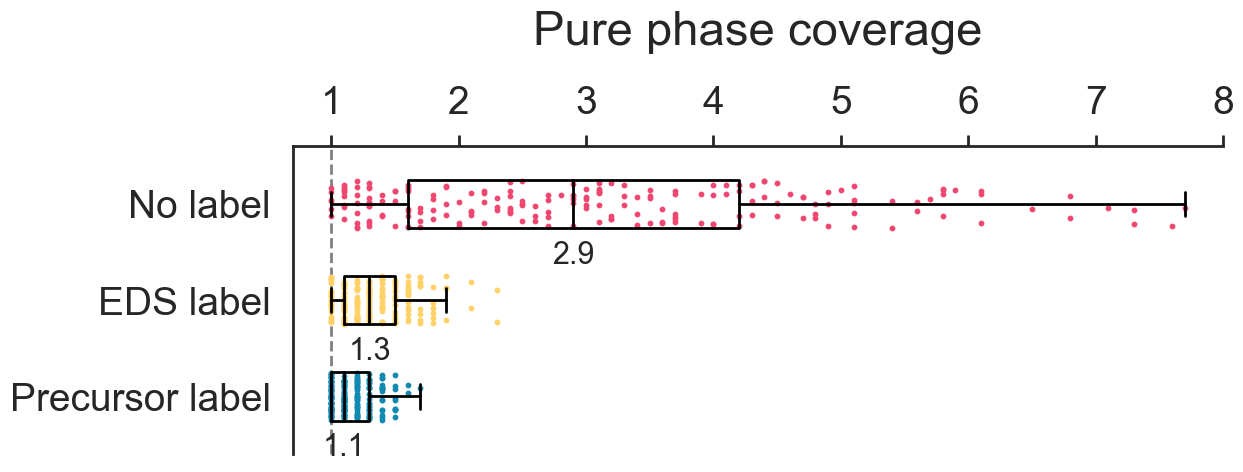

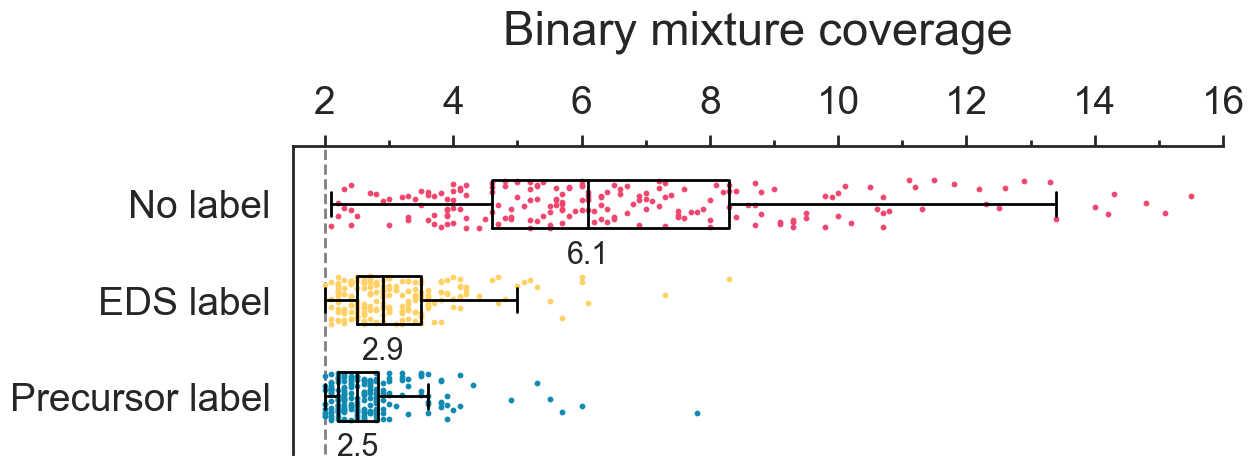

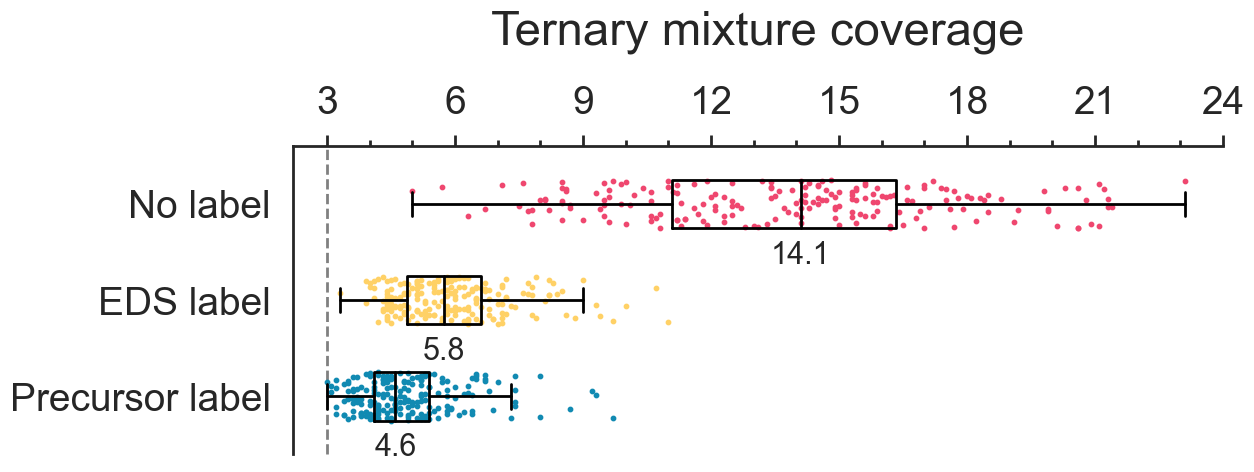

In [15]:
load_plt_setting()
stat_n = 10
prompt_type_list = ['full','eds','none',]
x_dic = {}
for n in ['1','2','3']:
    fig, ax = plt.subplots(figsize=(12, 4))
    x_dic[n] = {}
    for i, (prompt_type,c) in enumerate(zip(prompt_type_list,["#118ab2","#ffd166","#ef476f"])):
        x_dic[n][prompt_type] = {}
        x_dic[n][prompt_type]['raw'] = []
        y_pred_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_pred'])
        y_true_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_true'])
        for j in range(y_pred_full.shape[0]):
            x_dic[n][prompt_type]['raw'].append(coverage_error(y_true_full[j:j+1], y_pred_full[j:j+1]))
        x_dic[n][prompt_type]['stat'] = [np.mean(x_dic[n][prompt_type]['raw'][i:i+stat_n]) for i in range(0,len(x_dic[n][prompt_type]['raw']),stat_n)]
        y = np.random.uniform(i-0.25+1, i+0.25+1, size=len(x_dic[n][prompt_type]['stat']))
        ax.scatter(x_dic[n][prompt_type]['stat'], y, c=c, alpha=1, s=10)
        ax.text(np.median(x_dic[n][prompt_type]['stat']), 1+i-0.53, '{:.1f}'.format(np.median(x_dic[n][prompt_type]['stat'])), 
                ha='center', va='center', fontsize=22)
        
    boxplot = ax.boxplot([x_dic[n][prompt_type_list[0]]['stat'],x_dic[n][prompt_type_list[1]]['stat'],x_dic[n][prompt_type_list[2]]['stat']], 
                         notch=False, vert=False, widths=0.5, sym='', 
                         boxprops=dict(linewidth=2,c='black'), medianprops=dict(linewidth=2,c='black'),
                         whiskerprops=dict(linewidth=2,c='black'), capprops=dict(linewidth=2,c='black'))

    ax.set_ylim([0.4,3.6])
    ax.axes.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, integer=True, steps=[2, 5, 10]))
    ax.axes.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=9, integer=False, steps=[2, 3, 5, 10]))
    
    ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, length=8, width=2, pad=10, labelsize=28)
    ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, direction='out', length=4, width=2, pad=10)
    ax.tick_params(axis='y', labelsize=28)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(['','Precursor label ','EDS label ','No label '])
    plt.ylabel('', labelpad=20, fontsize=34)
    ax.xaxis.set_label_position('top')
    ax.axvline(x=int(n), clip_on=False, color='grey', linestyle='--', linewidth=2, zorder=-10)
    
    if n == '1':
        ax.set_xlim([0.7,8])
        plt.xlabel(r'Pure phase coverage', labelpad=30, fontsize=34)
    elif n == '2':
        ax.set_xlim([1.5,16])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        plt.xlabel(r'Binary mixture coverage', labelpad=30, fontsize=34)

    elif n == '3':
        ax.set_xlim([2.2,24])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(3))
        plt.xlabel(r'Ternary mixture coverage', labelpad=30, fontsize=34)

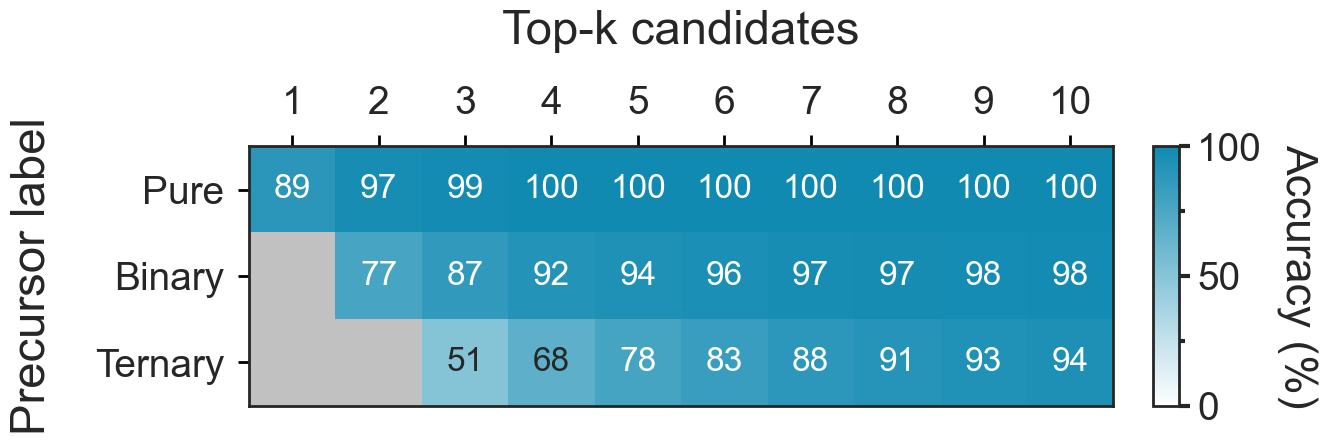

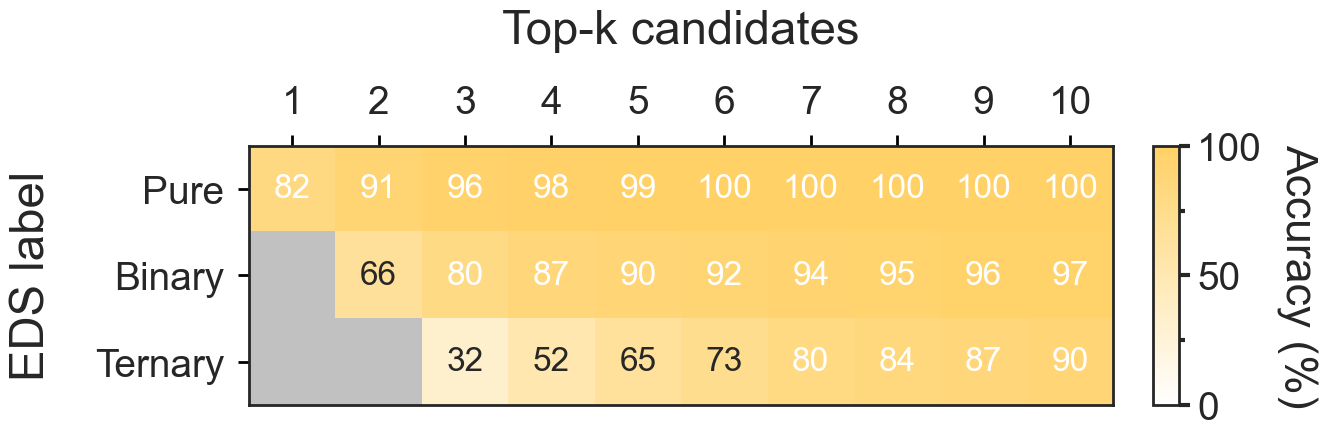

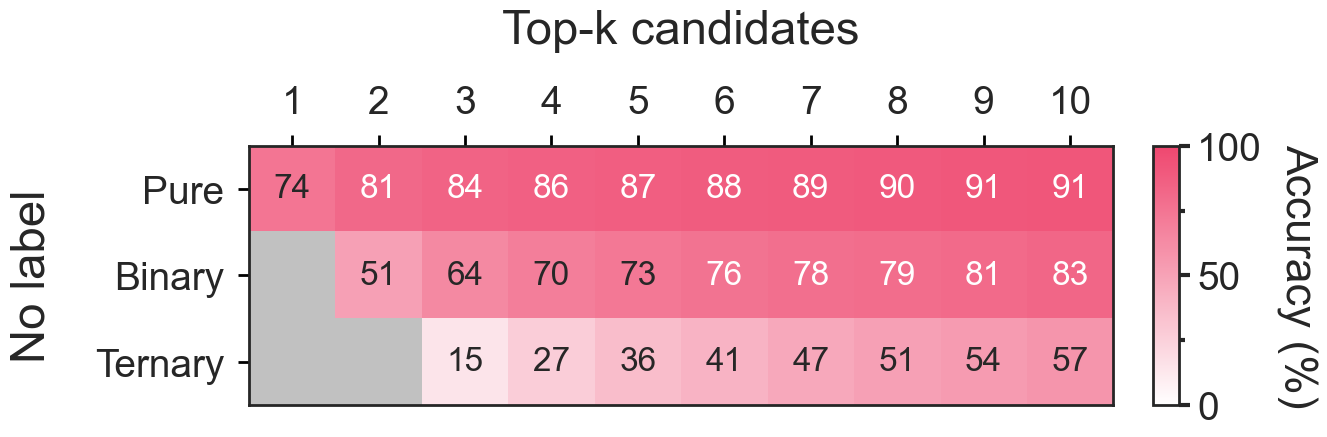

In [16]:
n_phase_list = ['Pure','Binary','Ternary']
prompt_type_list = ['full','eds','none',]
y_titles = ['Precursor label','EDS label','No label']
cmap_colors = ["#118ab2","#ffd166","#ef476f"]
n_list = ['1','2','3']

top_k_stats = np.zeros((len(n_list),len(prompt_type_list),11))
for i, n in enumerate(n_list):
    for j, prompt_type in enumerate(prompt_type_list):
        top_k_list = np.array(x_dic[n][prompt_type]['raw'])
        for k in range(1,11):
            top_k_stats[i,j,k] = len(top_k_list[top_k_list<=k])/len(top_k_list)
top_k_stats = top_k_stats[:,:,1:]-0.00001

load_plt_setting()

for k, prompt_type in enumerate(prompt_type_list):
    fig, ax = plt.subplots(figsize=(12, 10))
    mymap = colors.LinearSegmentedColormap.from_list("", ["#FFFFFF",cmap_colors[k]])
    mymap.set_under('#C1C1C1')

    mat = ax.matshow(top_k_stats[:,k,:]*100, cmap=mymap, vmax=100, vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, steps=[1, 2, 5, 10], integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, steps=[1, 2, 5, 10], integer=True))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28, 
                   top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28, 
                   top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_yticklabels(['','Pure','Binary','Ternary'])
    ax.set_xticklabels(['','1','2','3','4','5','6','7','8','9','10'])

    ax.set_xlabel(r'Top-k candidates', labelpad=30, fontsize=34)
    ax.set_ylabel(r'{}'.format(y_titles[k]), labelpad=30, fontsize=34)
    ax.xaxis.set_label_position('top')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.4)

    cbar = plt.colorbar(mat,cax=cax)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Accuracy (%)',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, integer=True, steps=[1,2,5,10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    for (i, j), z in np.ndenumerate(top_k_stats[:,k,:]*100):
        if z > 0:
            if z < 75:
                ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=24, c=colors.to_rgba("#272727"))
            else:
                ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=24, c=colors.to_rgba("#FFFFFF"))

# 4 Experimental XRD

In [4]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
visual_embedding_dim = 50
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'multi_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'multi_phase')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


## CsPbBr3

In [5]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'CsPbBr3.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 60.01, 0.01)
X = CubicSpline(data[:,0], data[:,1]-data[:,2])(np.arange(5.00, 45.01, 0.01))

Xs = np.zeros(twotheta.shape)
Xs[:X.shape[0]] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

sample_height_displacement = 0.000268*1000
for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
Xs = interp1d(twotheta_corrected, Xs, fill_value="extrapolate")(twotheta)
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['Cs Pb Br',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[33] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [2.3968203, 5.1520844, 1.8408216]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.030332608778140216 0 8 Cs0.2MA0.8PbBr3
0.032061594760684625 0 36 alpha-CsPbI3
0.03233231315065185 0 24 CsPb(I0.2Br0.8)3
0.032339944973539134 0 25 CsPb(I0.4Br0.6)3
0.03452048883538281 0 11 Cs0.8MA0.2PbBr3
0.038066194795261896 0 23 CsPb(Cl0.8Br0.2)3
0.03958362117699852 0 20 CsPb(Cl0.2Br0.8)3
0.04187792492936674 0 2 Cs0.6FA0.4PbBr3
0.042083383430464125 0 27 CsPb(I0.8Br0.2)3
0.06629746880789189 0 26 CsPb(I0.6Br0.4)3
0.08790684726233941 0 10 Cs0.6MA0.4PbBr3
0.12854617012876352 0 37 delta-CsPbI3
0.13401675226383325 0 38 gamma-CsPbI3
0.13647933948481913 0 3 Cs0.8FA0.2PbBr3
0.3769076774670371 0 19 CsPb2Br5
0.4200679597858669 0 17 CsBr
0.8219312632623731 0 64 PbBr2
0.9437191470350522 0 16 Cs4PbBr6
0.9780819223005028 0 32 cubic-CsPbBr3
0.9969955084391832 1 33 orthorhombic-CsPbBr3


Text(0.5, 0, 'Prediction score')

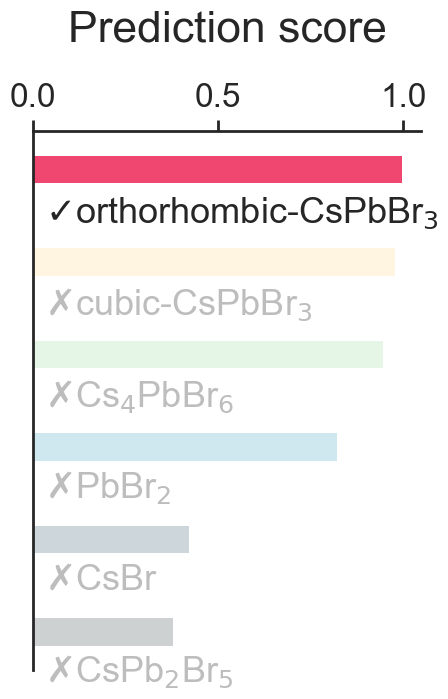

In [6]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']
identified_no = []
identified_color = []

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
        identified_no.append(int(order_sort[-i-1]))
        identified_color.append(cmap[i])
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

# ax.tick_params(axis='y', labelsize=24)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

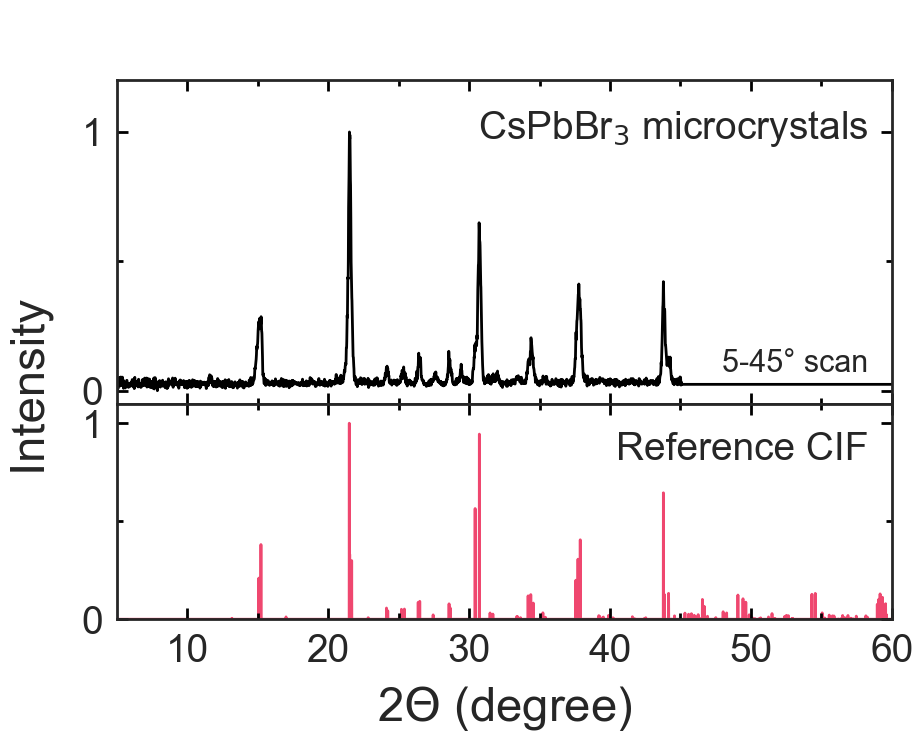

In [7]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for i, (sample_no, c) in enumerate(zip(identified_no,identified_color)):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c, zorder=-i)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'CsPbBr$_{3}$ microcrystals', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIF', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')

plt.text(0.97, 0.1, '5-45'+u"\u00b0"+' scan', fontsize=22, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)

## Off-stoichiometry Cs-Pb-Br (Cs-rich)

In [8]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'CsPbBr3_Cs-rich.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 60.01, 0.01)
Xs = np.zeros(twotheta_corrected.shape)
X = data[:,1]-data[:,2]
Xs[500:] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

sample_height_displacement = 0.000486*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))

Xs = interp1d(twotheta_corrected, Xs, fill_value="extrapolate")(twotheta)
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['Cs Pb Br']

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[16] += 1
y_true_full[33] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [-1.7229276, 4.5967073, 3.1588337]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.010095193594093856 0 22 CsPb(Cl0.6Br0.4)3
0.010538255696494882 0 65 PbI2
0.011003084111538794 0 20 CsPb(Cl0.2Br0.8)3
0.011113279037526355 0 34 cubic-CsPbCl3
0.016972488332695043 0 18 CsI
0.017769209556267172 0 25 CsPb(I0.4Br0.6)3
0.01903876198456786 0 24 CsPb(I0.2Br0.8)3
0.02235176812858498 0 26 CsPb(I0.6Br0.4)3
0.026046437806682206 0 23 CsPb(Cl0.8Br0.2)3
0.06895997200589113 0 36 alpha-CsPbI3
0.07164866502503434 0 10 Cs0.6MA0.4PbBr3
0.11749698266588365 0 3 Cs0.8FA0.2PbBr3
0.2948465718023605 0 38 gamma-CsPbI3
0.3176672704301349 0 37 delta-CsPbI3
0.4316073770284996 0 32 cubic-CsPbBr3
0.4692209179326976 0 19 CsPb2Br5
0.8781002403488717 0 17 CsBr
0.9364873968559695 0 64 PbBr2
0.9760764877214527 1 16 Cs4PbBr6
0.9923168361704491 1 33 orthorhombic-CsPbBr3


Text(0.5, 0, 'Prediction score')

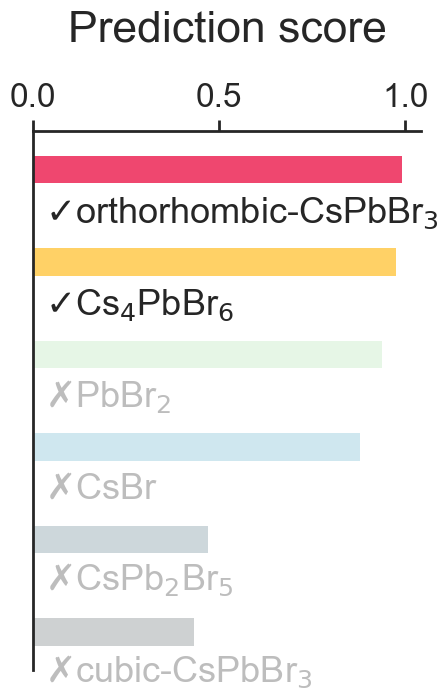

In [9]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']
identified_no = []
identified_color = []

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
        identified_no.append(int(order_sort[-i-1]))
        identified_color.append(cmap[i])
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

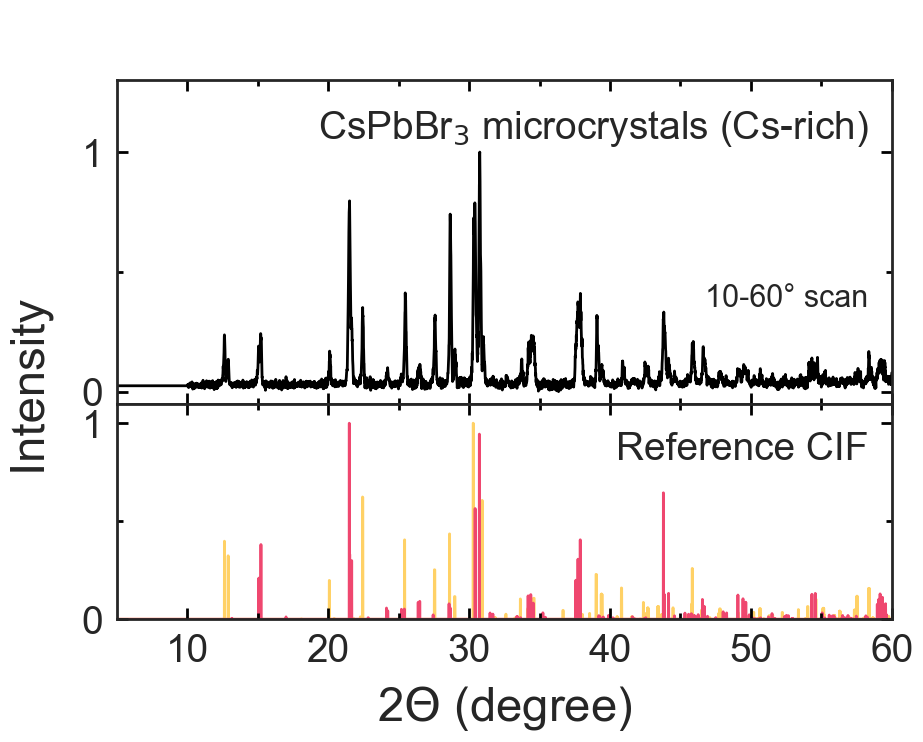

In [10]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.3])

formula = []
for i, (sample_no, c) in enumerate(zip(identified_no,identified_color)):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c, zorder=-i)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'CsPbBr$_{3}$ microcrystals (Cs-rich)', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIF', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')
plt.text(0.97, 0.30, '10-60'+u"\u00b0"+' scan', fontsize=22, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)

## MAPbI3

In [11]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'MAPbI3.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]-data[:,2]
sample_height_displacement = -0.003015*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))

X = interp1d(twotheta_corrected, X, fill_value="extrapolate")(twotheta)
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))
Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['MA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[62] += 1
y_true_full[63] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [2.7138686, 5.0362396, 1.7066102]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.0231181710592736 0 59 cubic-MAPbBr3
0.023413559697329608 0 51 MA0.2FA0.8PbI3
0.03418899977825518 0 55 MAPb(Br0.2I0.8)3
0.045585186364527276 0 45 beta-FAPbI3
0.050449623811691824 0 61 orthorhombic-MAPbCl3
0.05079339001342486 0 60 tetragonal-MAPbBr3
0.05195403143056137 0 58 MAPb(Br0.8I0.2)3
0.05407759462356184 0 57 MAPb(Br0.6I0.4)3
0.05601895757656501 0 14 Cs0.6MA0.4PbI3
0.07442375539264003 0 15 Cs0.8MA0.2PbI3
0.0928173843973212 0 13 Cs0.4MA0.6PbI3
0.09559247601338566 0 64 PbBr2
0.10180446446375478 0 36 alpha-CsPbI3
0.12032668506812626 0 12 Cs0.2MA0.8PbI3
0.15875615197411055 0 18 CsI
0.19046626753623397 0 37 delta-CsPbI3
0.2582268993021955 0 38 gamma-CsPbI3
0.7510051513214359 0 65 PbI2
0.994155267314883 1 63 tetragonal-MAPbI3
0.9949159776430182 1 62 alpha-MAPbI3


Text(0.5, 0, 'Prediction score')

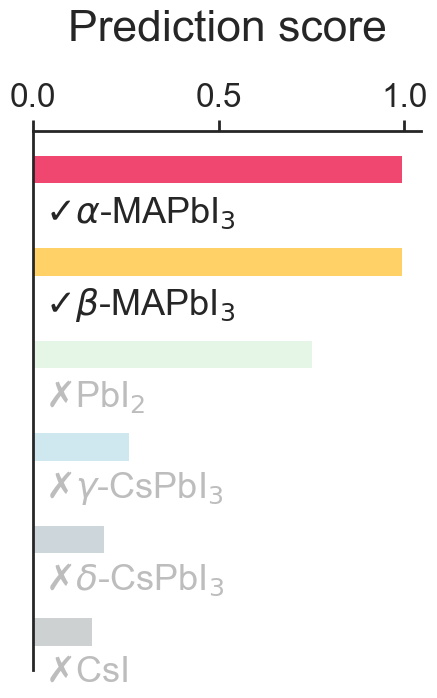

In [12]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']
identified_no = []
identified_color = []

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
        identified_no.append(int(order_sort[-i-1]))
        identified_color.append(cmap[i])
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

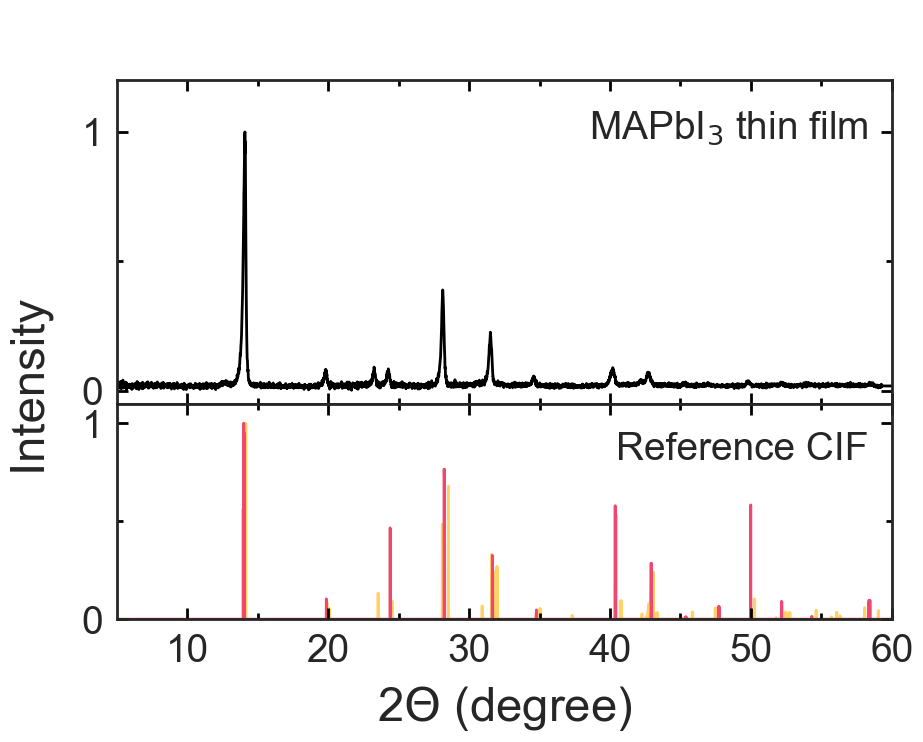

In [13]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for i, (sample_no, c) in enumerate(zip(identified_no,identified_color)):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c, zorder=-i)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'MAPbI$_{3}$ thin film', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIF', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')
    
plt.subplots_adjust(hspace=.0)

ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)

## FAPbI3

In [14]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'FAPbI3.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]-data[:,2]

sample_height_displacement = -0.000329*1000
for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))

X = interp1d(twotheta_corrected, X, fill_value="extrapolate")(twotheta)
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))
Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[44] += 1
y_true_full[46] += 1
y_true_full[65] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [-0.7565842, 4.7450304, 2.6763277]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.012235378443776082 0 40 FAPb(Br0.4I0.6)3
0.021378258215725247 0 63 tetragonal-MAPbI3
0.02569741805807049 0 5 Cs0.4FA0.6PbI3
0.027237416572383353 0 39 FAPb(Br0.2I0.8)3
0.03042078158682623 0 54 MA0.8FA0.2PbI3
0.03687374169216503 0 37 delta-CsPbI3
0.045967253826051414 0 64 PbBr2
0.05041441212274996 0 42 FAPb(Br0.8I0.2)3
0.05965552879966828 0 62 alpha-MAPbI3
0.08039287284592833 0 4 Cs0.2FA0.8PbI3
0.08290286968489707 0 18 CsI
0.10637669505405631 0 38 gamma-CsPbI3
0.10856397700614265 0 6 Cs0.6FA0.4PbI3
0.13508454297097577 0 7 Cs0.8FA0.2PbI3
0.14196442698713976 0 43 cubic-FAPbBr3
0.14742750569181332 0 36 alpha-CsPbI3
0.9413254103228079 1 46 delta-FAPbI3
0.9608253148734076 0 45 beta-FAPbI3
0.98697474771567 1 65 PbI2
0.9888633982795495 1 44 alpha-FAPbI3


Text(0.5, 0, 'Prediction score')

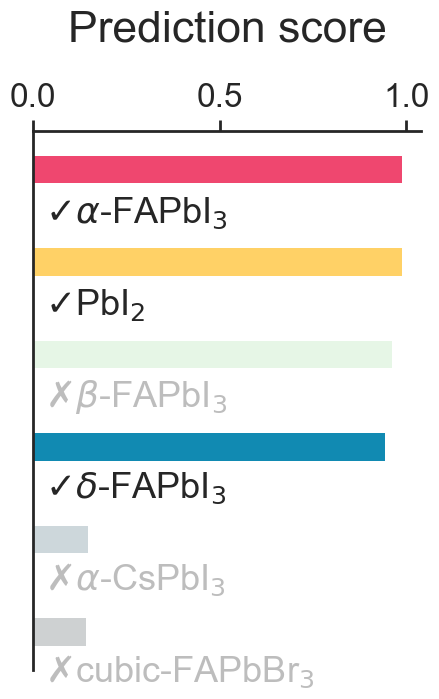

In [15]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']
identified_no = []
identified_color = []

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
        identified_no.append(int(order_sort[-i-1]))
        identified_color.append(cmap[i])
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

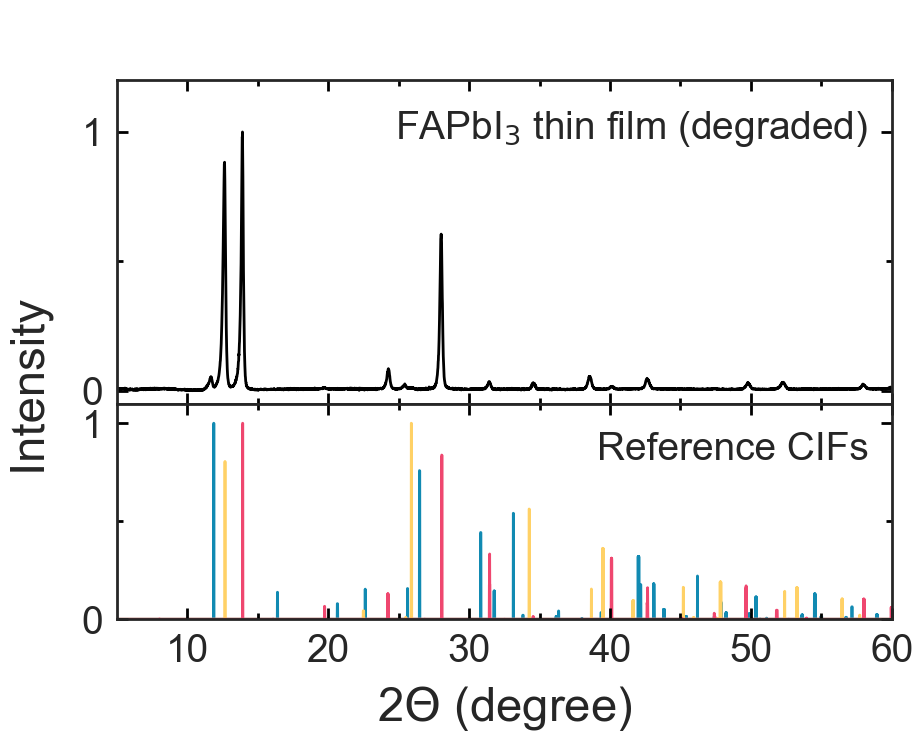

In [16]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for i, (sample_no, c) in enumerate(zip(identified_no,identified_color)):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c, zorder=-i)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'FAPbI$_{3}$ thin film (degraded)', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIFs', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')
    
plt.subplots_adjust(hspace=.0)

sample_no = 860
ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)